In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm_notebook

In [2]:
def solve_linear(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1]
    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]

    return xc

In [3]:
def get_dt(dx, u, chi, coeff=0.9):
    return coeff * (dx ** 2) / (u * dx + 2 * chi)

In [4]:
u = 1
chi = 0
dx = 0.01
dt = 0.01

s = u * dt / dx
r = chi * dt / (dx ** 2)

In [5]:
teta = 20
a = 0
b = 10

In [6]:
K = int((b - a) / dx) + 1

In [7]:
start = np.zeros(K, dtype=np.float64)
for i in range(K // 2):
    start[i] = 1.

In [8]:
def left_border(t):
    return 0

def right_border(t):
    return 0

In [9]:
def solve(solver):
    t = 0

    Ts = []
    Ts.append(start)

    while (t < teta):
        t += dt
        cur = solver(t, Ts)
        Ts.append(cur)
    
    return Ts

In [10]:
def evident_opposite(t, Ts):
    cur = np.zeros(K, dtype=np.float64)

    for i in range(K):
        prev_t = Ts[-1][i - 1] if i > 0 else left_border(t)
        next_t = Ts[-1][i + 1] if i < K - 1 else right_border(t)
        cur_t = Ts[-1][i]

        cur[i] = cur_t - s * (cur_t - prev_t) + r * (prev_t + next_t - 2 * cur_t)
    
    return cur

In [11]:
def evident_nonopposite(t, Ts):
    cur = np.zeros(K, dtype=np.float64)

    for i in range(K):
        prev_t = Ts[-1][i - 1] if i > 0 else left_border(t)
        next_t = Ts[-1][i + 1] if i < K - 1 else right_border(t)
        cur_t = Ts[-1][i]

        cur[i] = cur_t - s * (next_t - cur_t) + r * (prev_t + next_t - 2 * cur_t)
    
    return cur

In [12]:
def confusion(t, Ts):
    assert math.isclose(chi, 0.)
    
    if len(Ts) == 1:
        return evident_opposite(t, Ts)
    
    cur = np.zeros(K, dtype=np.float64)
    
    for i in range(K):
        prev_t = Ts[-1][i - 1] if i > 0 else left_border(t)
        next_t = Ts[-1][i + 1] if i < K - 1 else right_border(t)
        cur_t = Ts[-2][i]

        cur[i] = cur_t - s * (next_t - prev_t)
    
    return cur

In [13]:
def nonevident_opposite(t, Ts):
    a = np.zeros(K - 1, dtype=np.float64)
    b = np.zeros(K, dtype=np.float64)
    c = np.zeros(K - 1, dtype=np.float64)
    d = np.zeros(K, dtype=np.float64)
    
    for i in range(K):
        b[i] = 1 + s + 2 * r
        d[i] = Ts[-1][i]
    d[0] += left_border(t) * (r + s)
    d[K - 1] += right_border(t) * r
    for i in range(K - 1):
        a[i] = - r - s
        c[i] = -r
    return solve_linear(a, b, c, d)

In [14]:
def nonevident_nonopposite(t, Ts):
    a = np.zeros(K - 1, dtype=np.float64)
    b = np.zeros(K, dtype=np.float64)
    c = np.zeros(K - 1, dtype=np.float64)
    d = np.zeros(K, dtype=np.float64)
    
    for i in range(K):
        b[i] = 1 - s + 2 * r
        d[i] = Ts[-1][i]
    d[0] += left_border(t) * r
    d[K - 1] -= right_border(t) * (s - r)
    
    for i in range(K - 1):
        a[i] = -r
        c[i] = s - r
    
    return solve_linear(a, b, c, d)

In [15]:
Ts = solve(confusion)

/anaconda3/envs/computational_methods/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


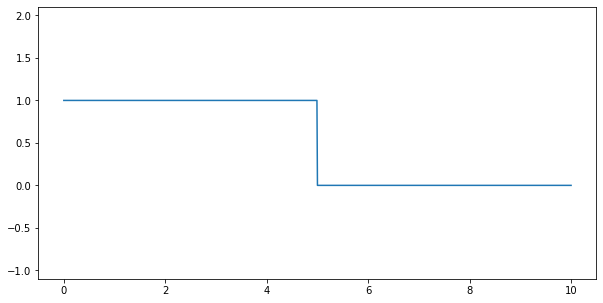

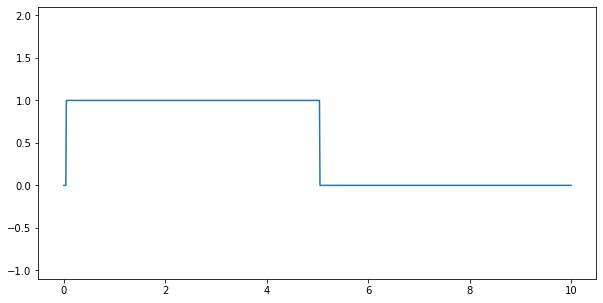

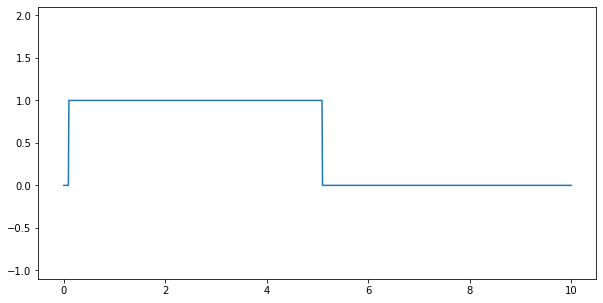

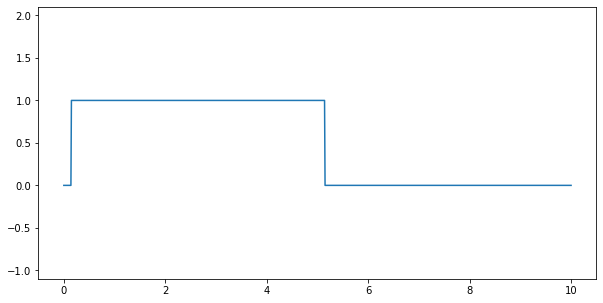

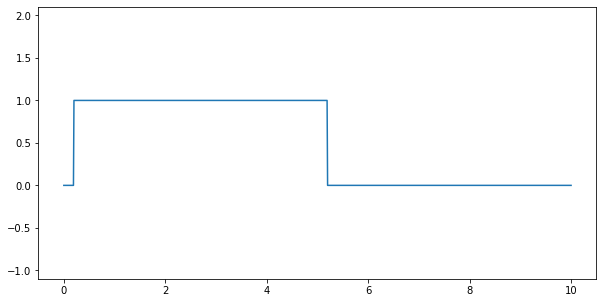

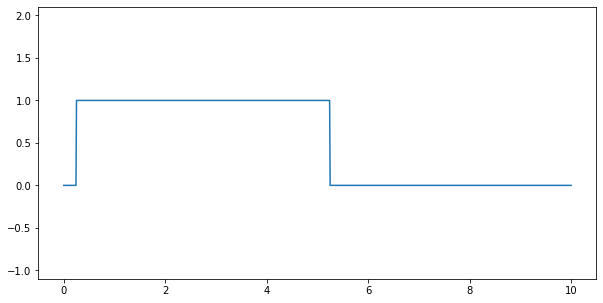

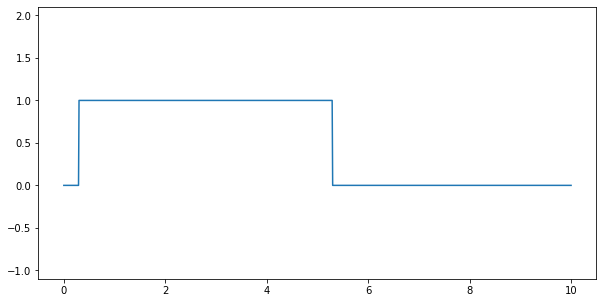

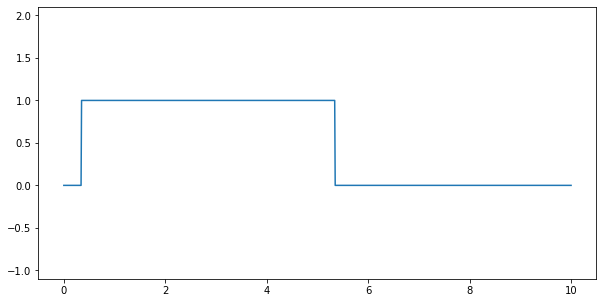

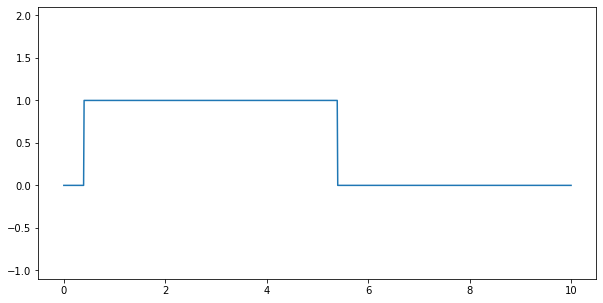

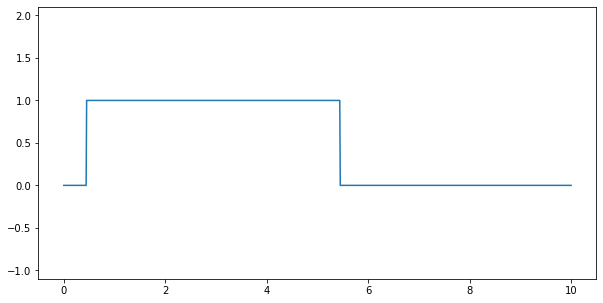

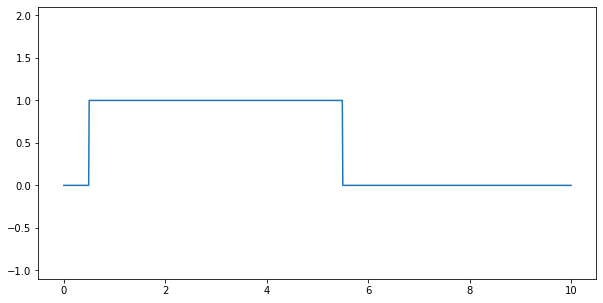

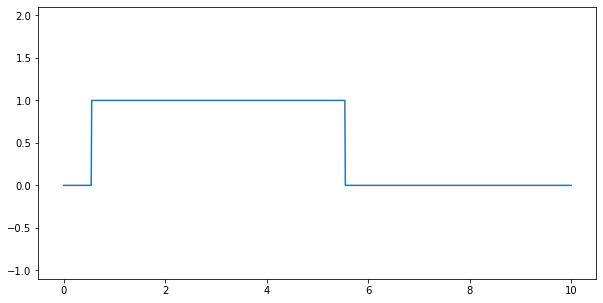

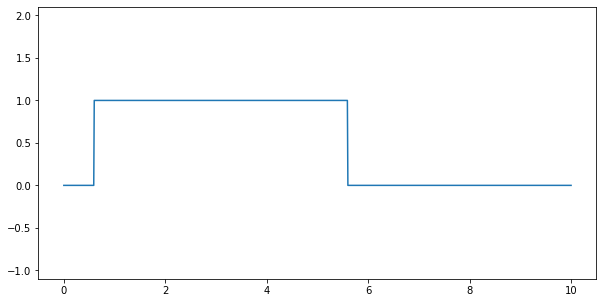

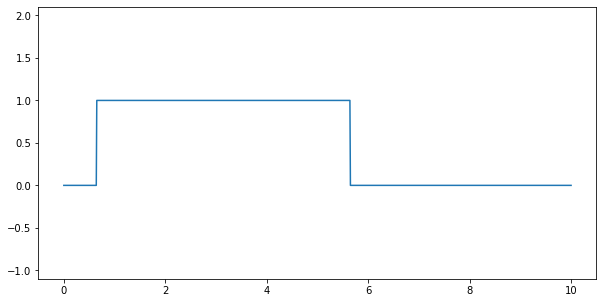

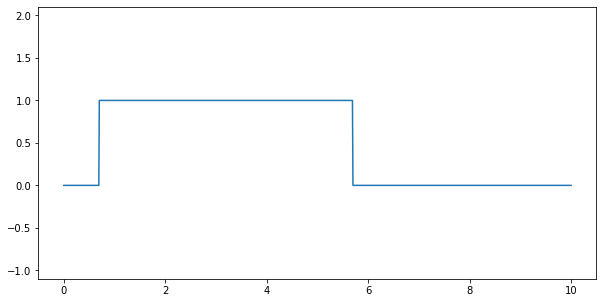

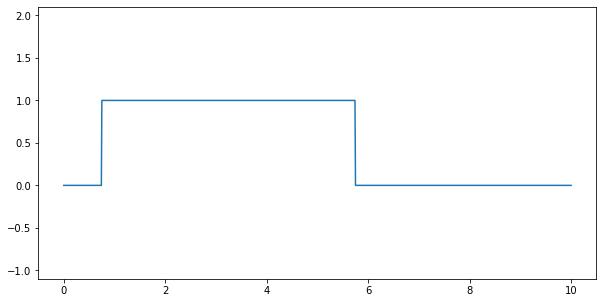

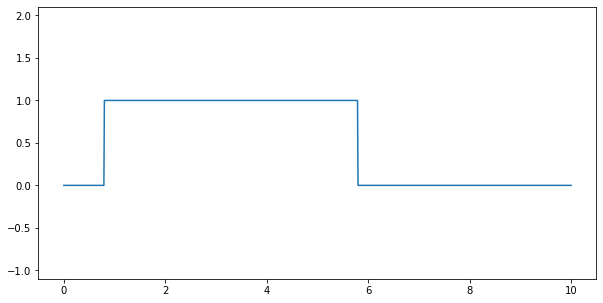

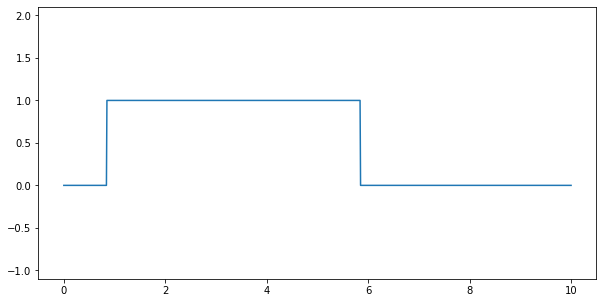

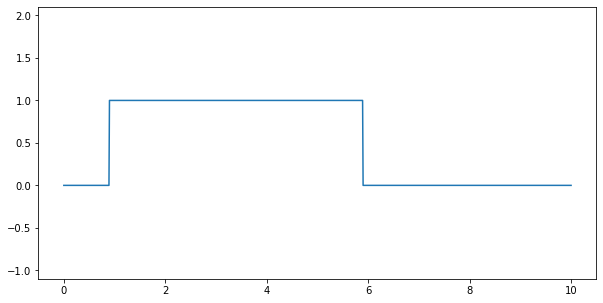

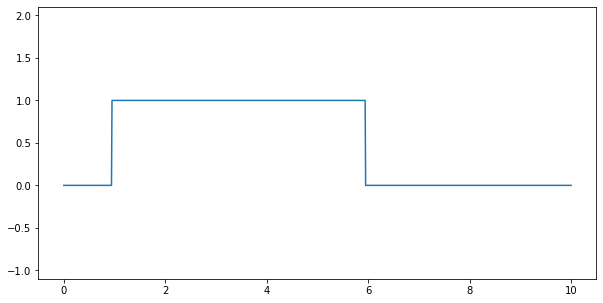

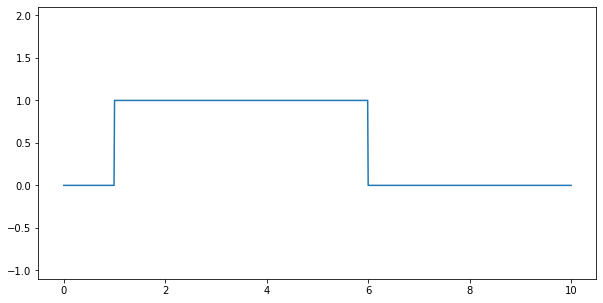

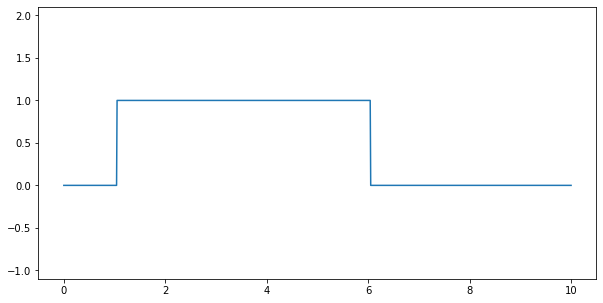

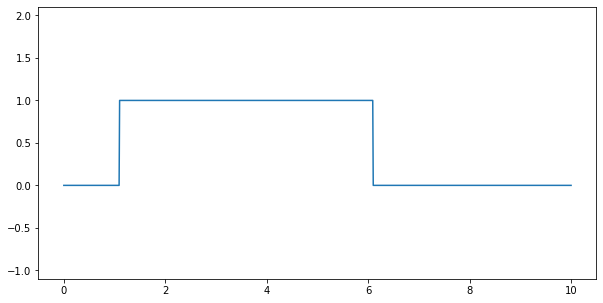

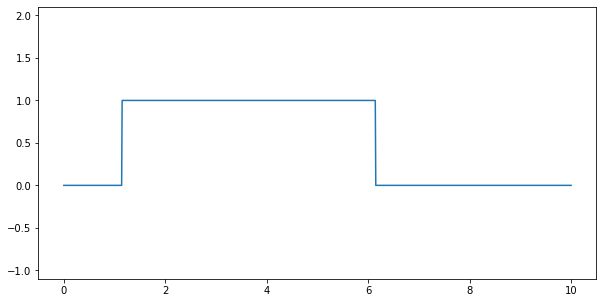

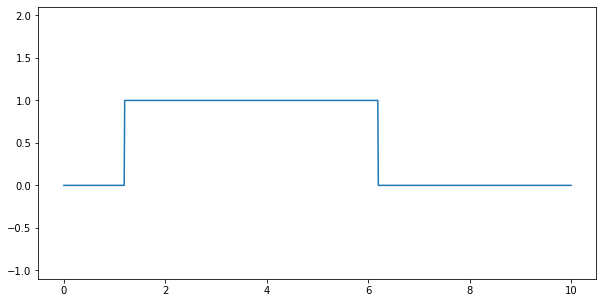

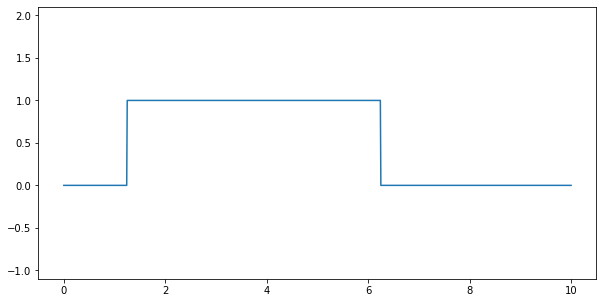

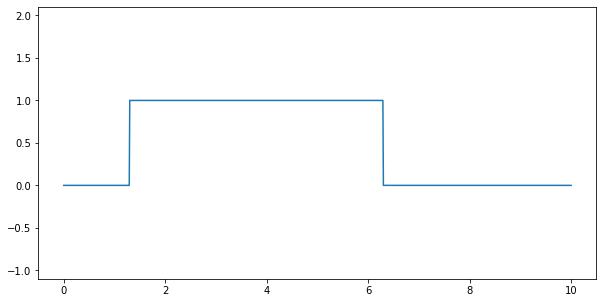

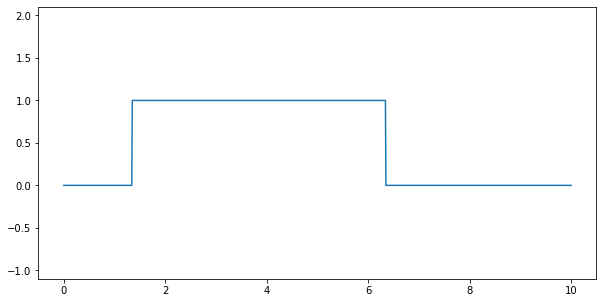

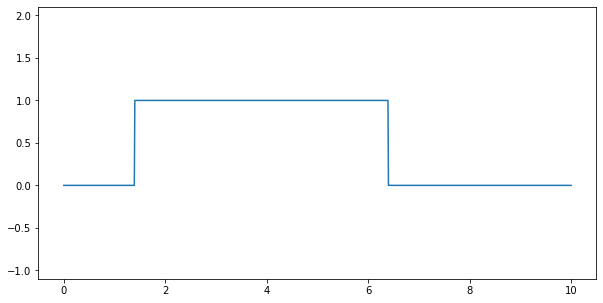

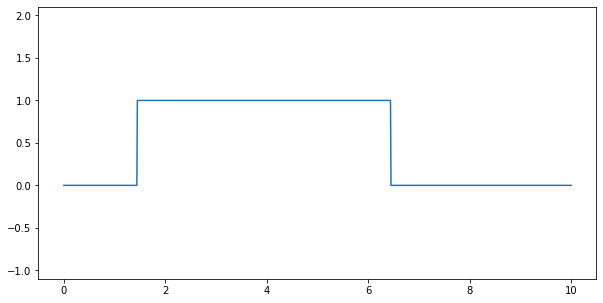

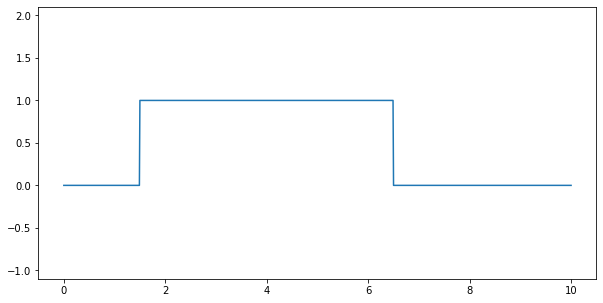

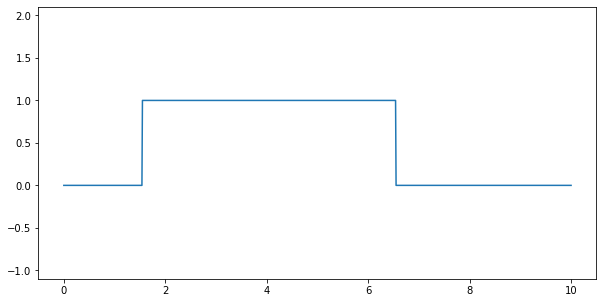

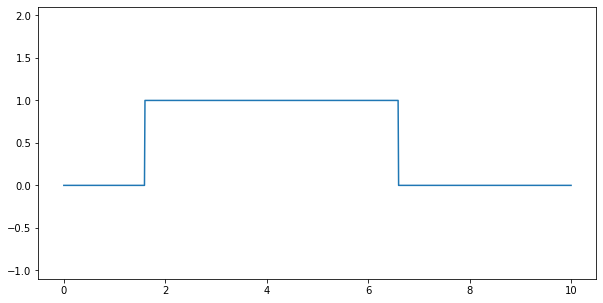

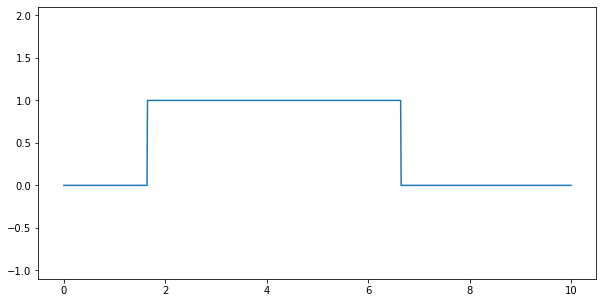

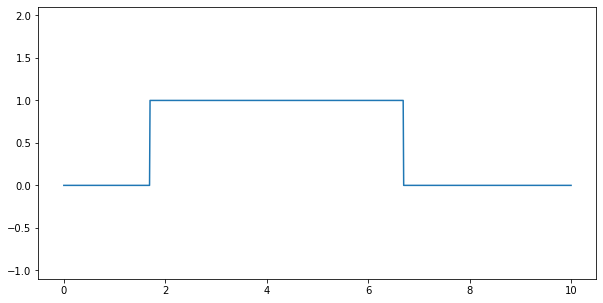

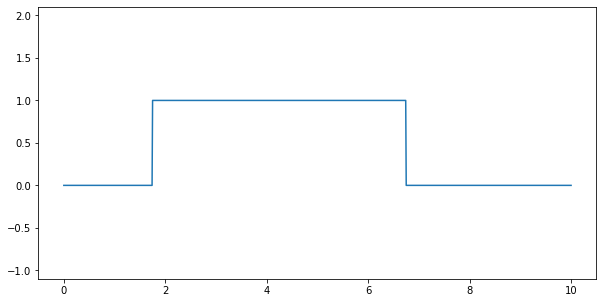

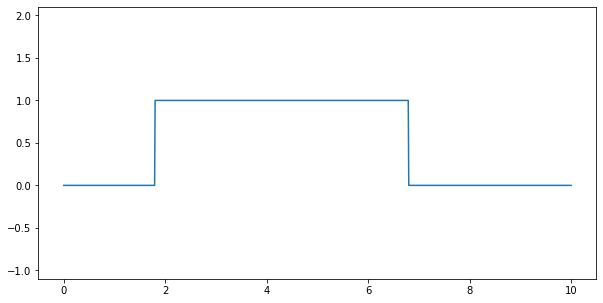

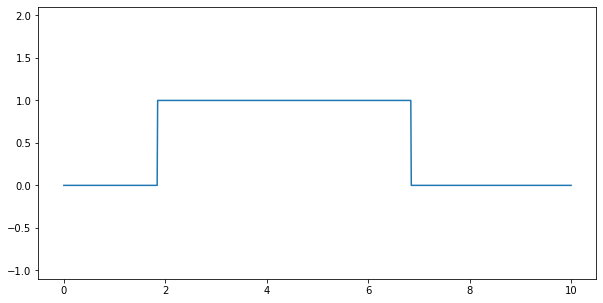

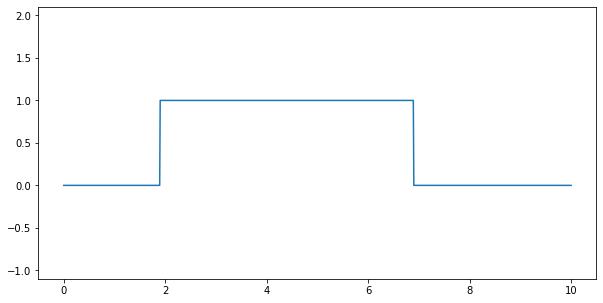

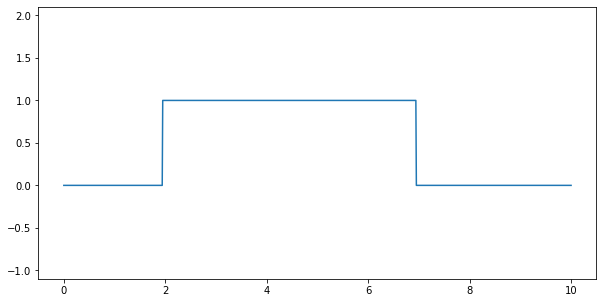

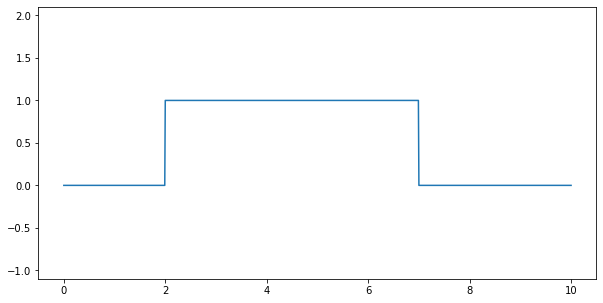

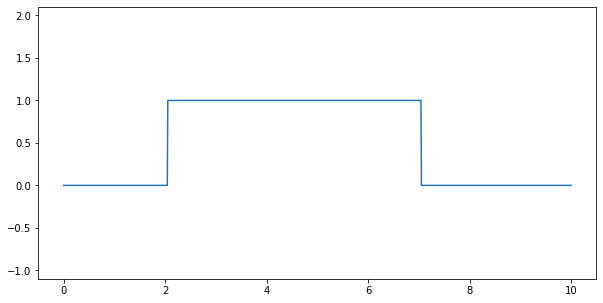

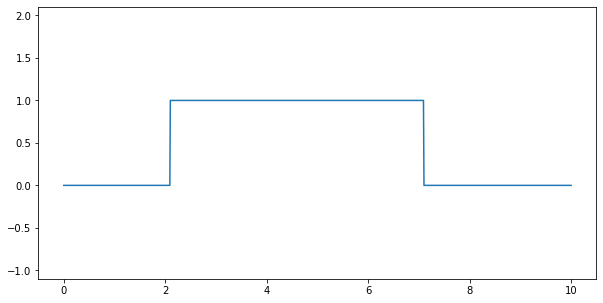

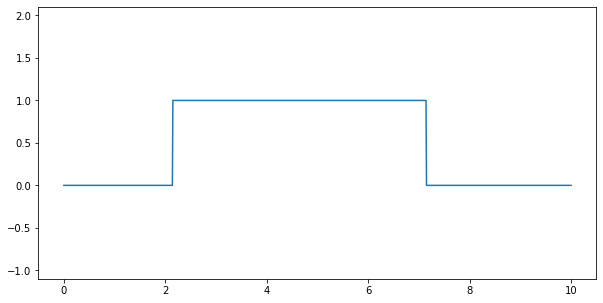

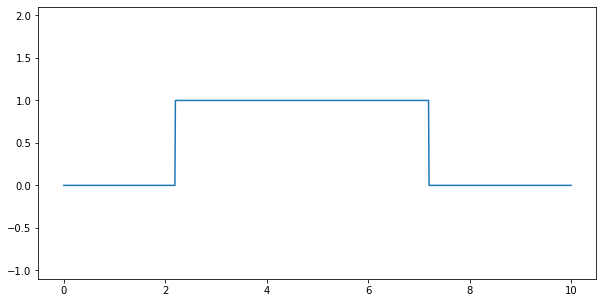

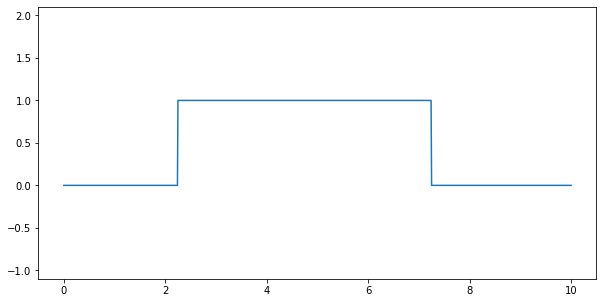

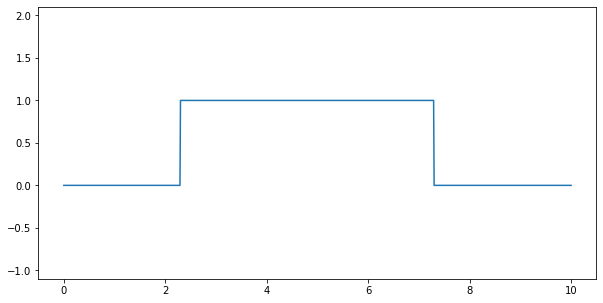

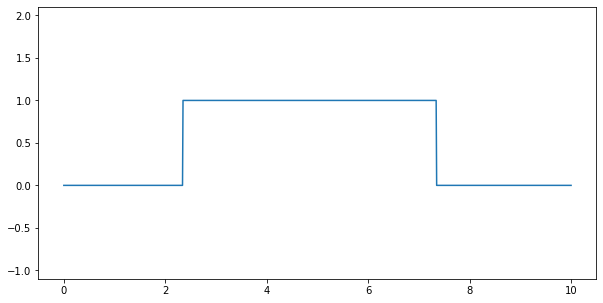

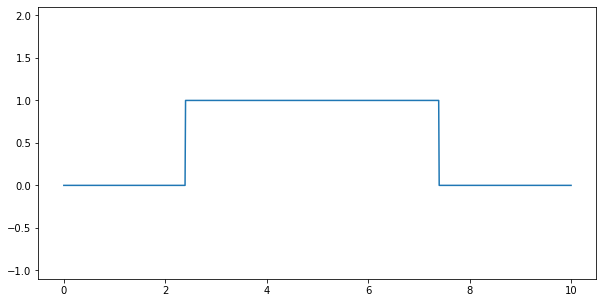

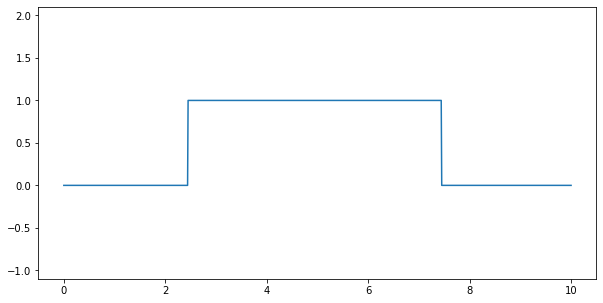

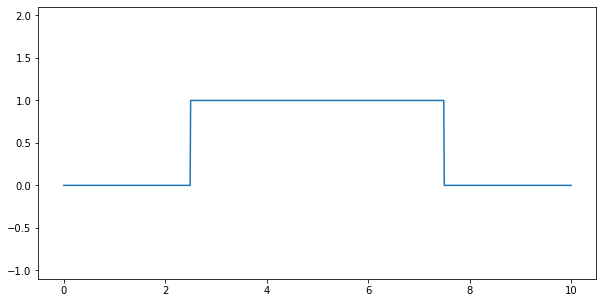

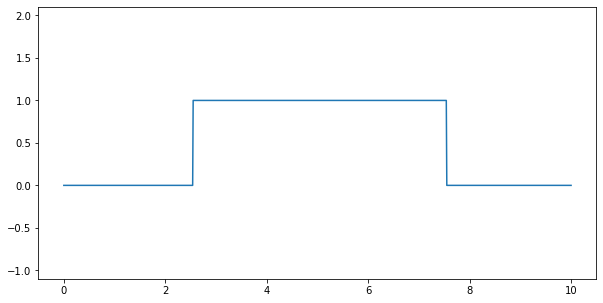

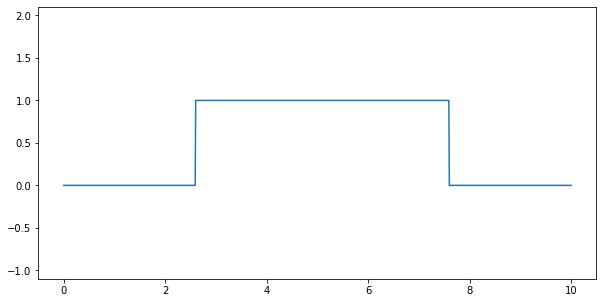

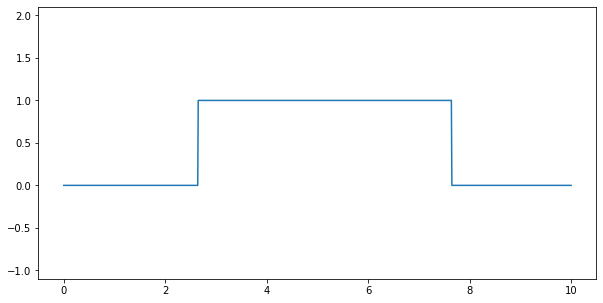

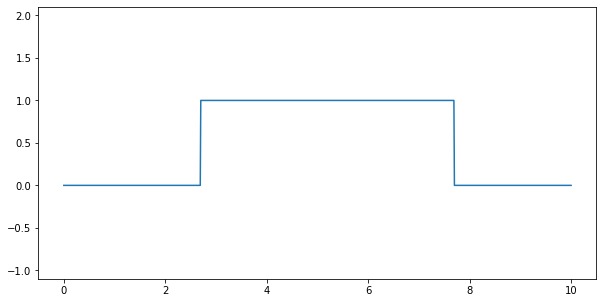

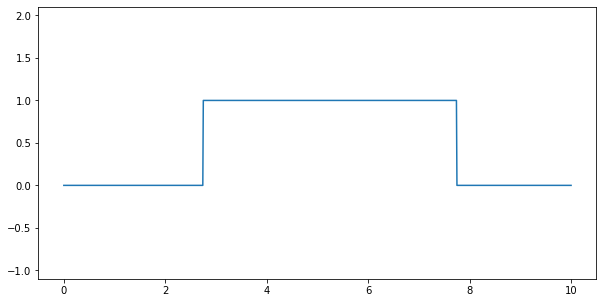

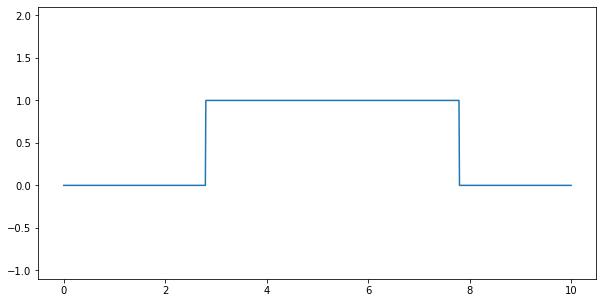

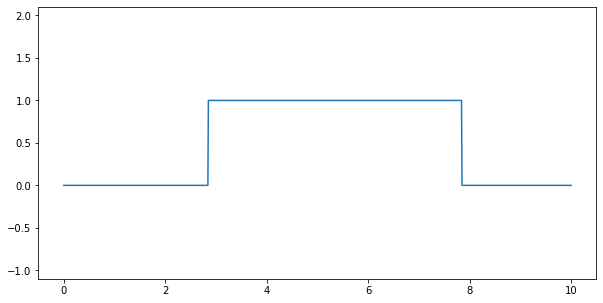

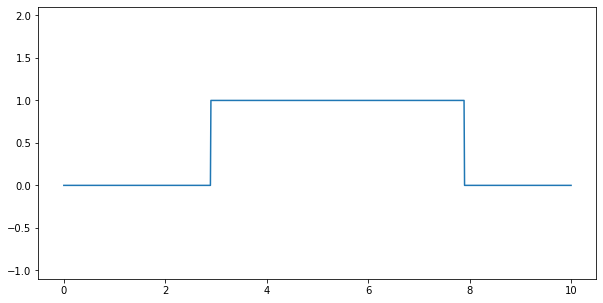

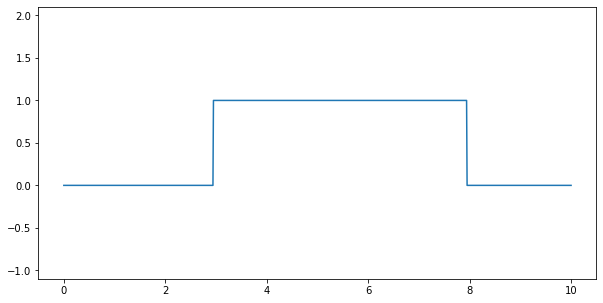

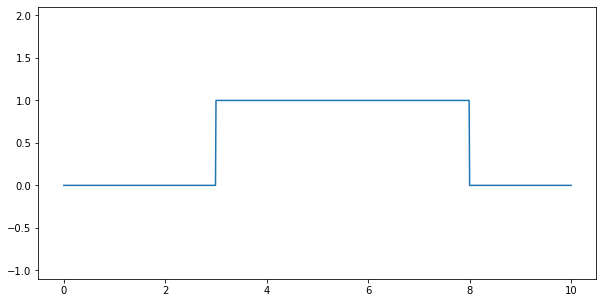

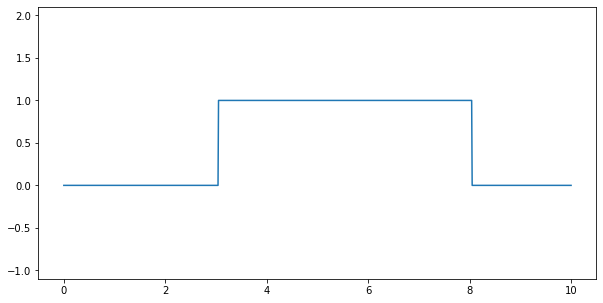

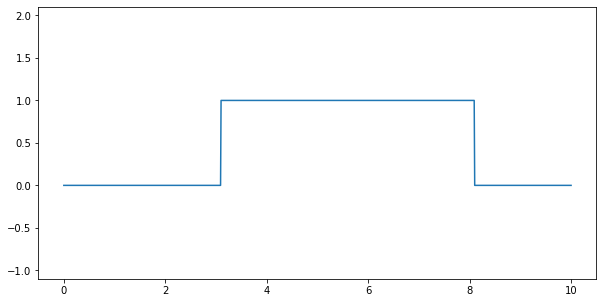

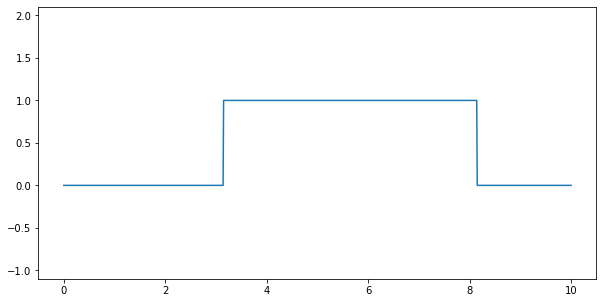

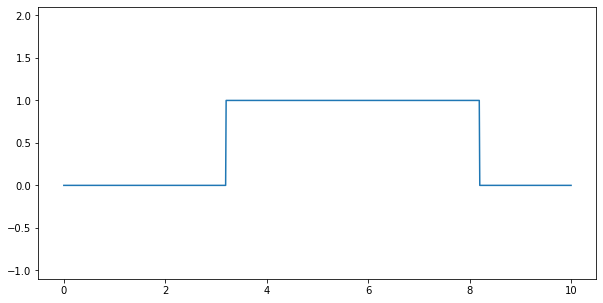

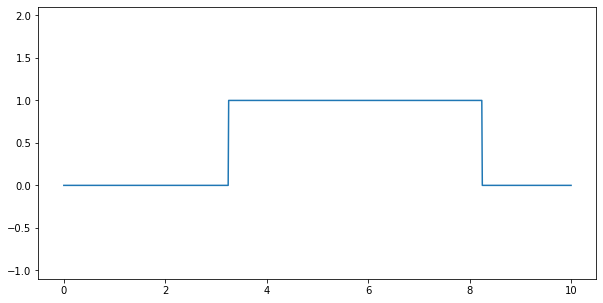

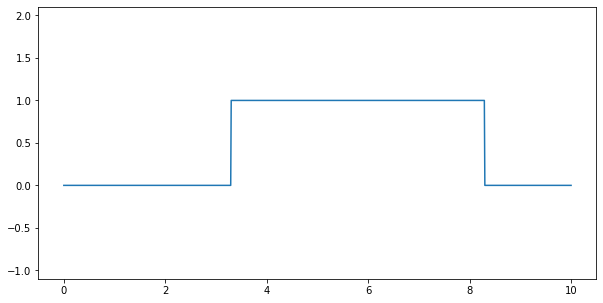

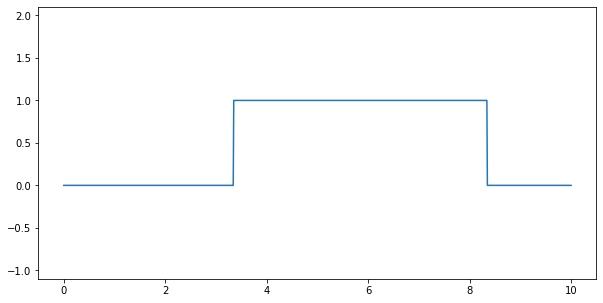

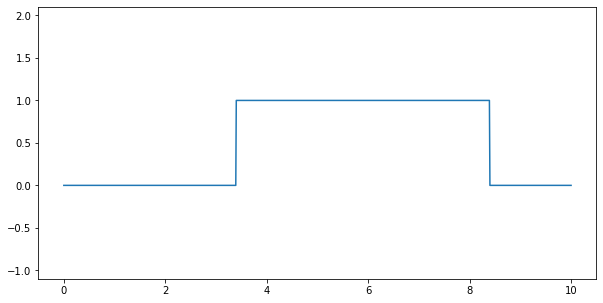

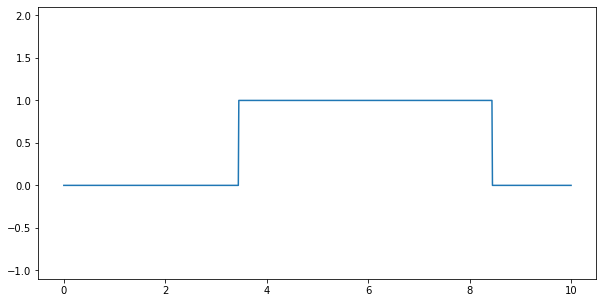

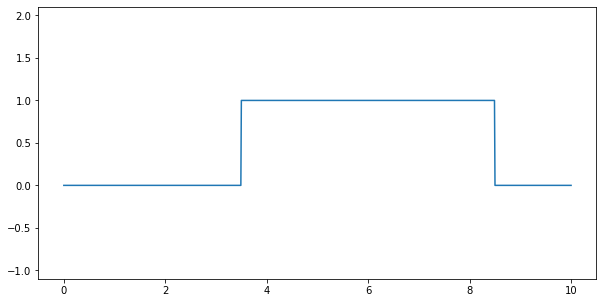

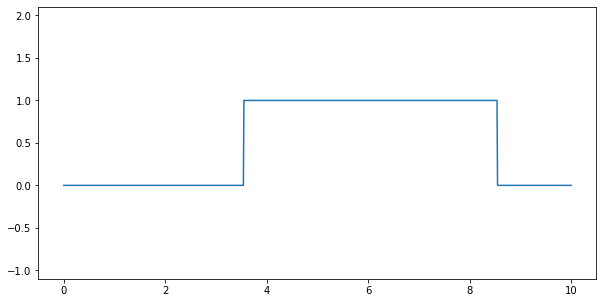

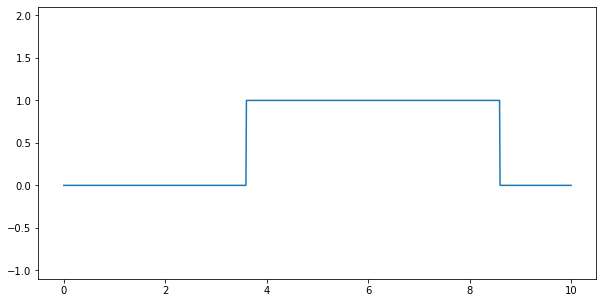

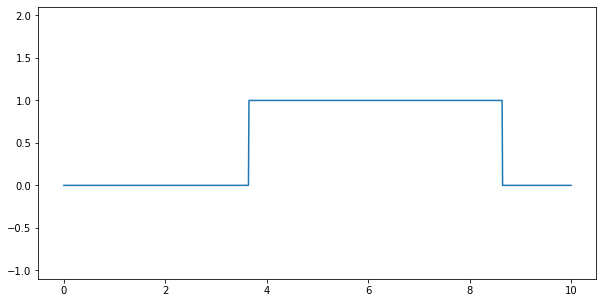

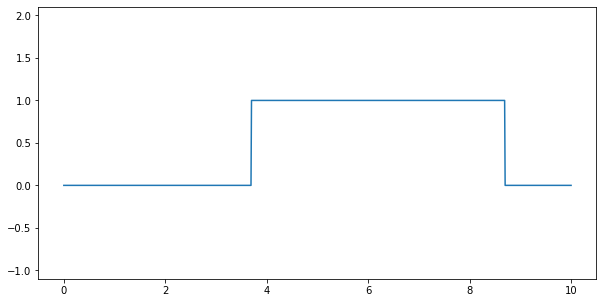

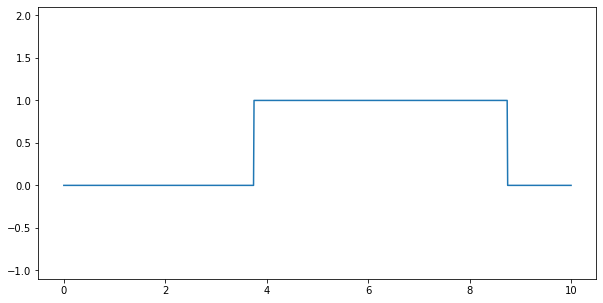

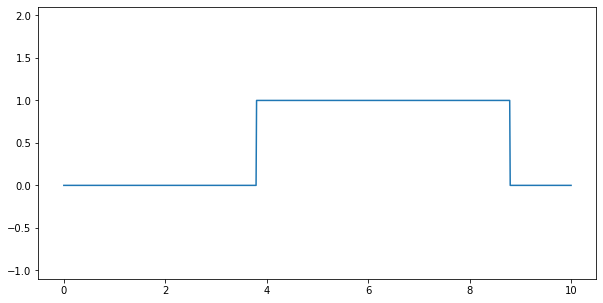

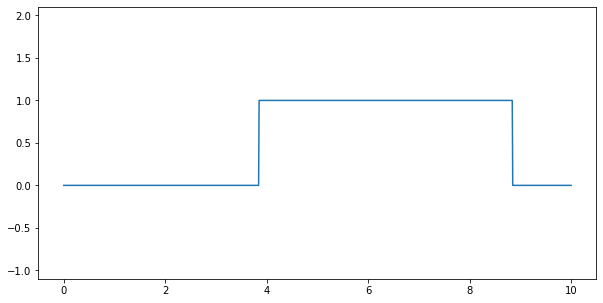

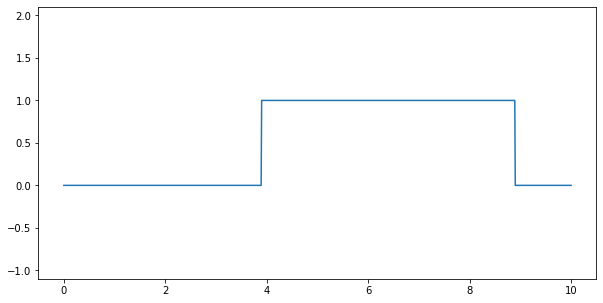

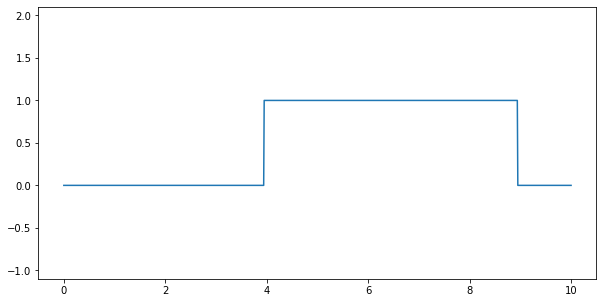

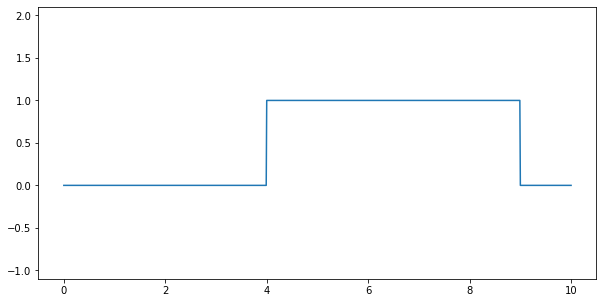

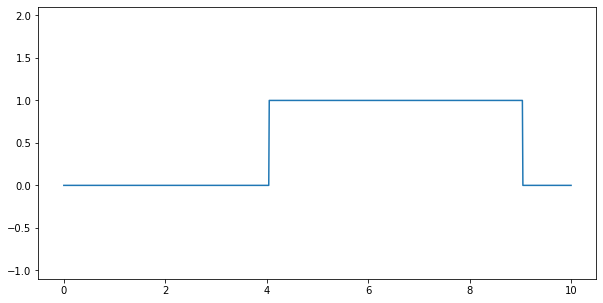

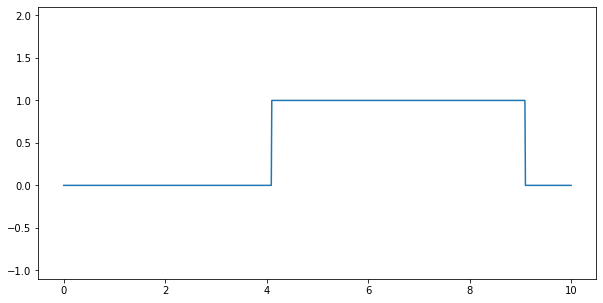

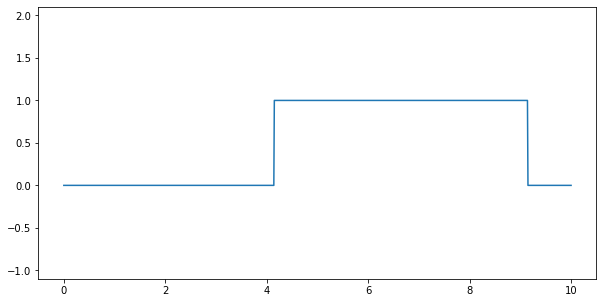

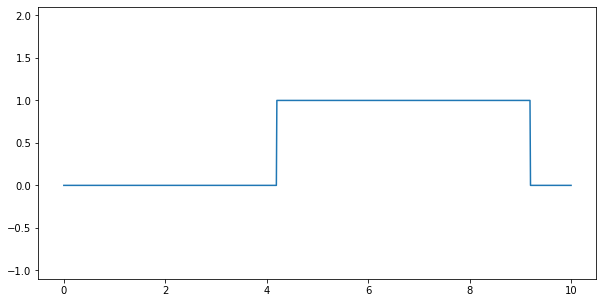

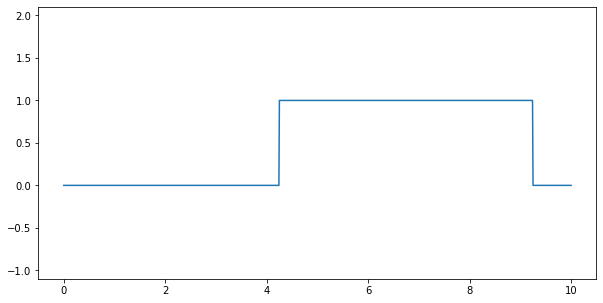

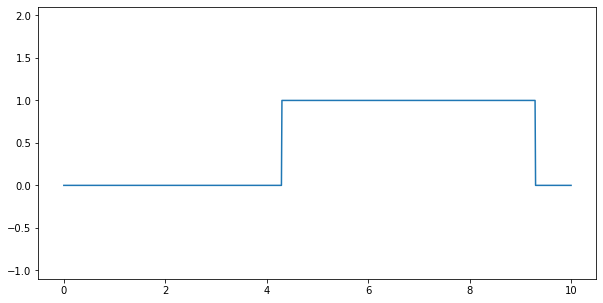

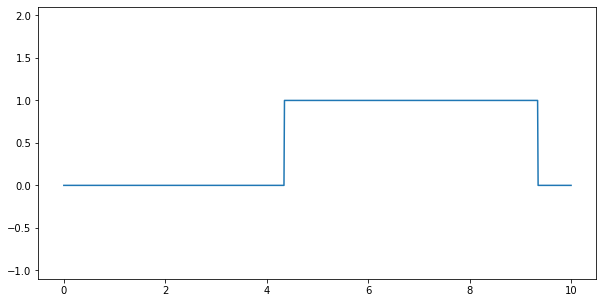

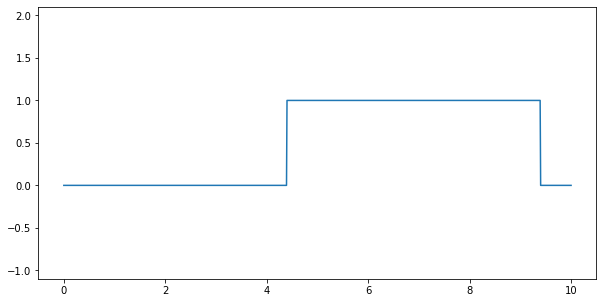

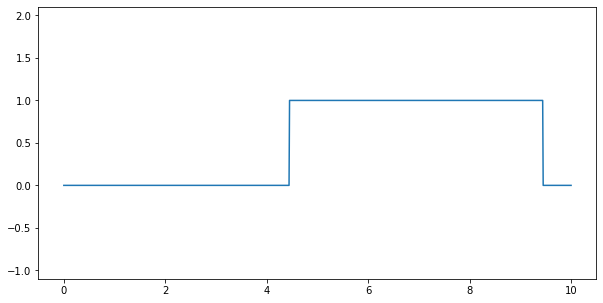

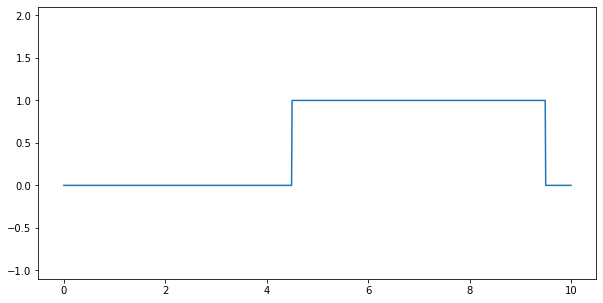

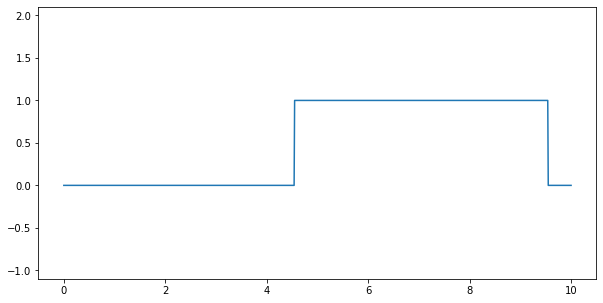

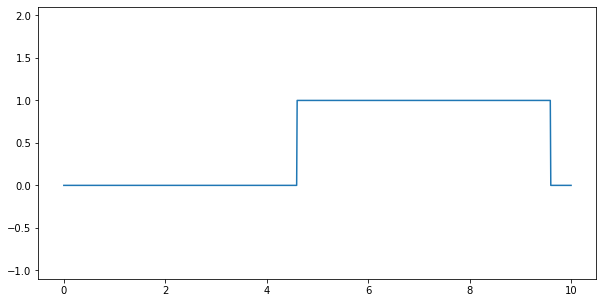

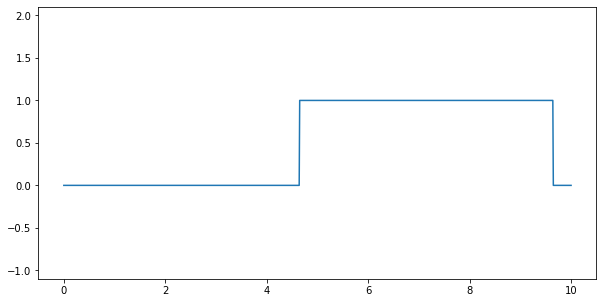

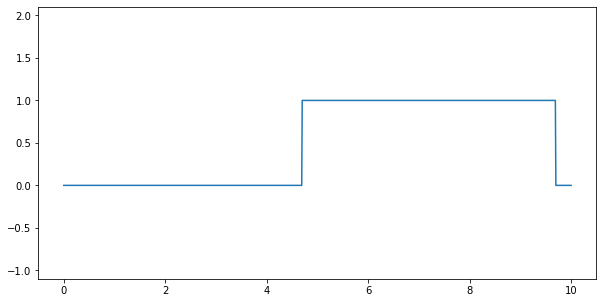

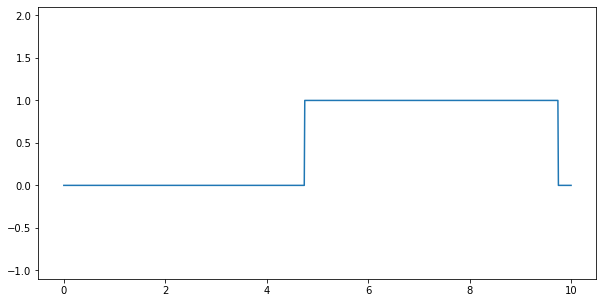

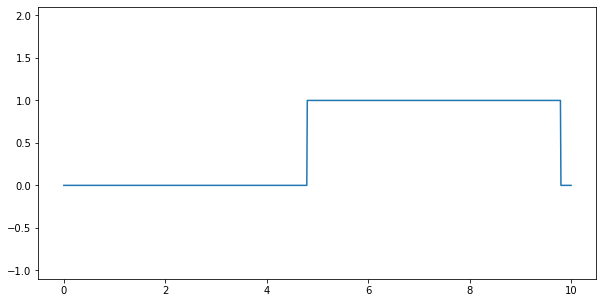

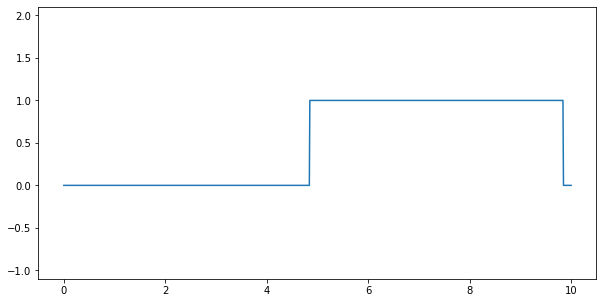

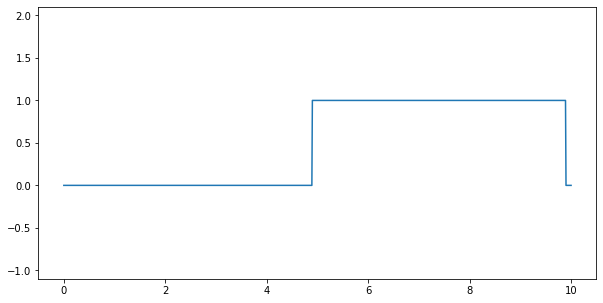

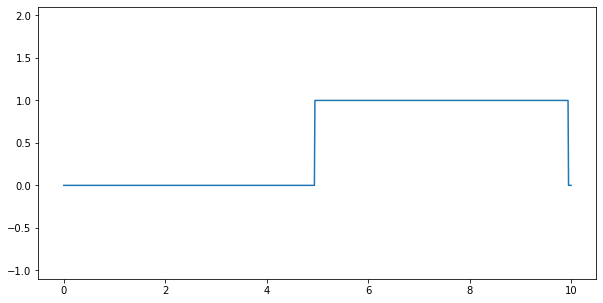

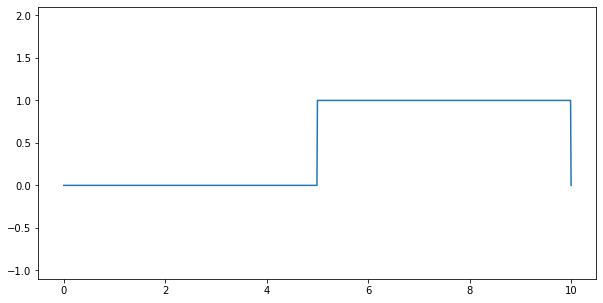

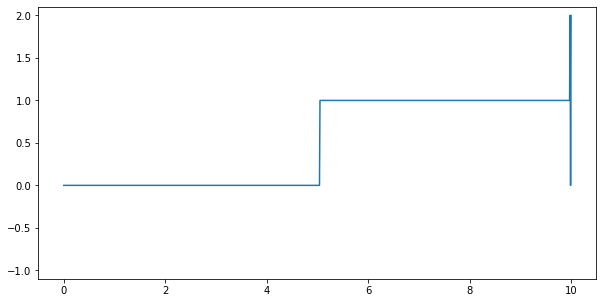

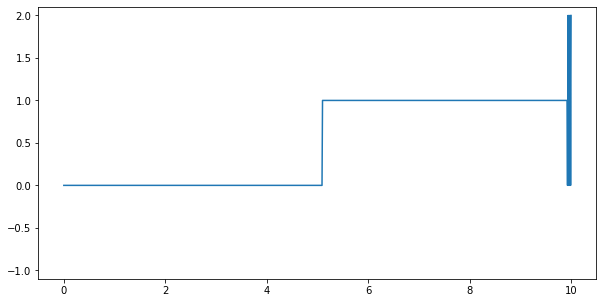

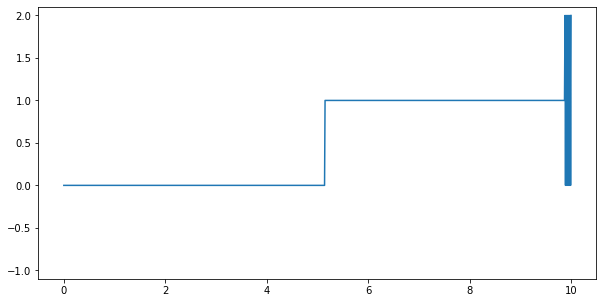

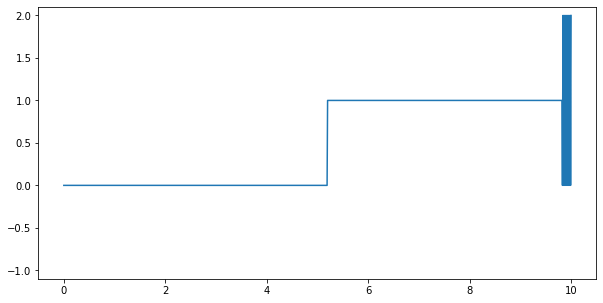

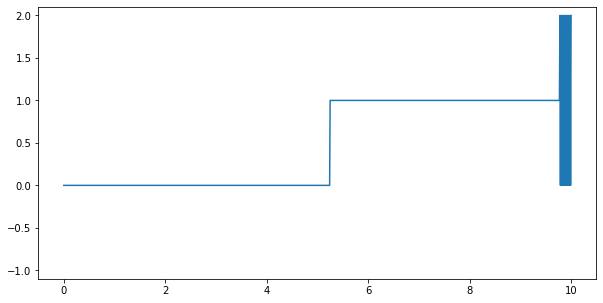

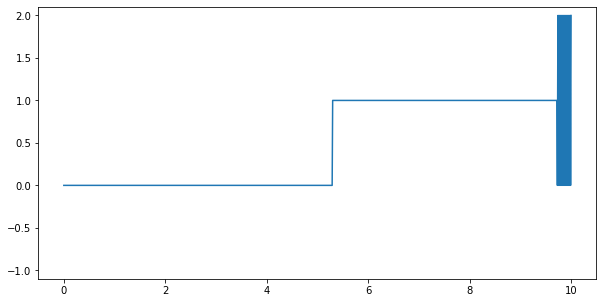

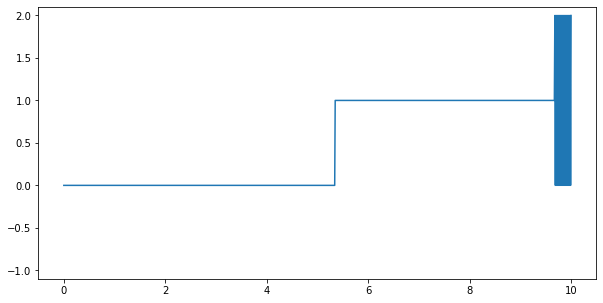

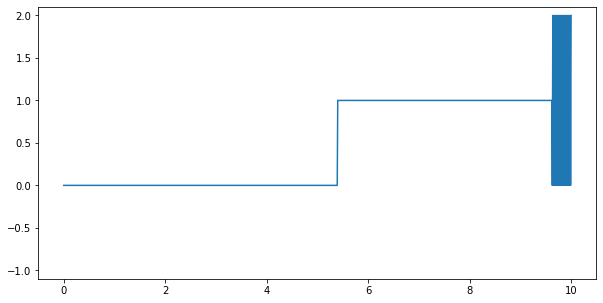

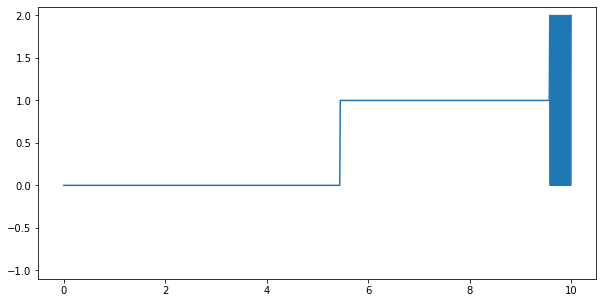

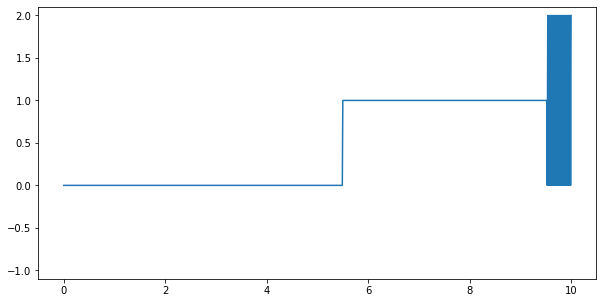

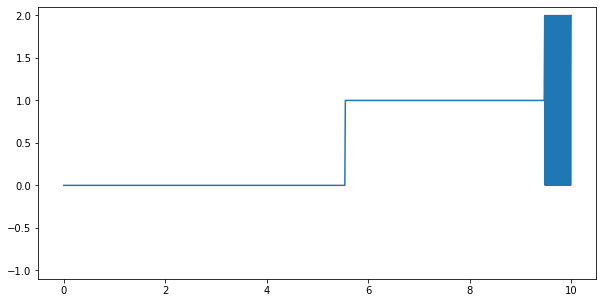

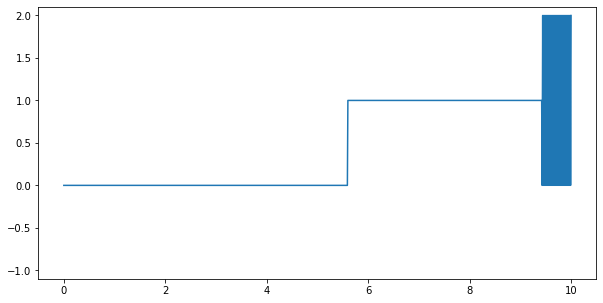

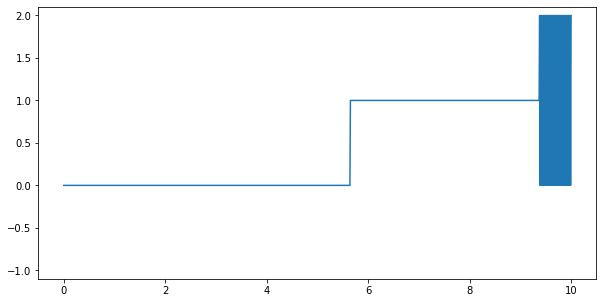

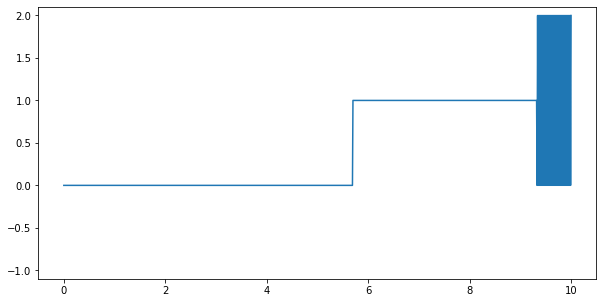

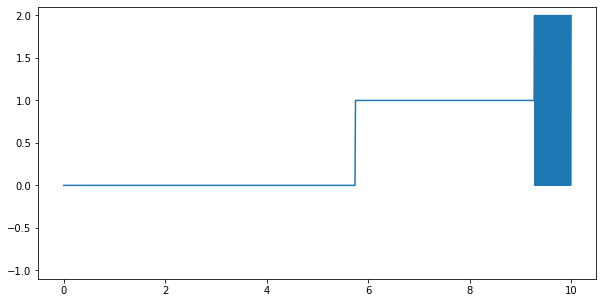

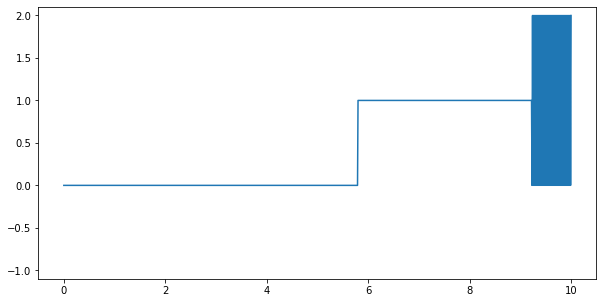

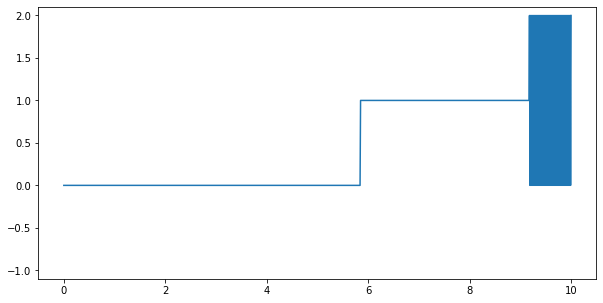

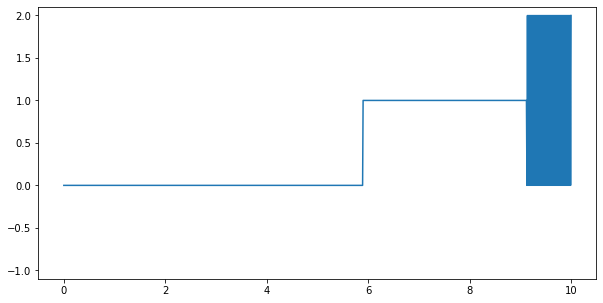

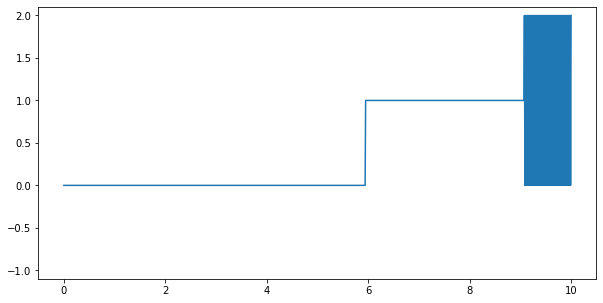

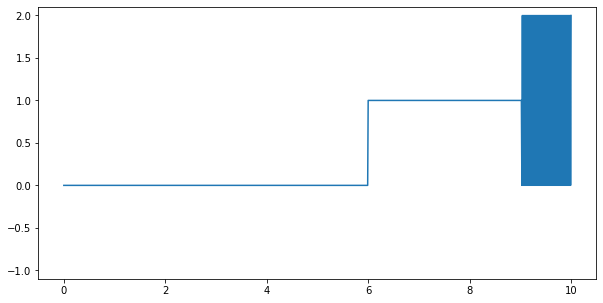

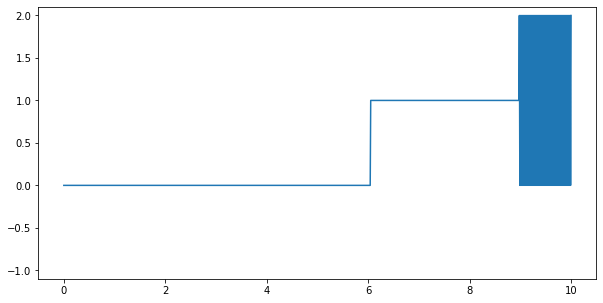

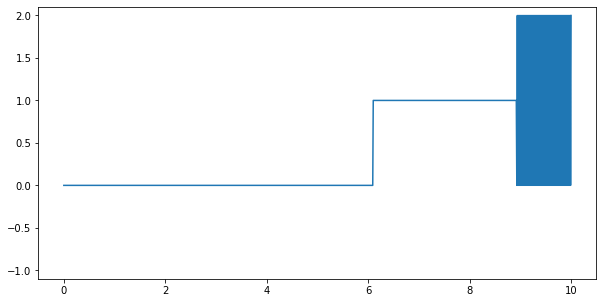

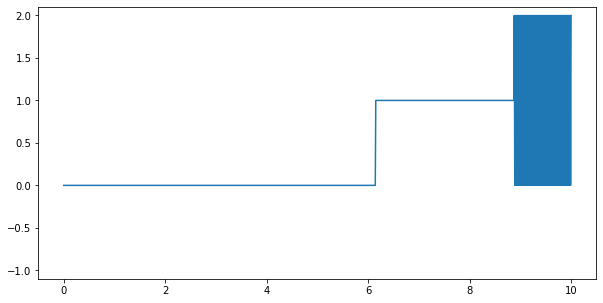

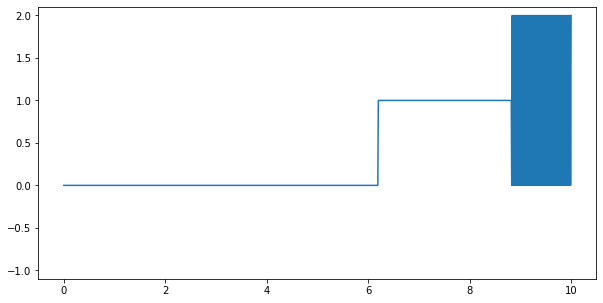

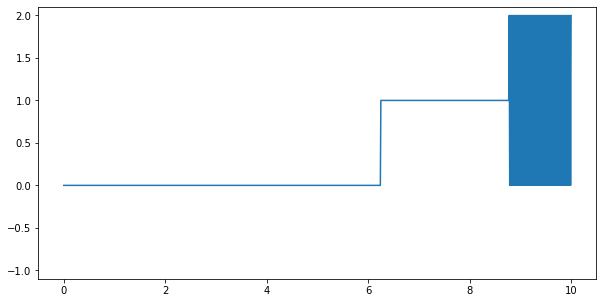

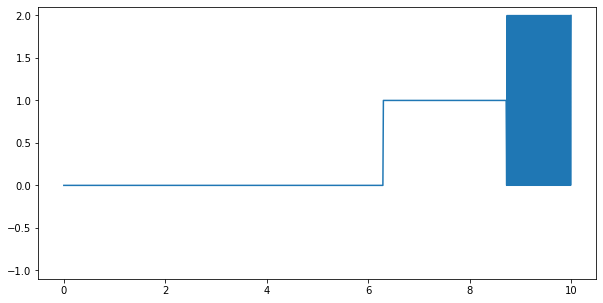

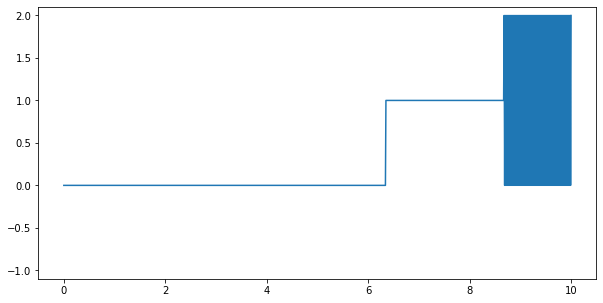

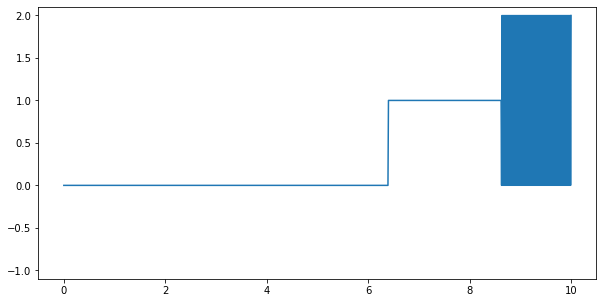

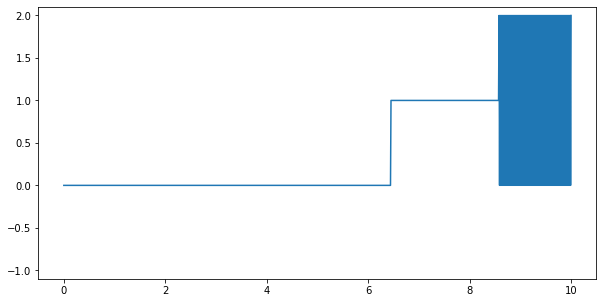

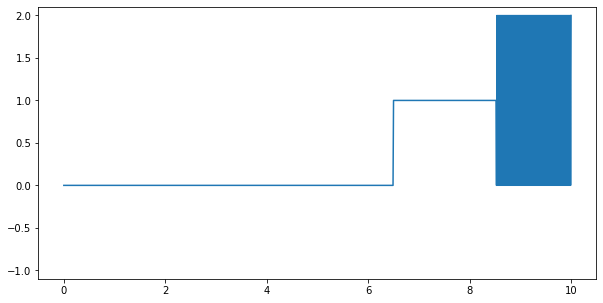

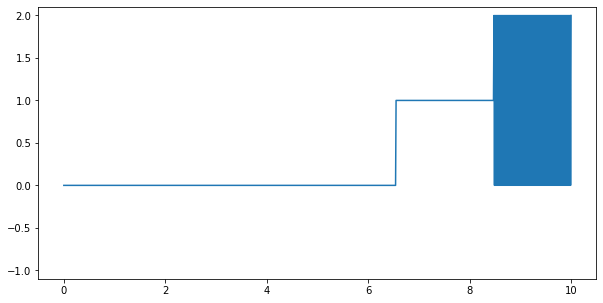

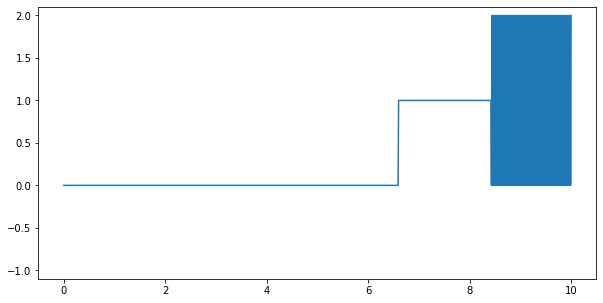

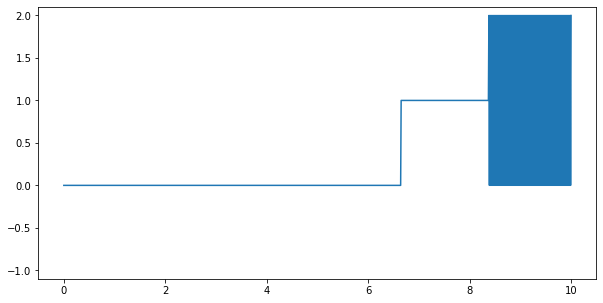

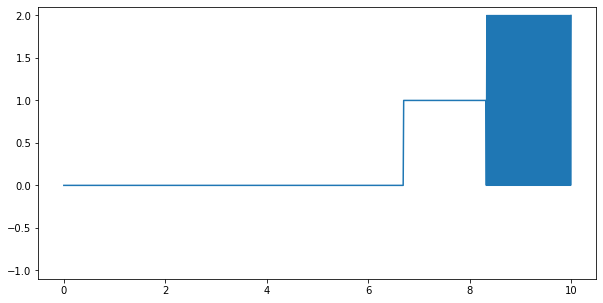

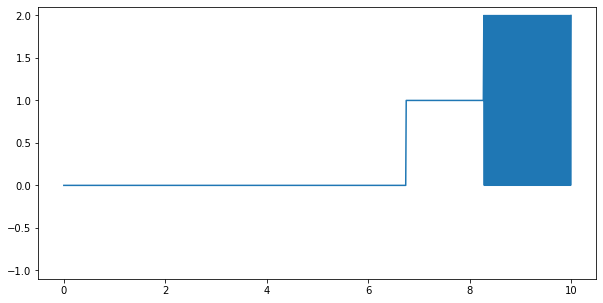

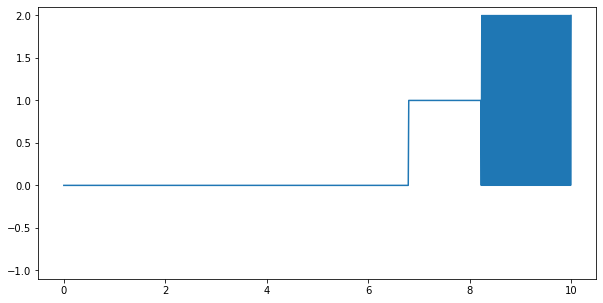

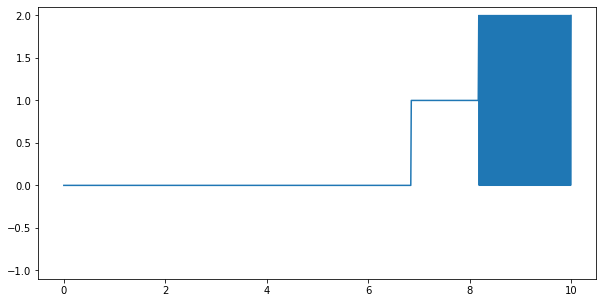

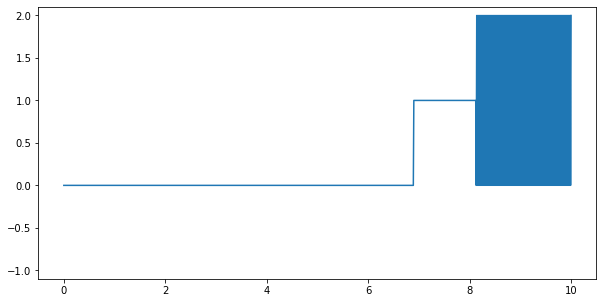

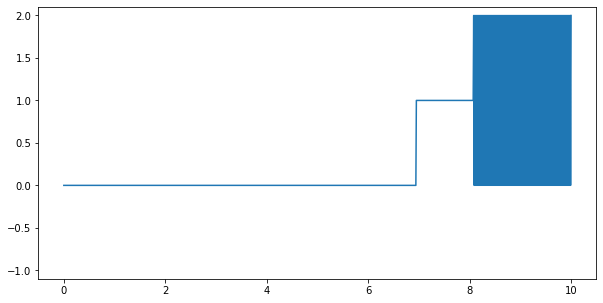

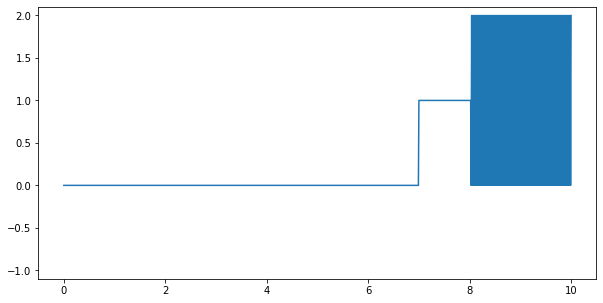

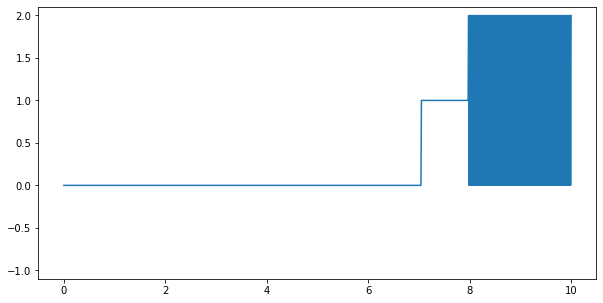

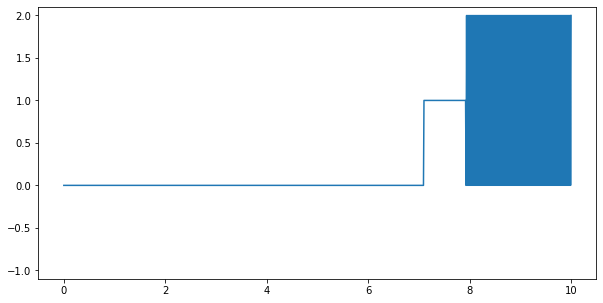

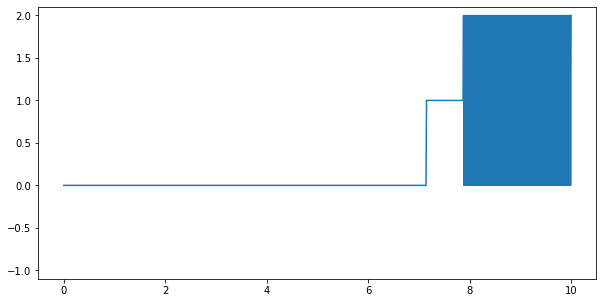

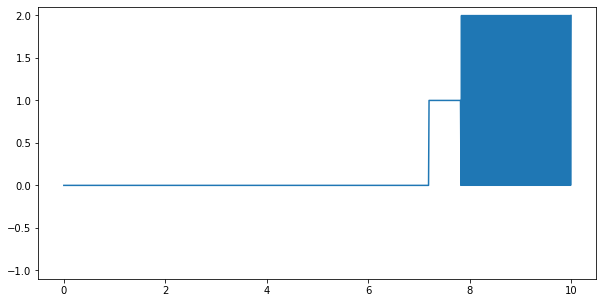

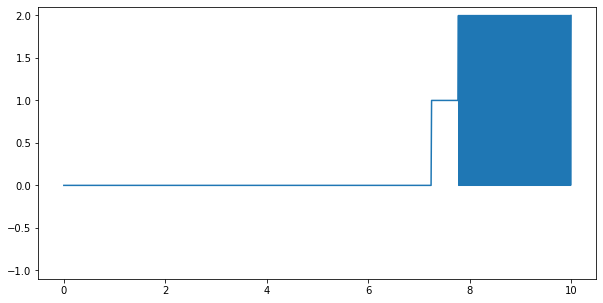

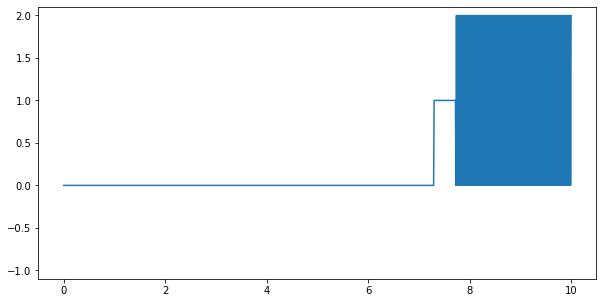

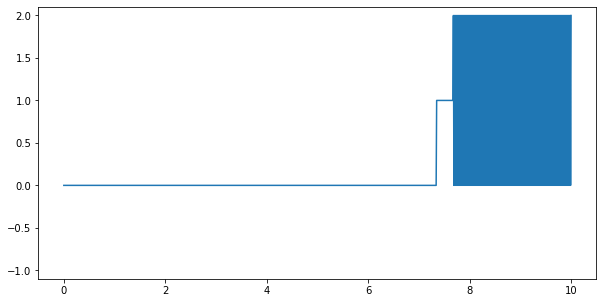

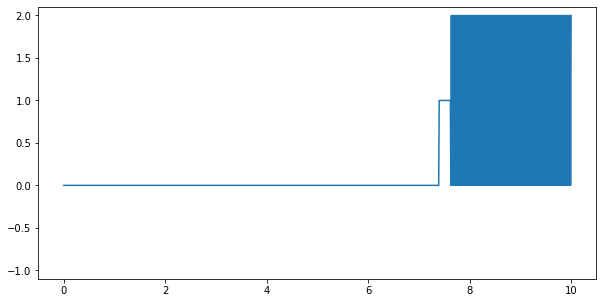

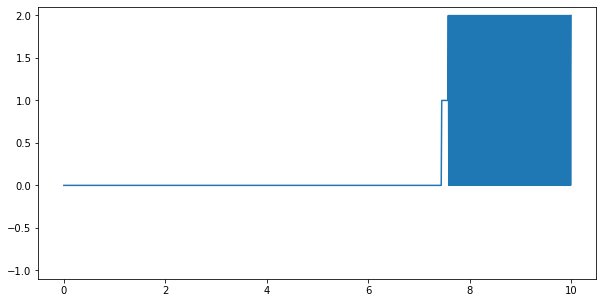

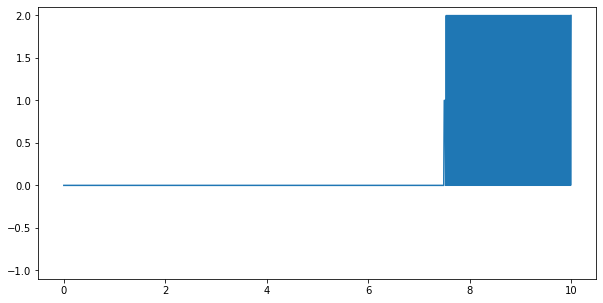

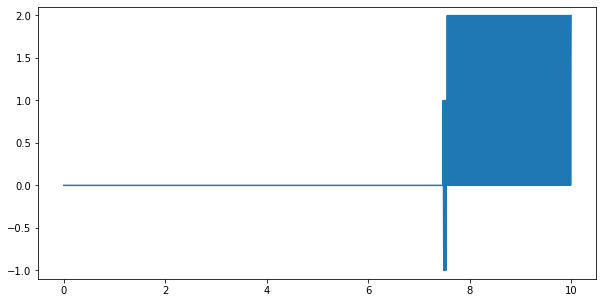

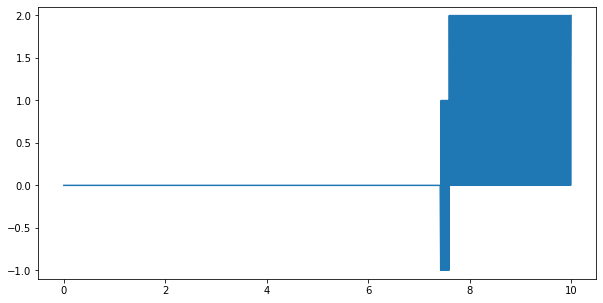

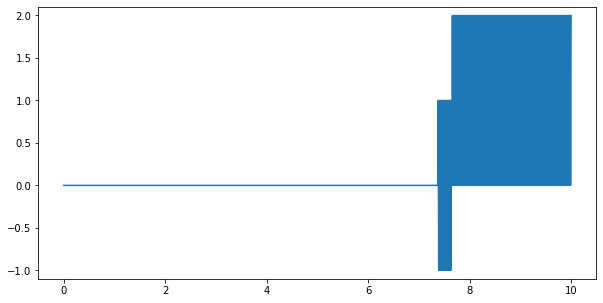

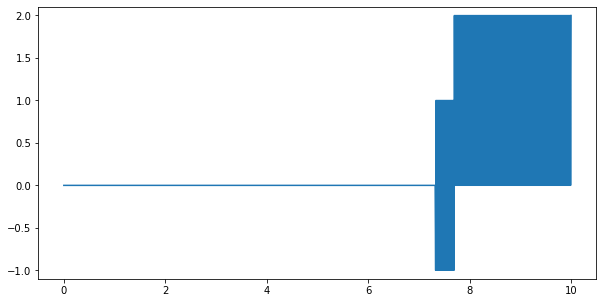

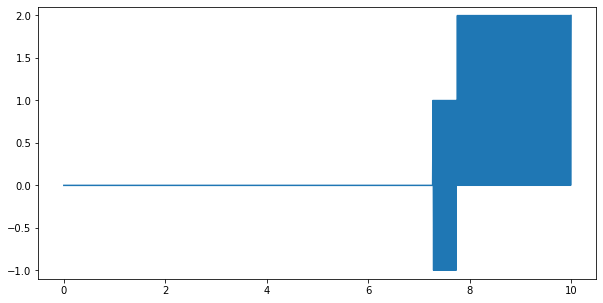

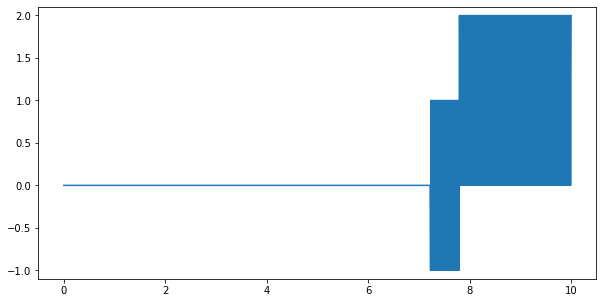

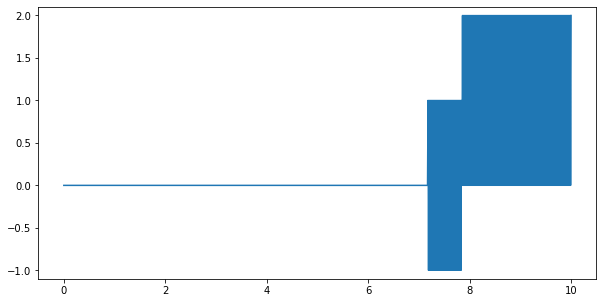

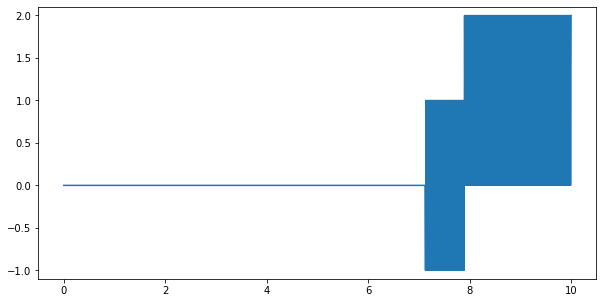

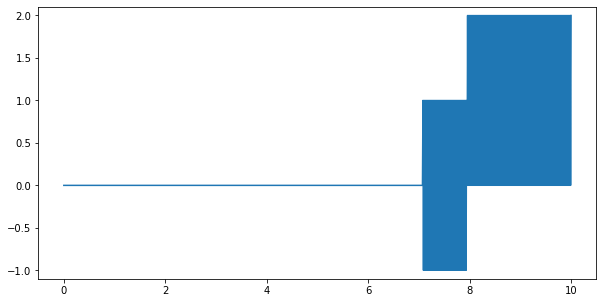

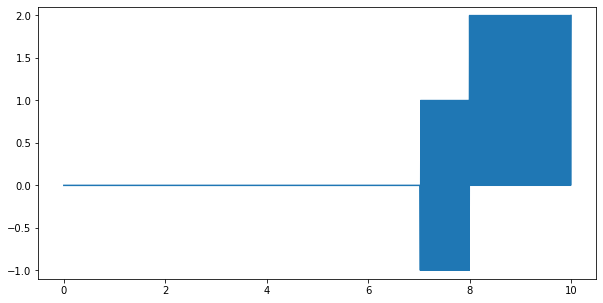

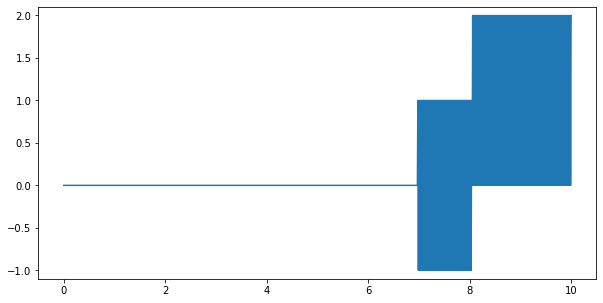

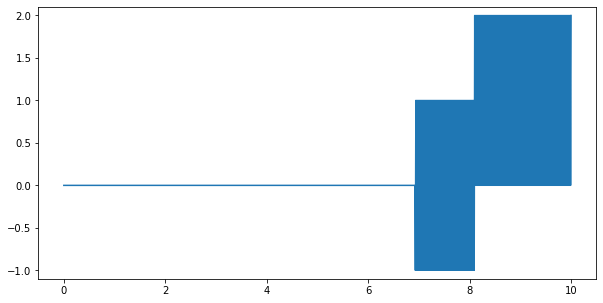

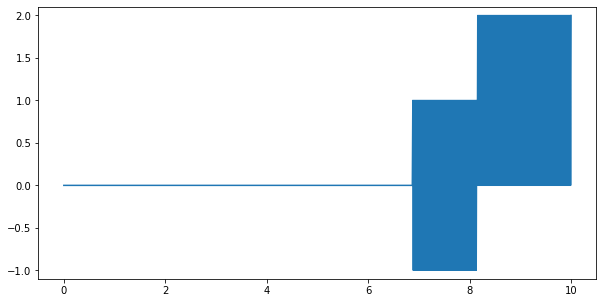

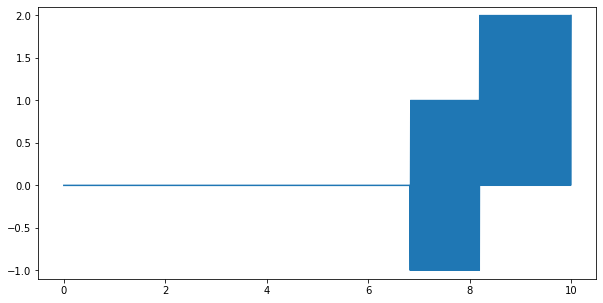

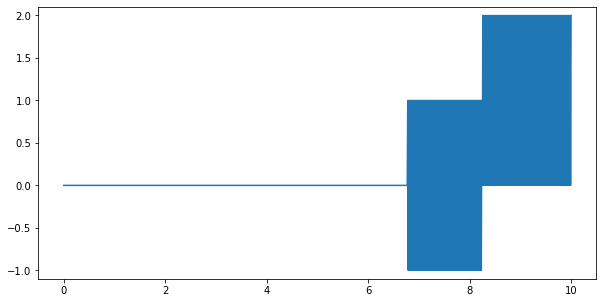

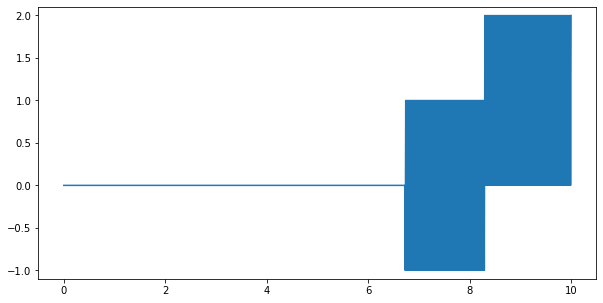

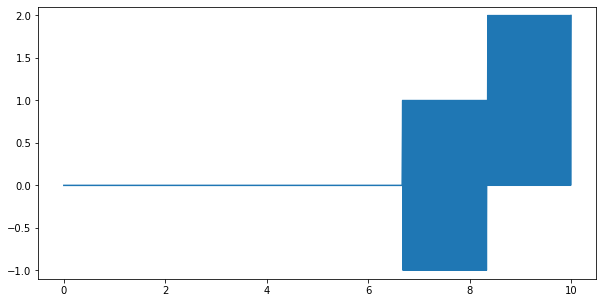

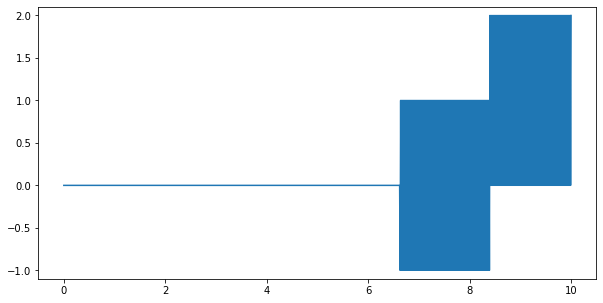

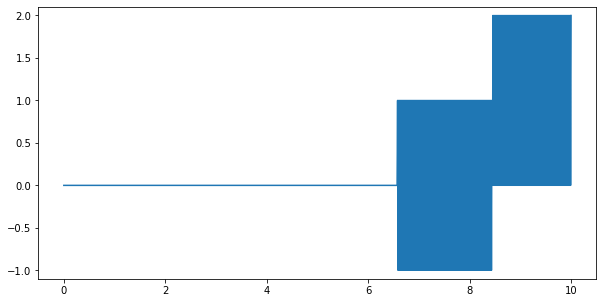

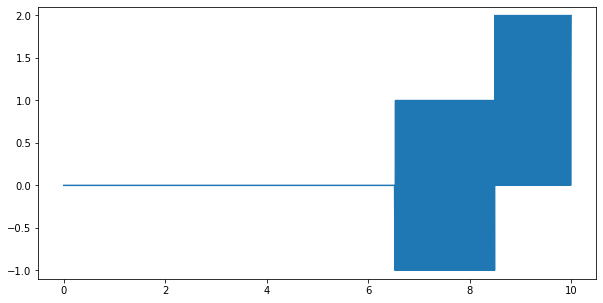

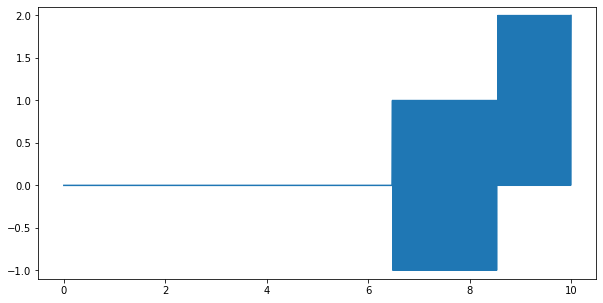

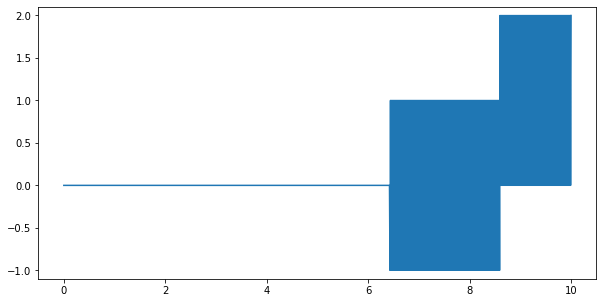

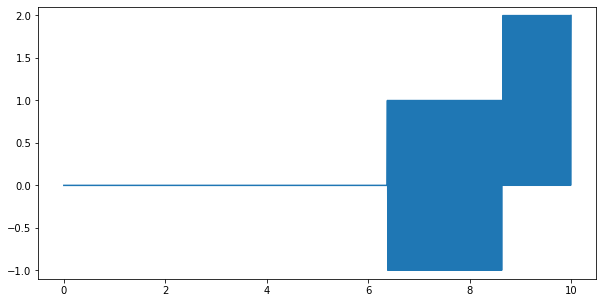

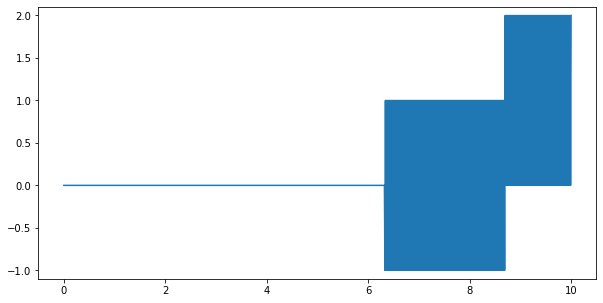

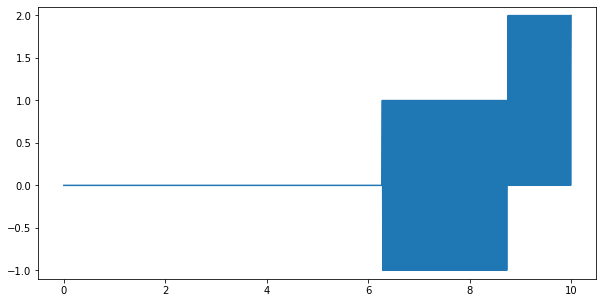

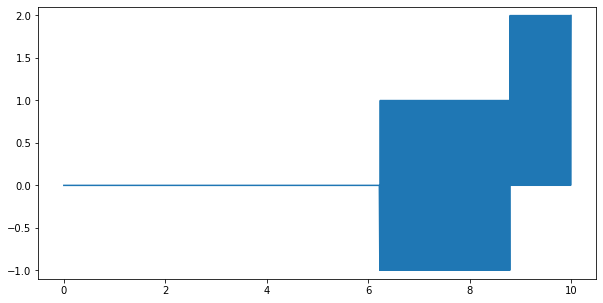

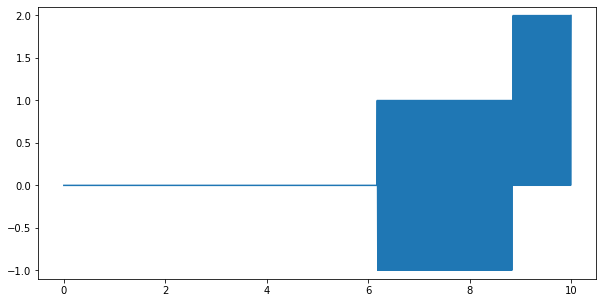

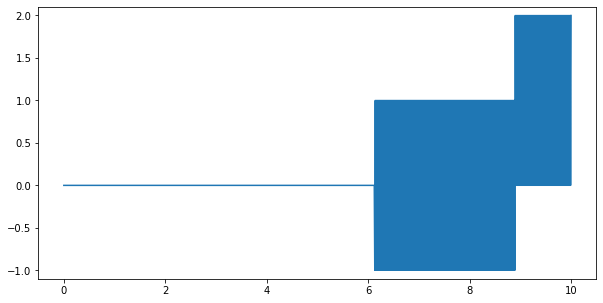

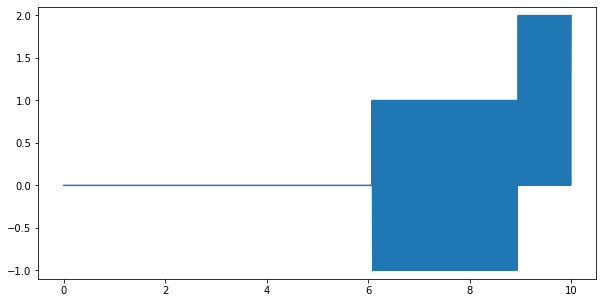

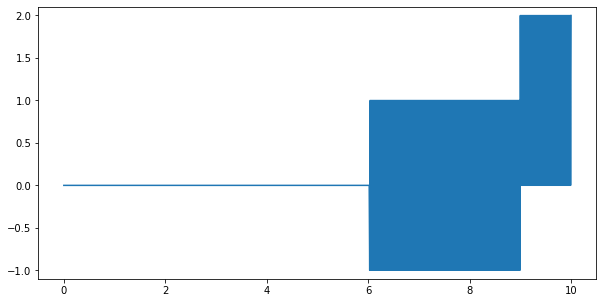

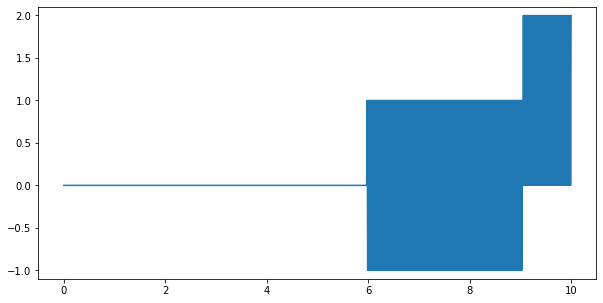

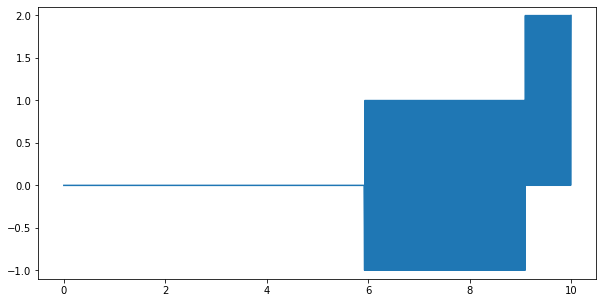

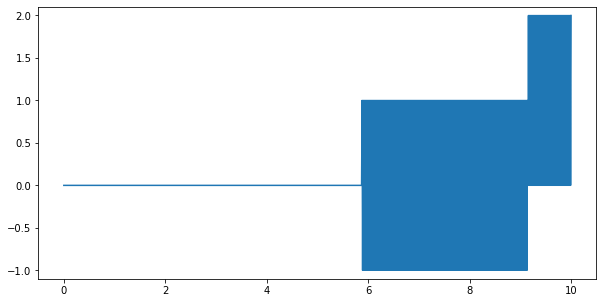

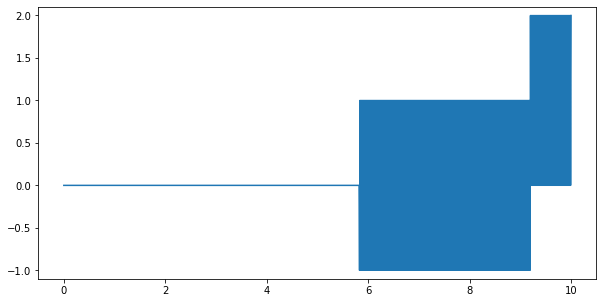

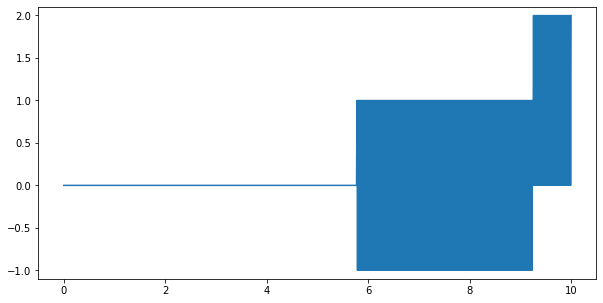

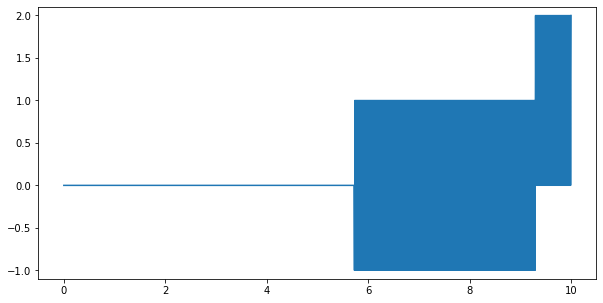

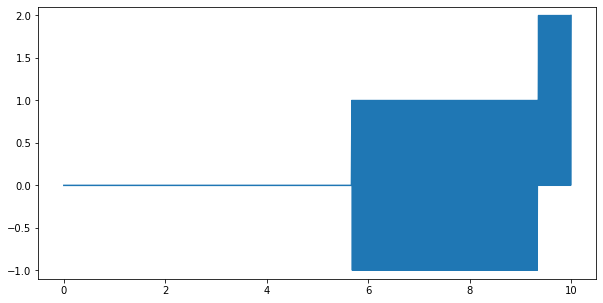

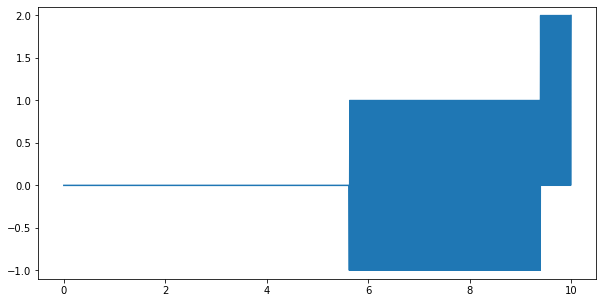

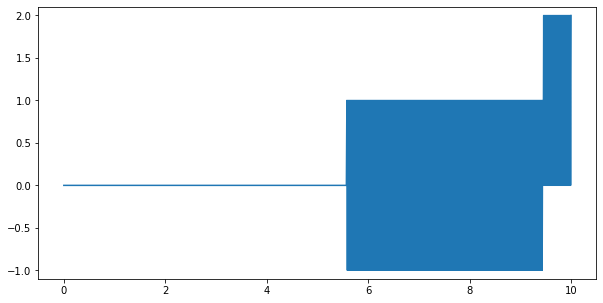

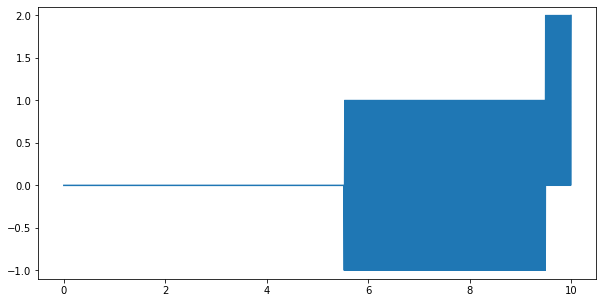

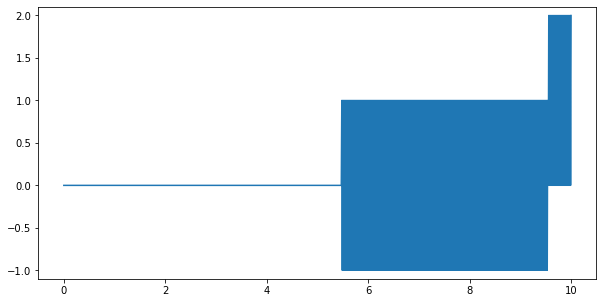

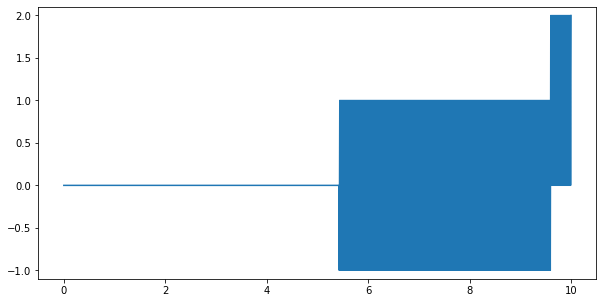

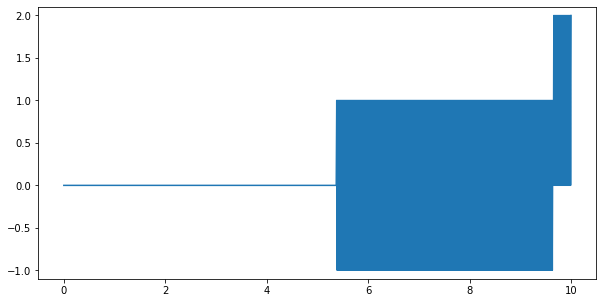

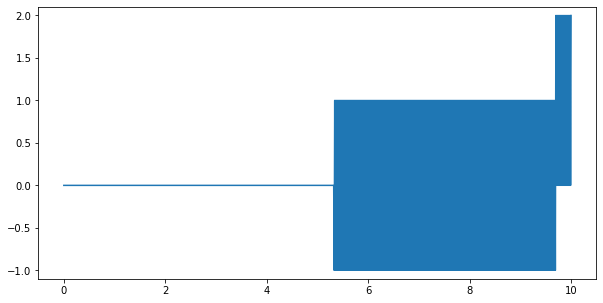

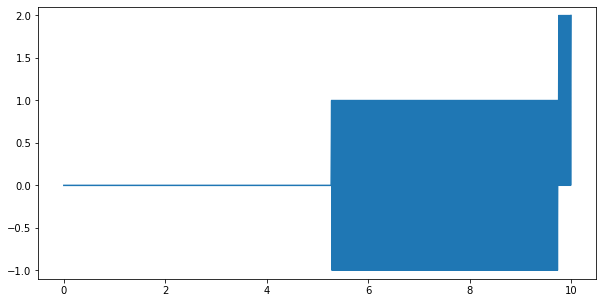

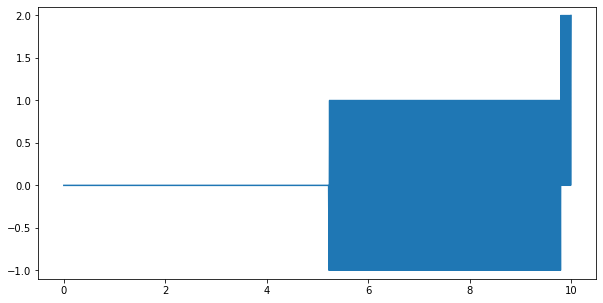

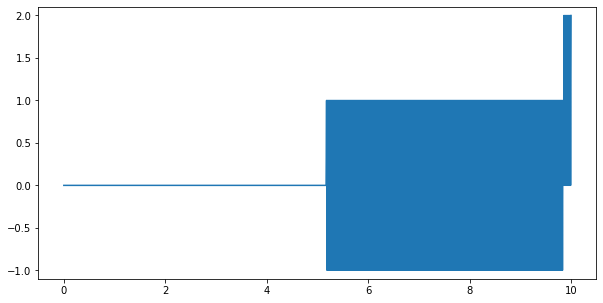

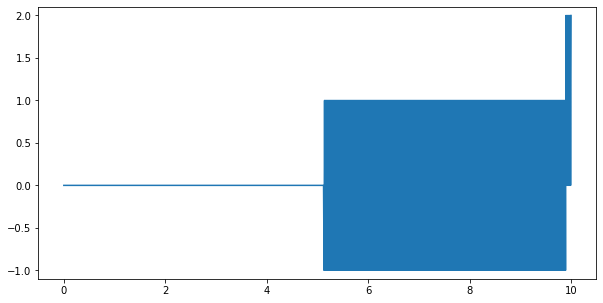

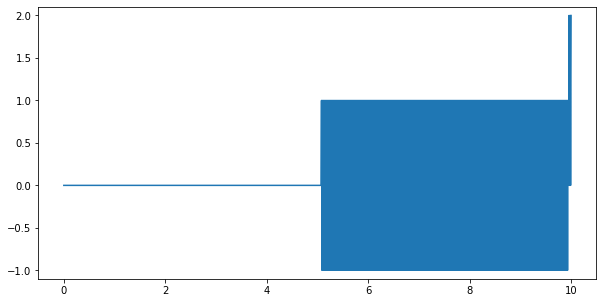

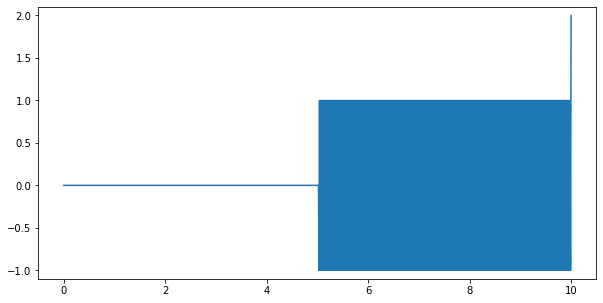

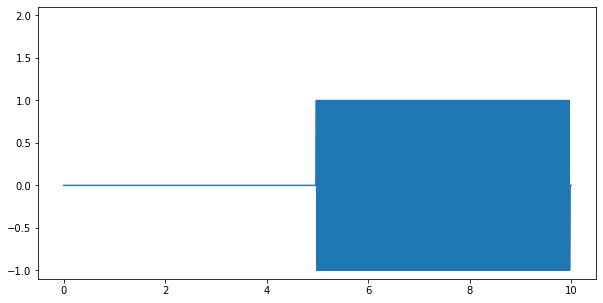

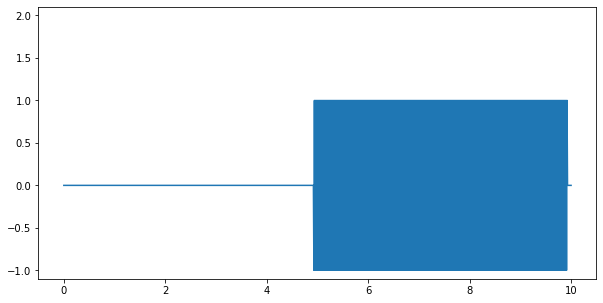

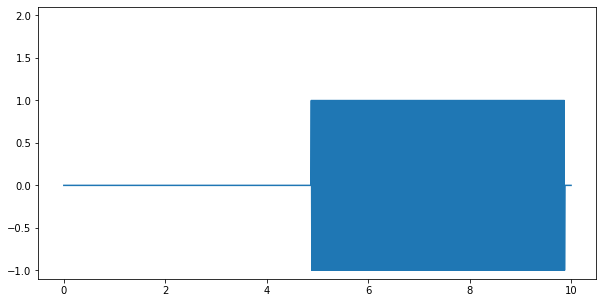

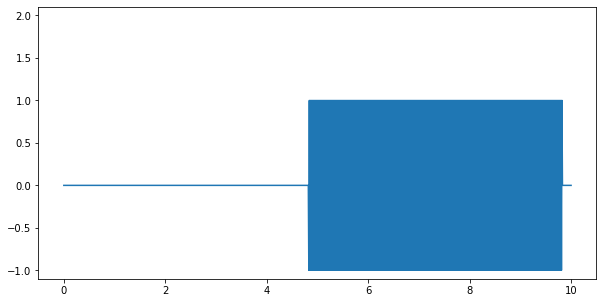

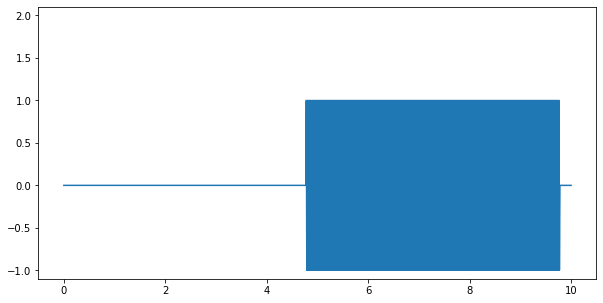

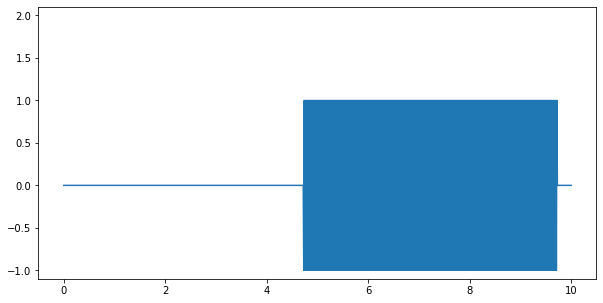

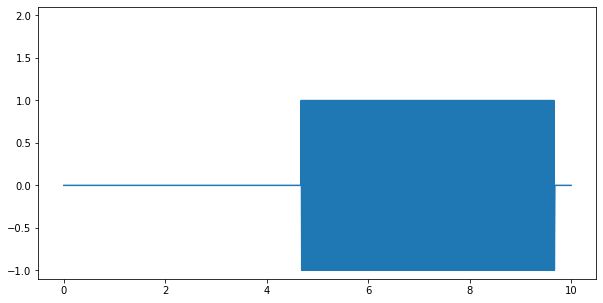

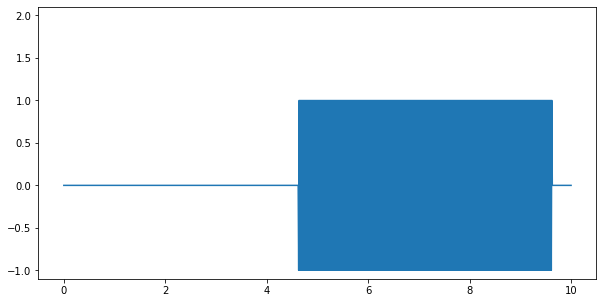

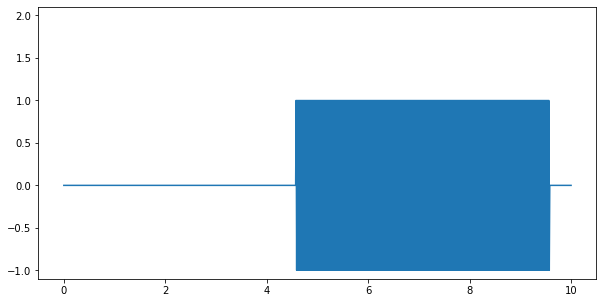

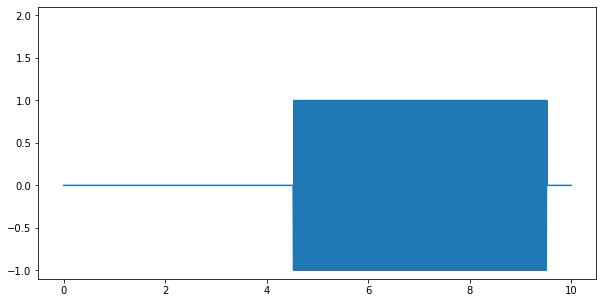

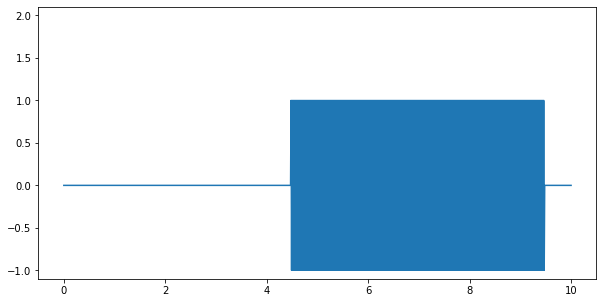

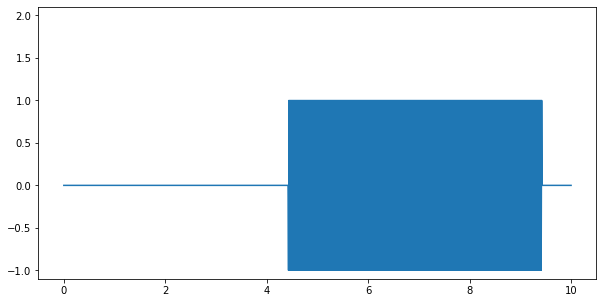

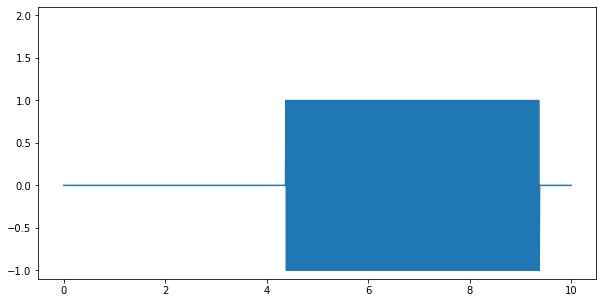

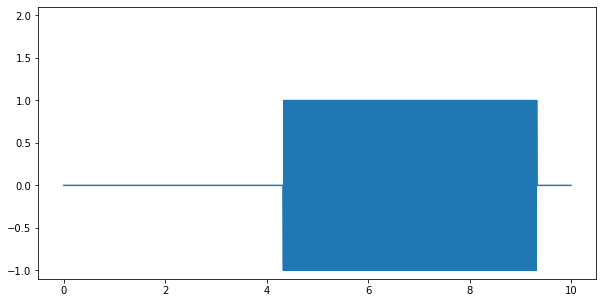

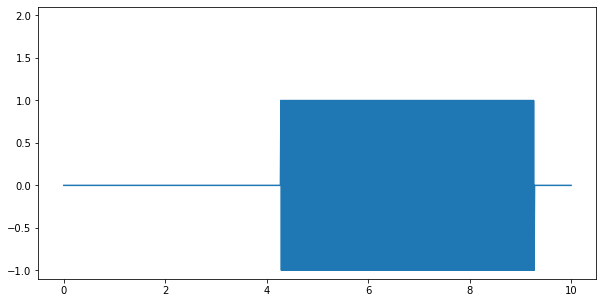

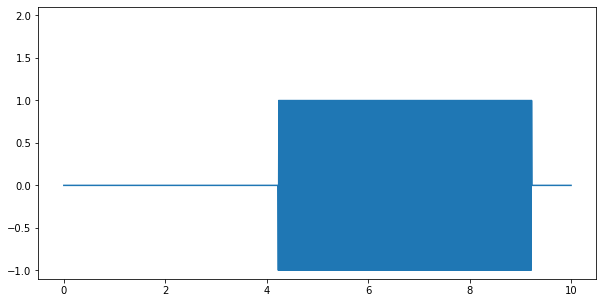

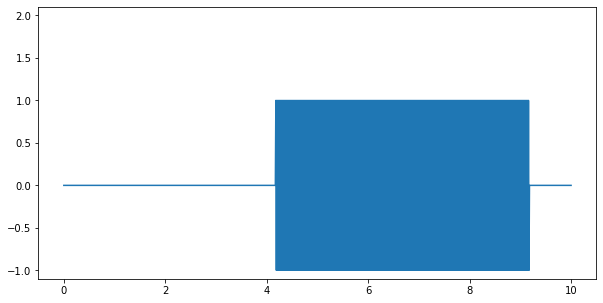

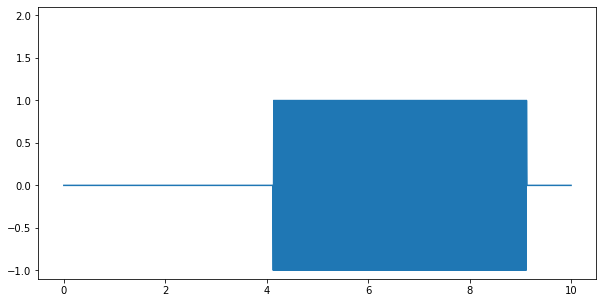

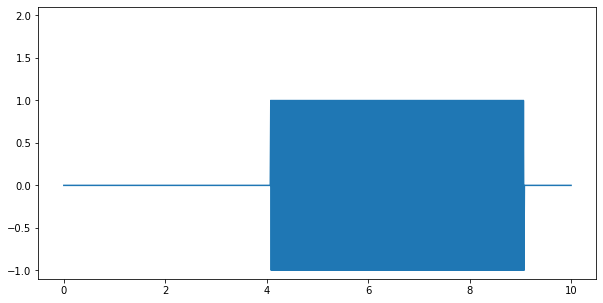

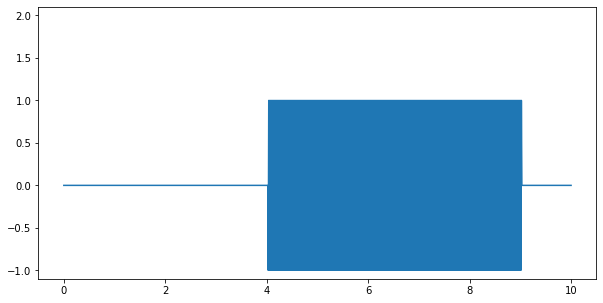

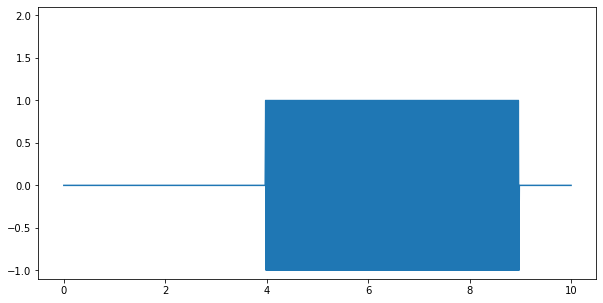

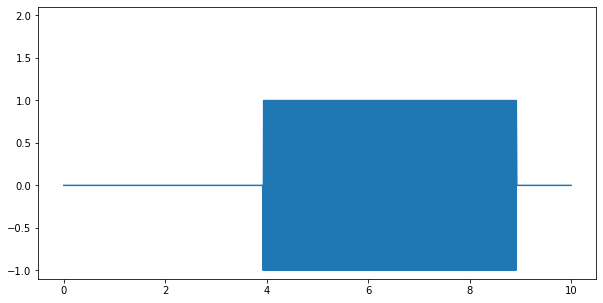

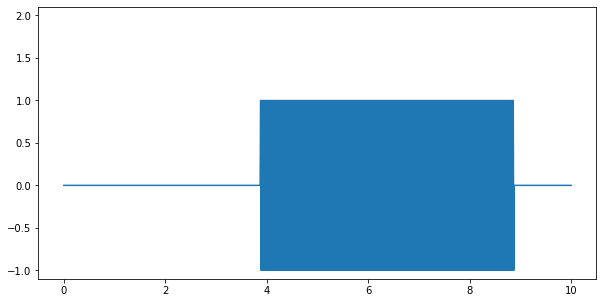

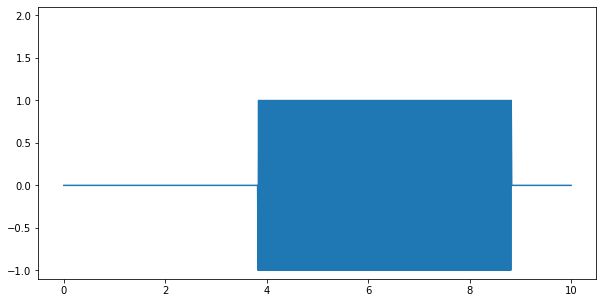

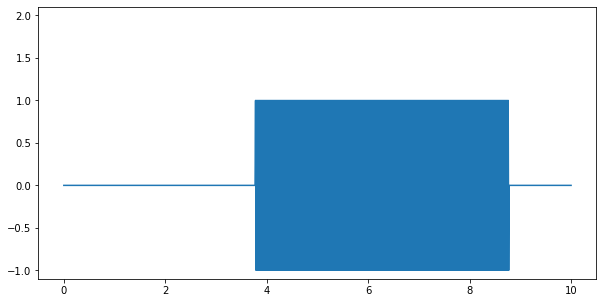

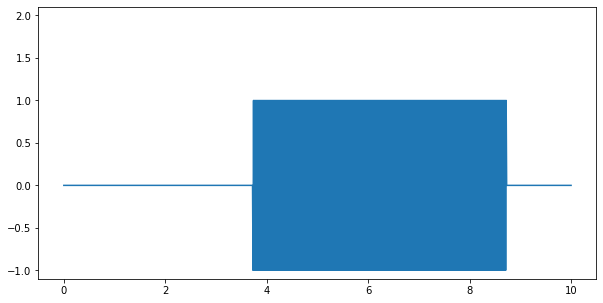

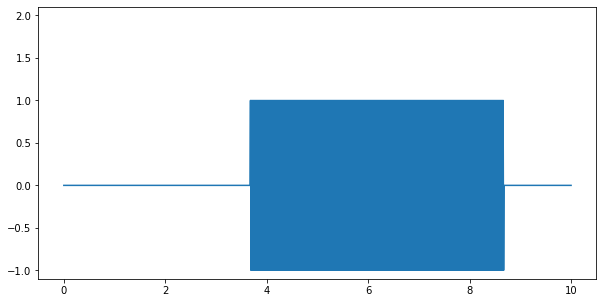

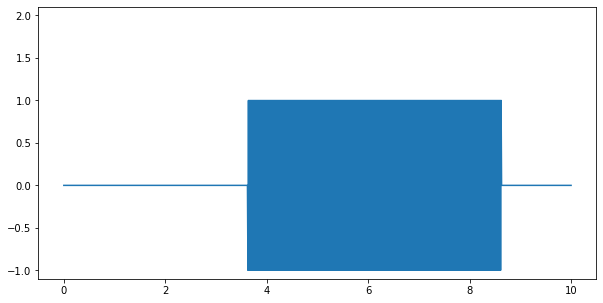

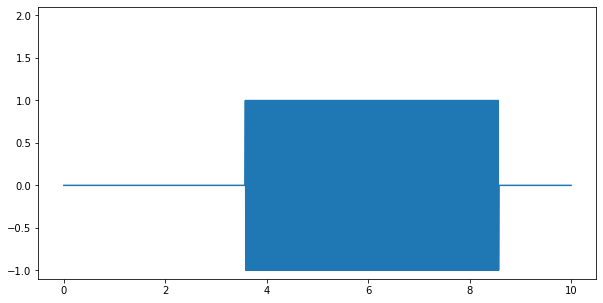

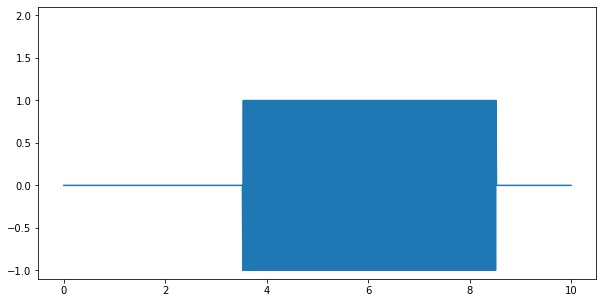

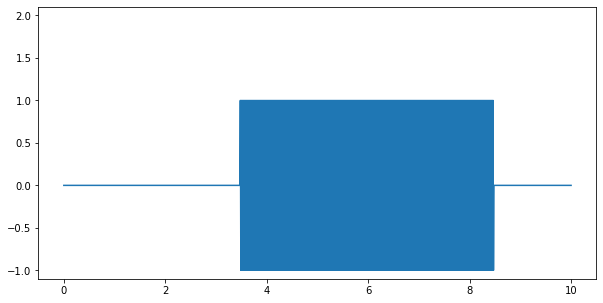

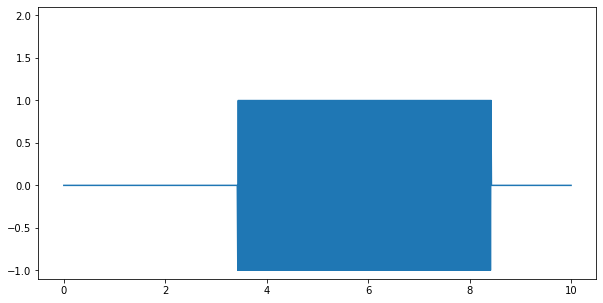

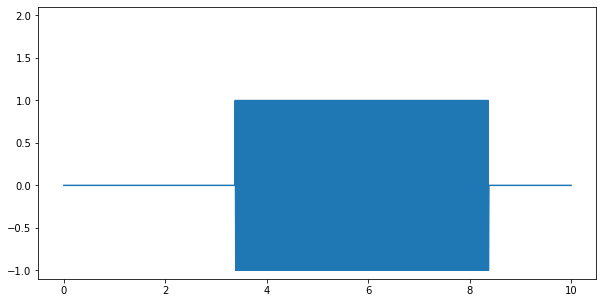

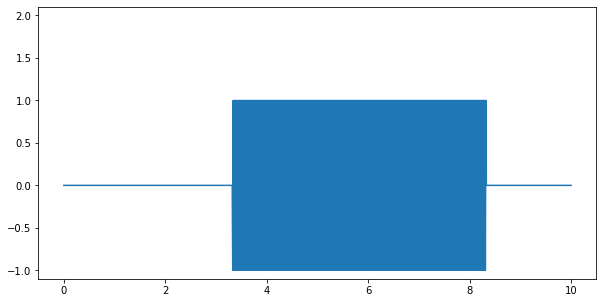

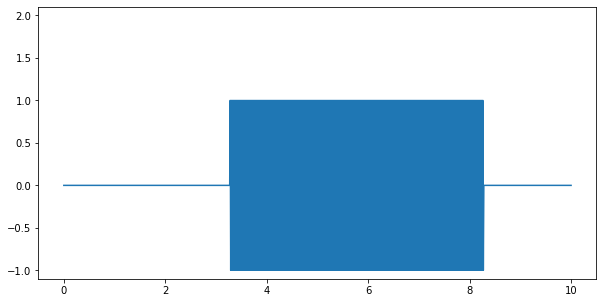

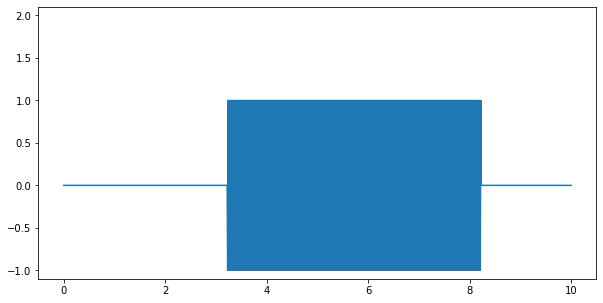

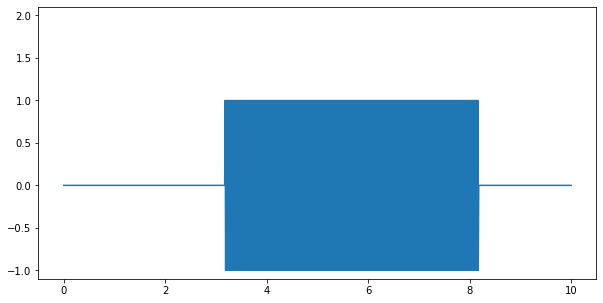

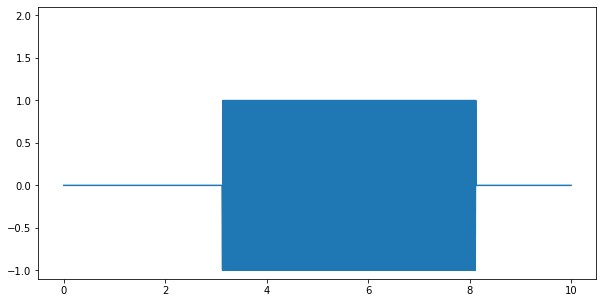

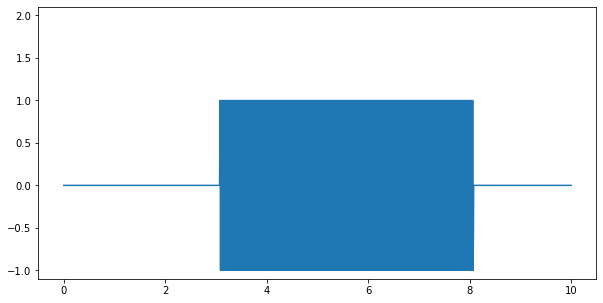

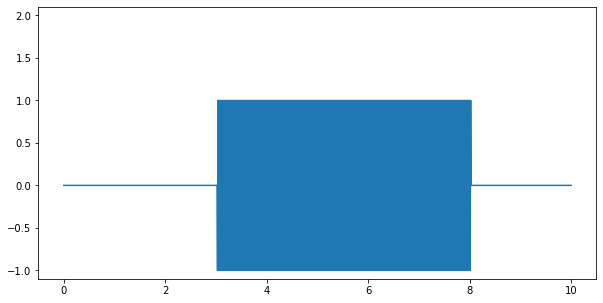

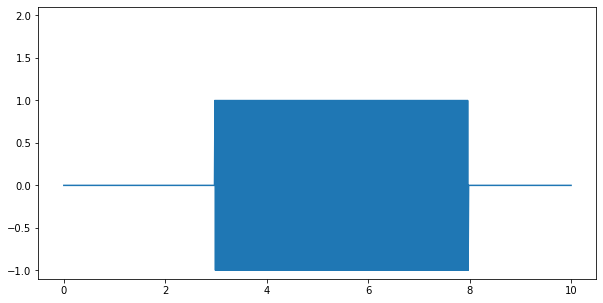

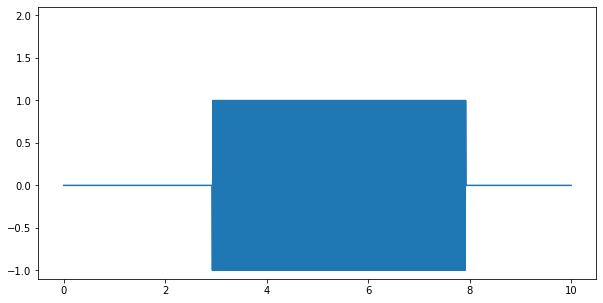

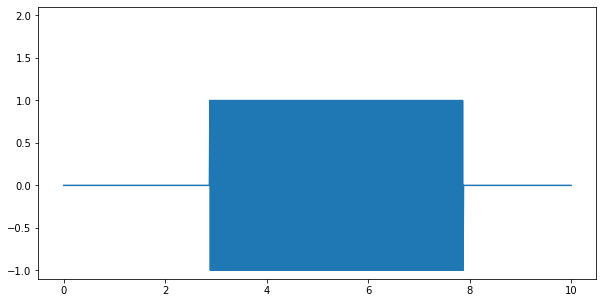

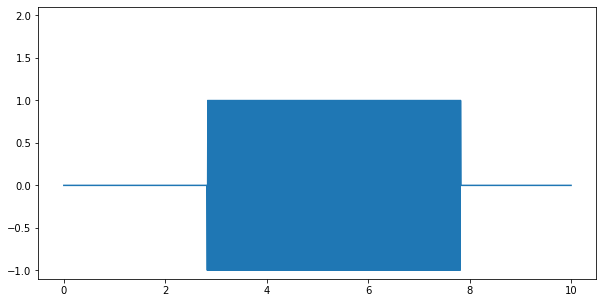

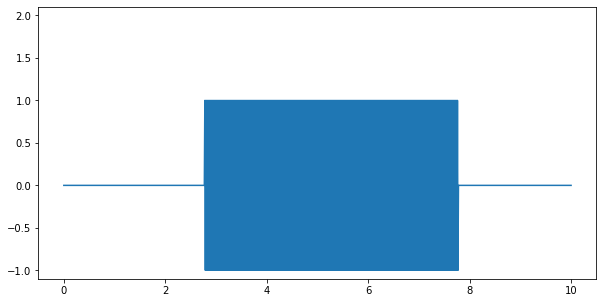

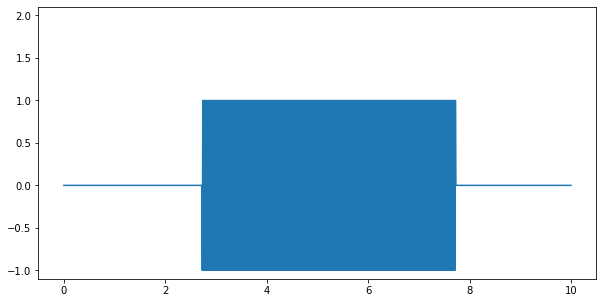

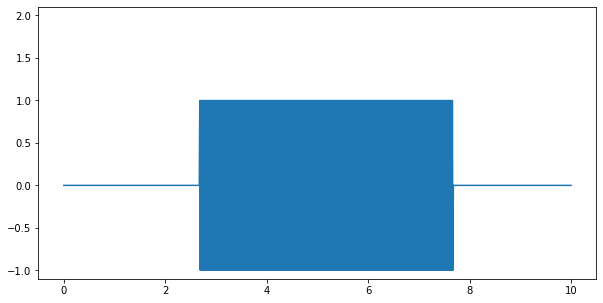

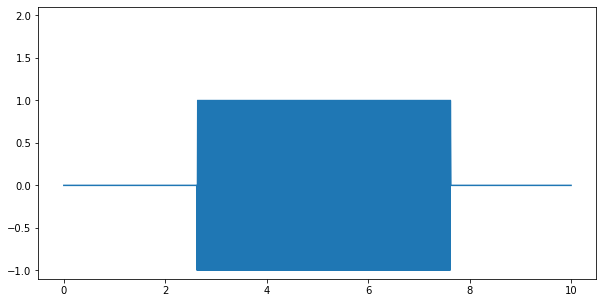

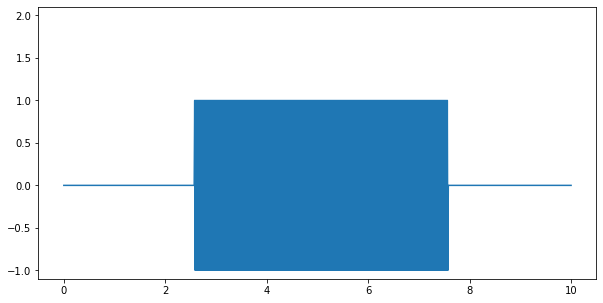

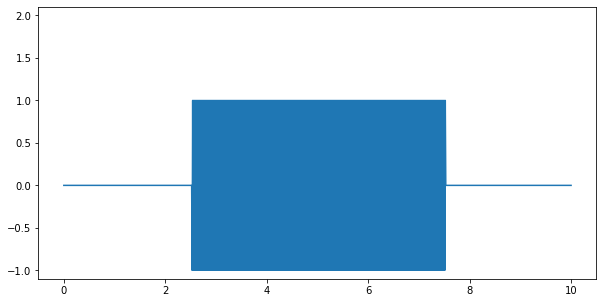

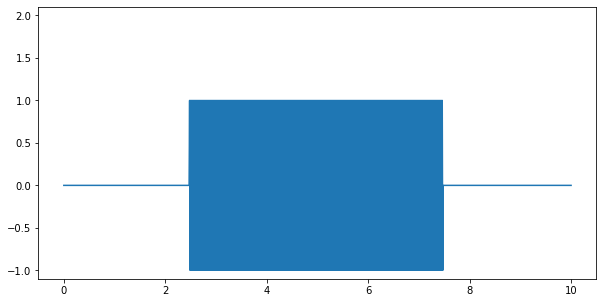

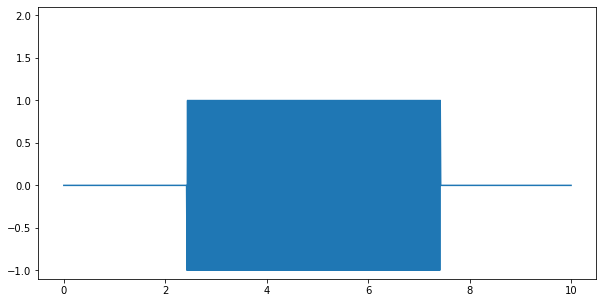

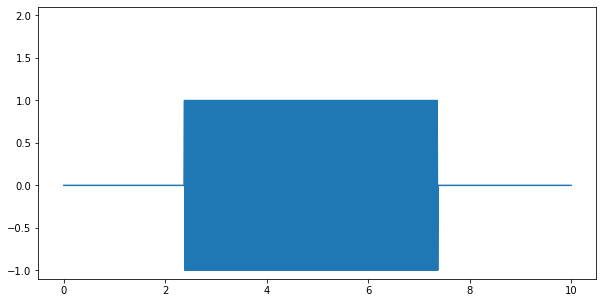

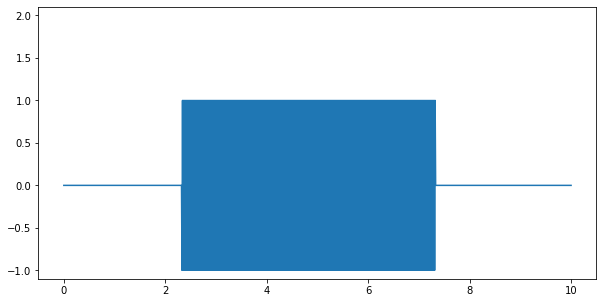

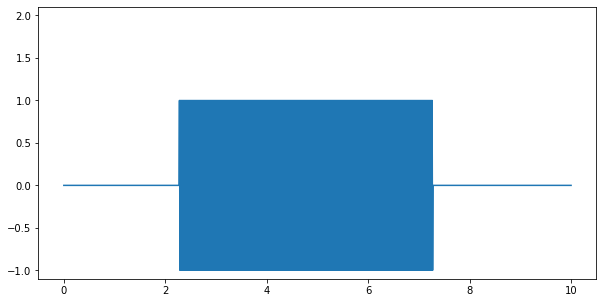

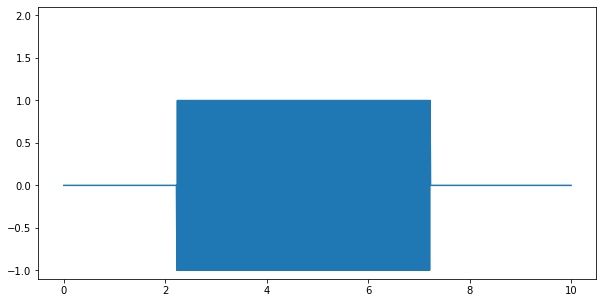

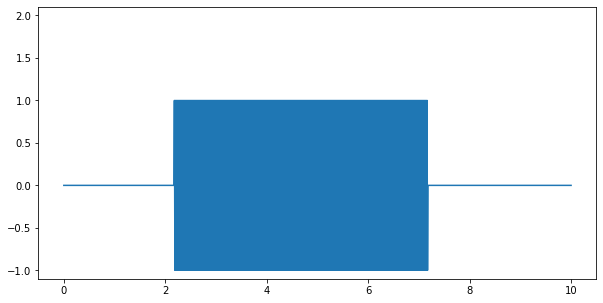

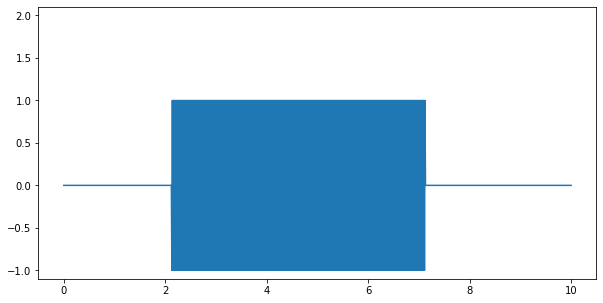

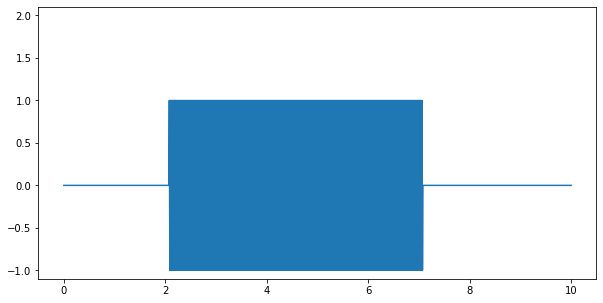

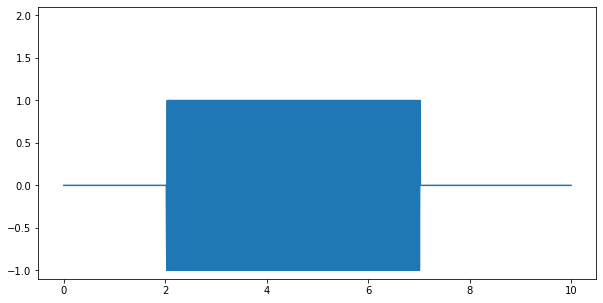

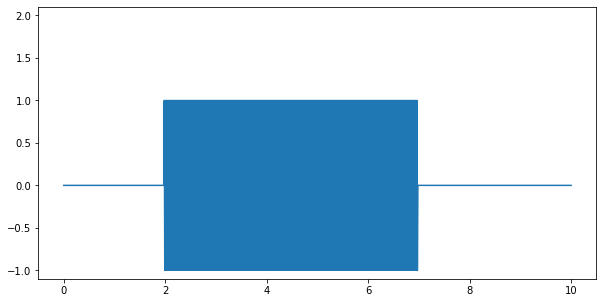

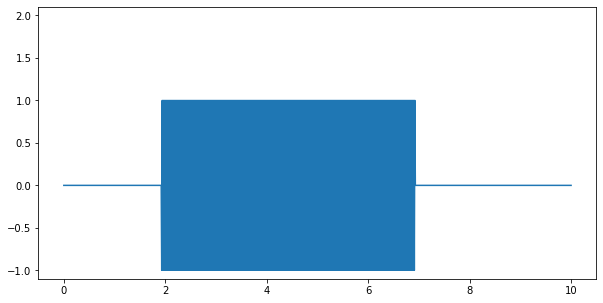

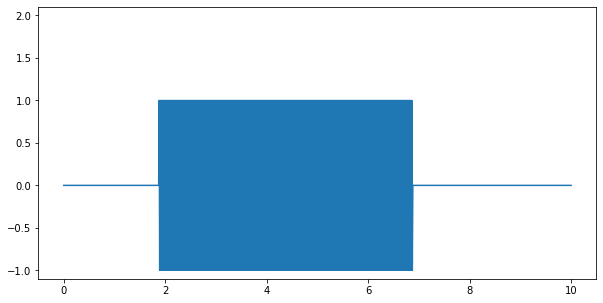

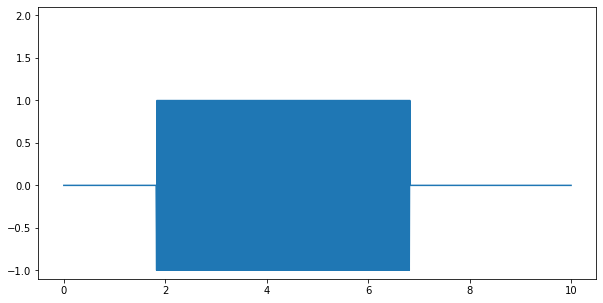

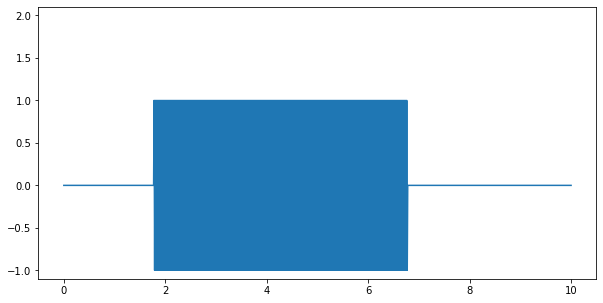

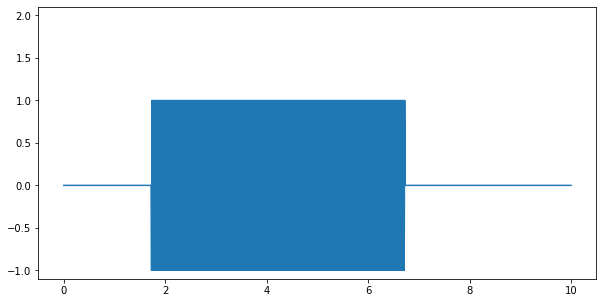

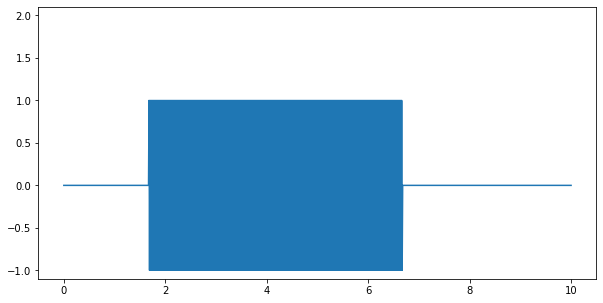

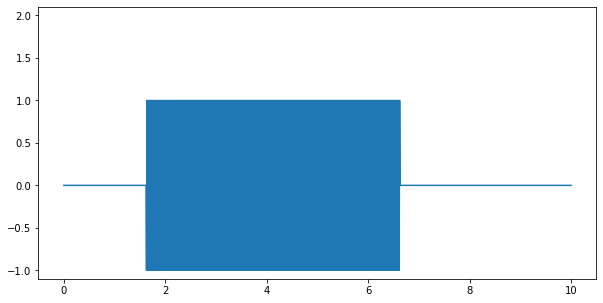

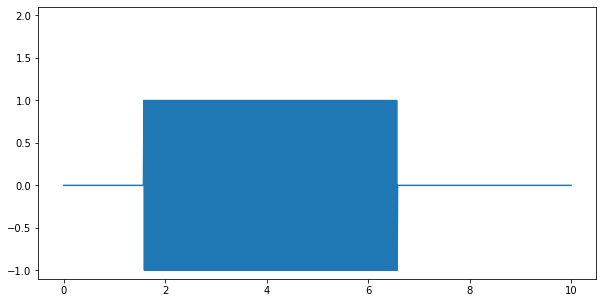

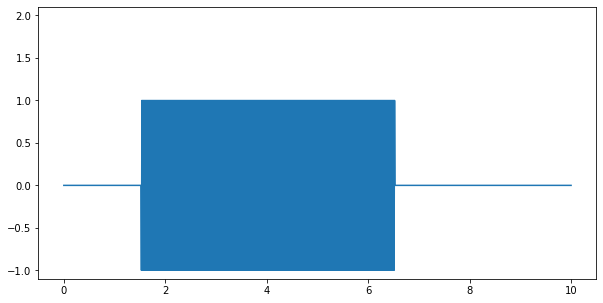

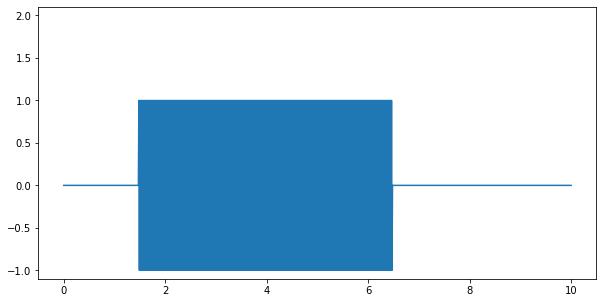

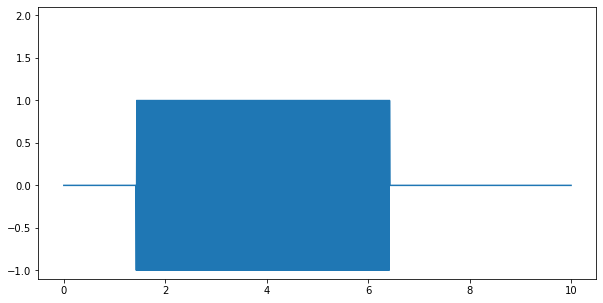

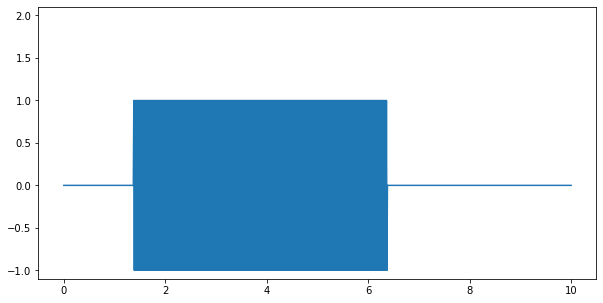

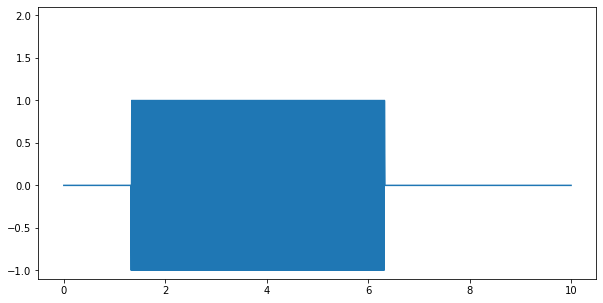

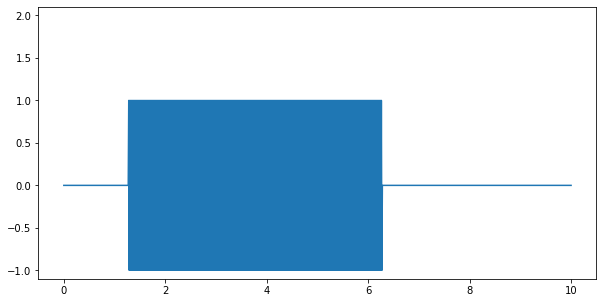

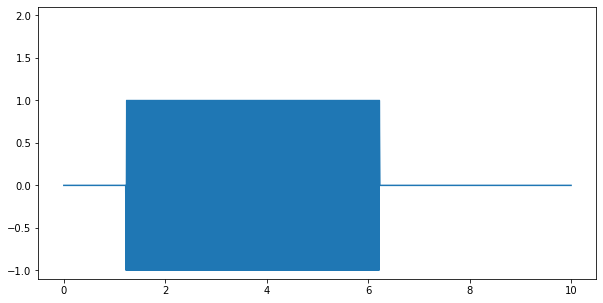

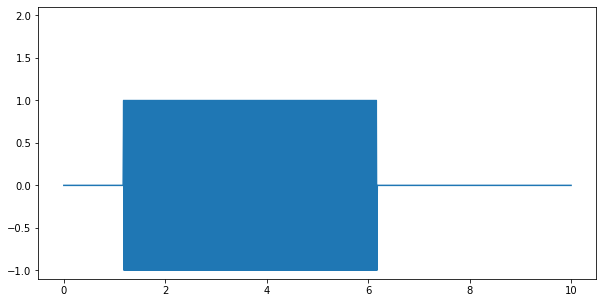

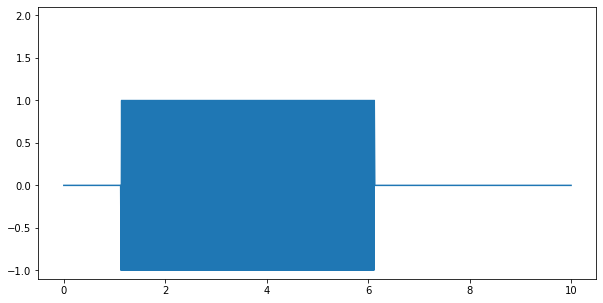

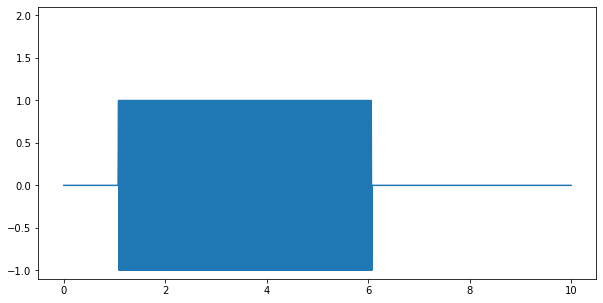

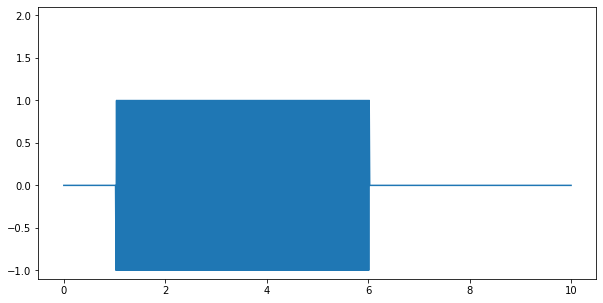

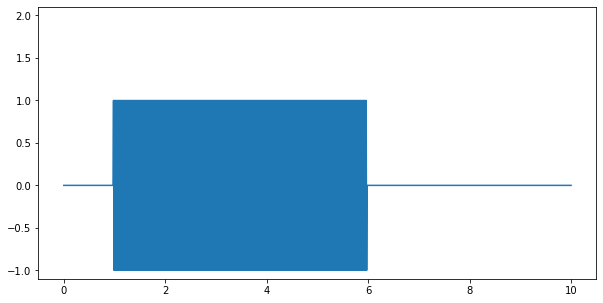

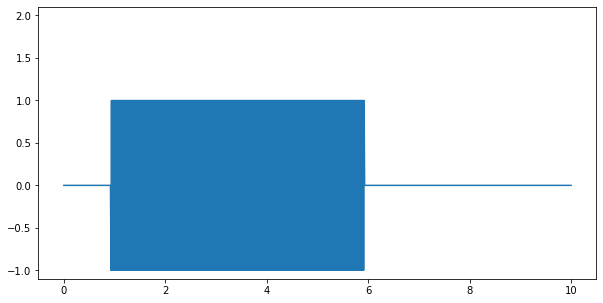

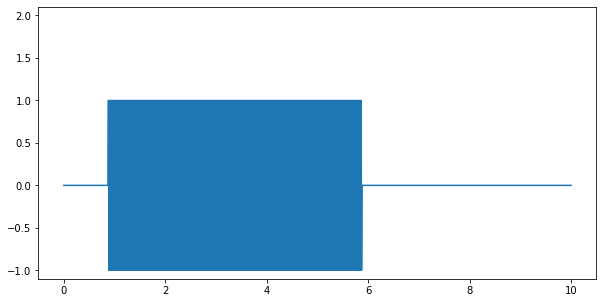

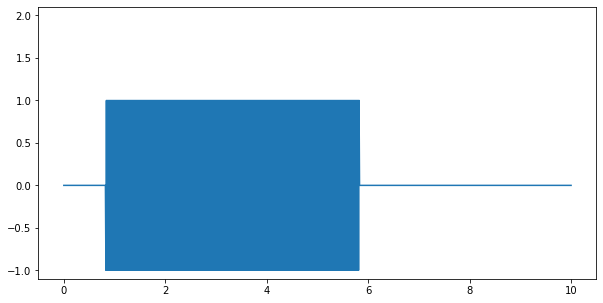

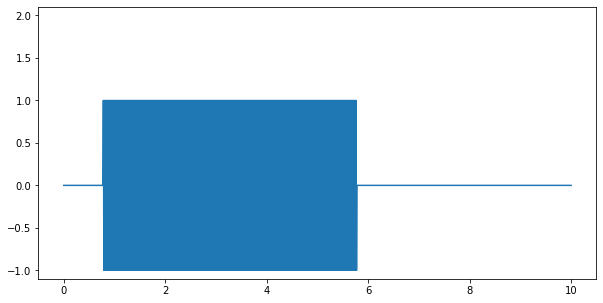

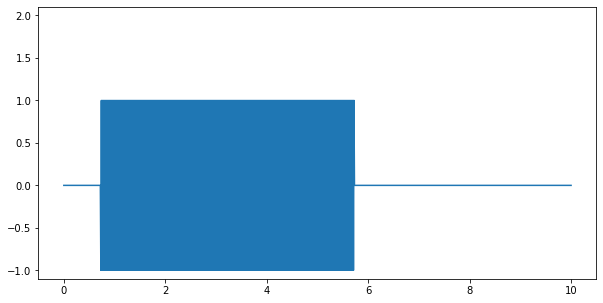

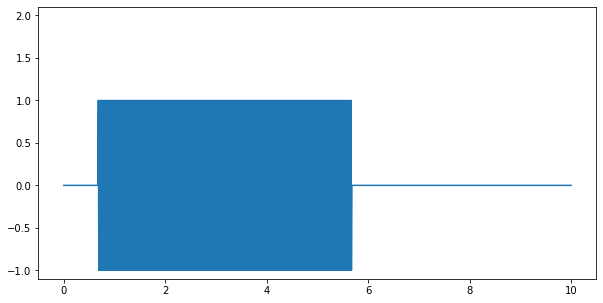

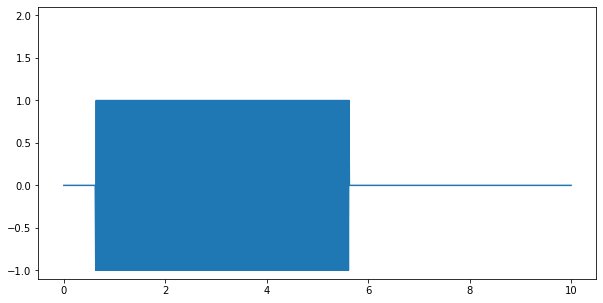

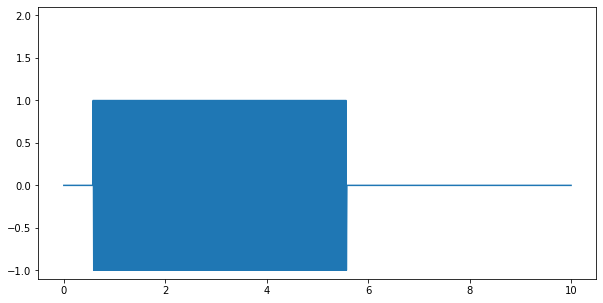

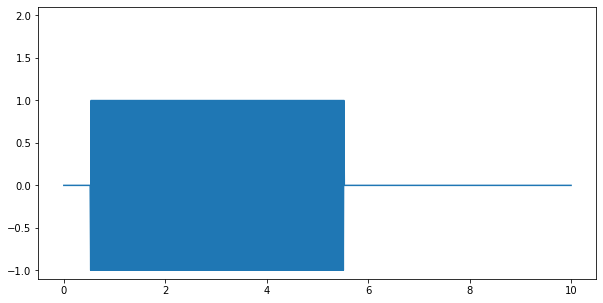

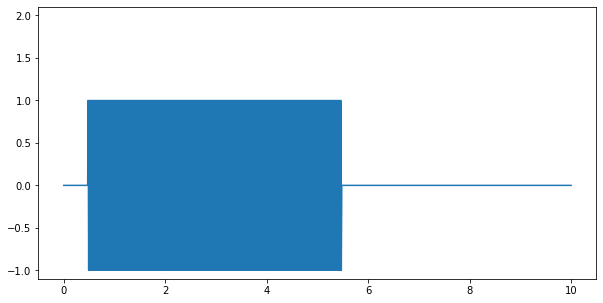

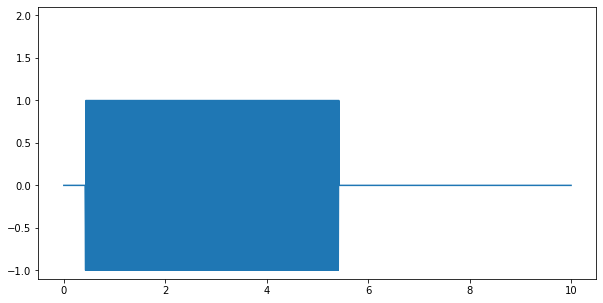

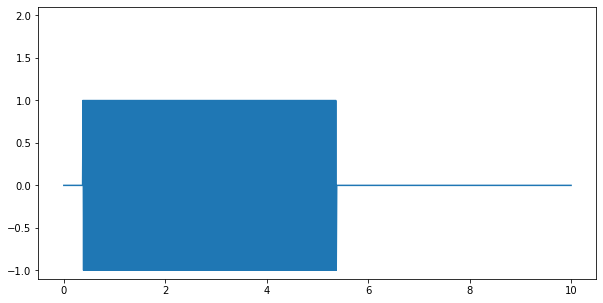

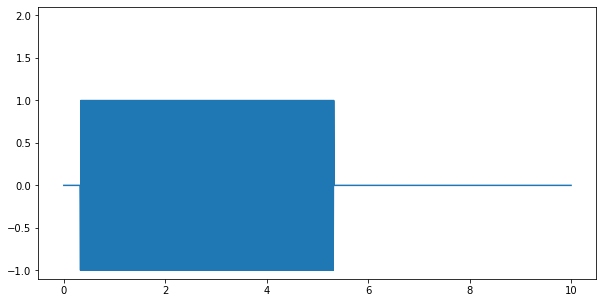

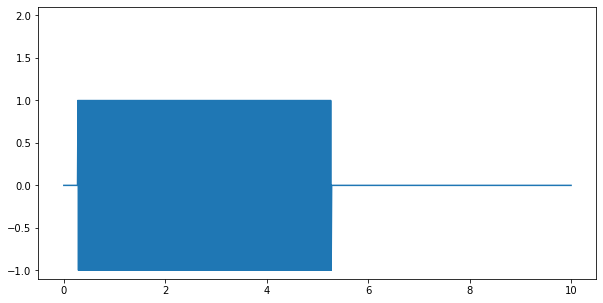

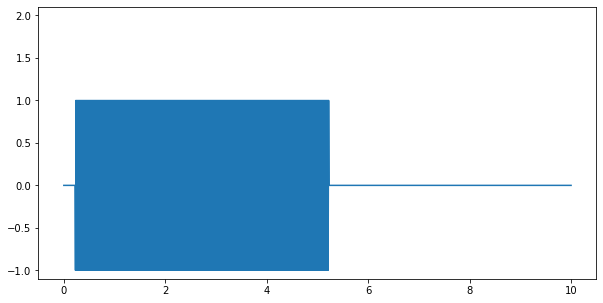

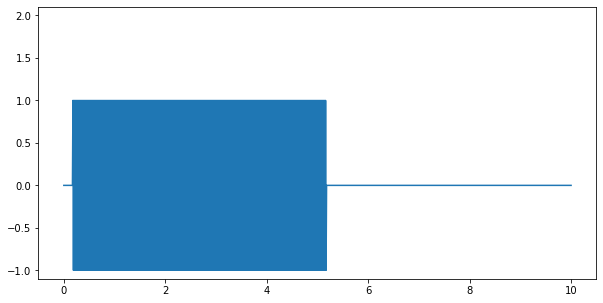

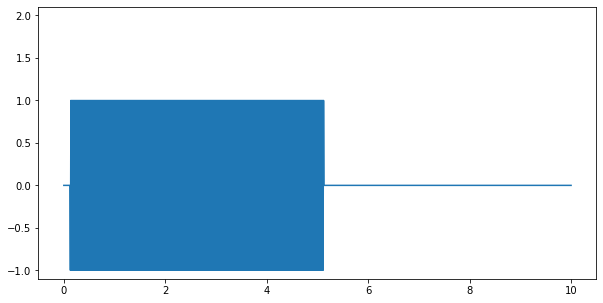

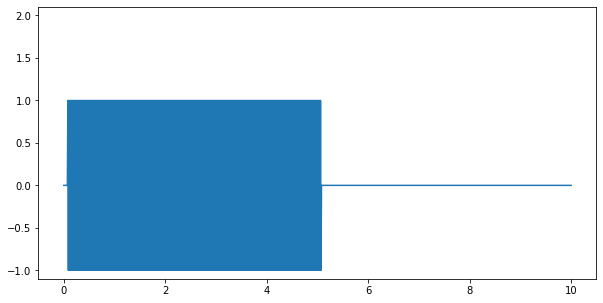

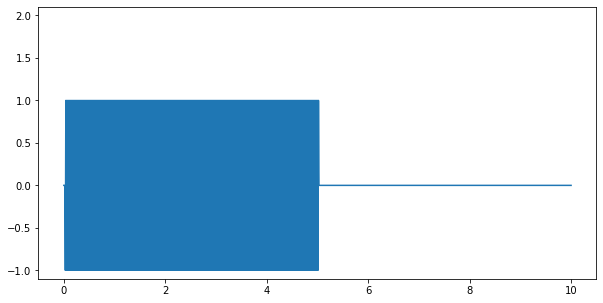

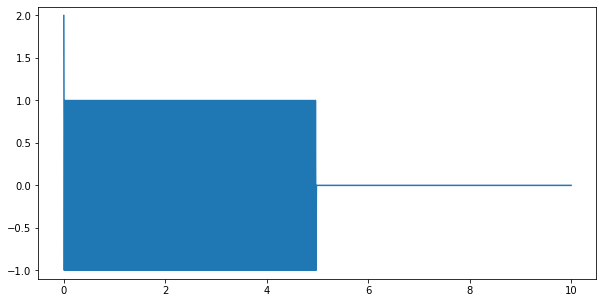

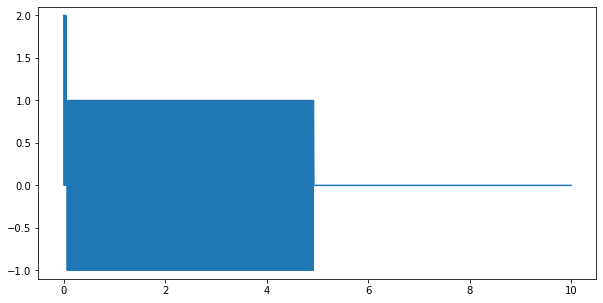

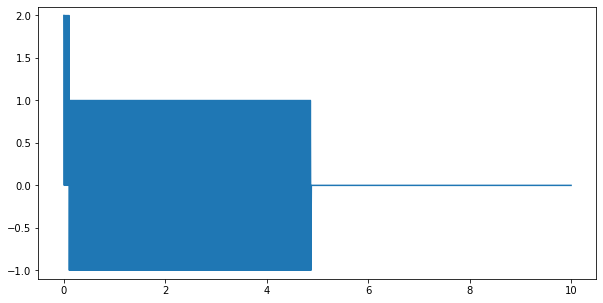

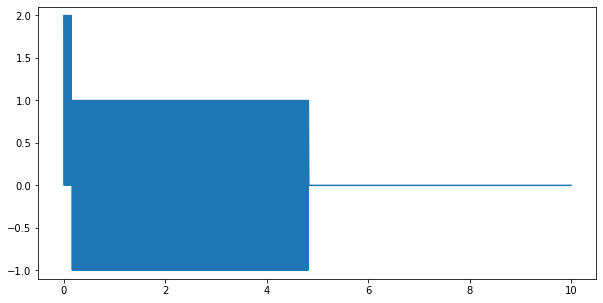

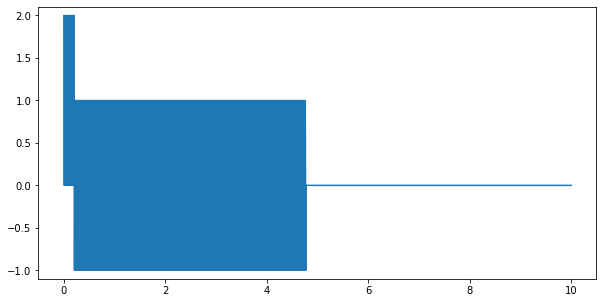

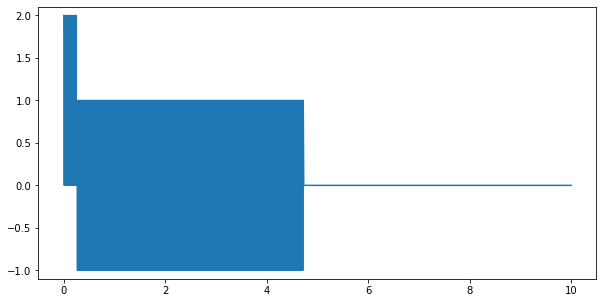

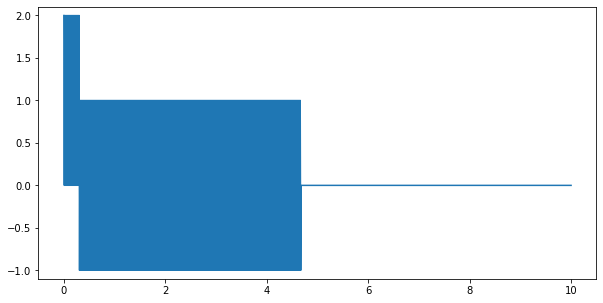

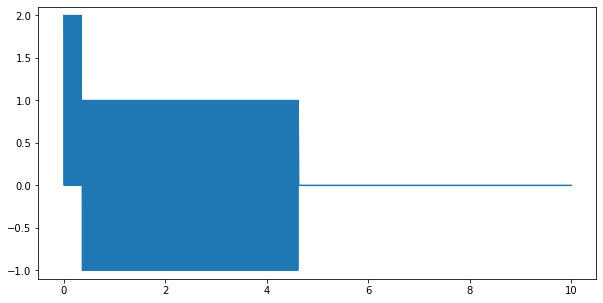

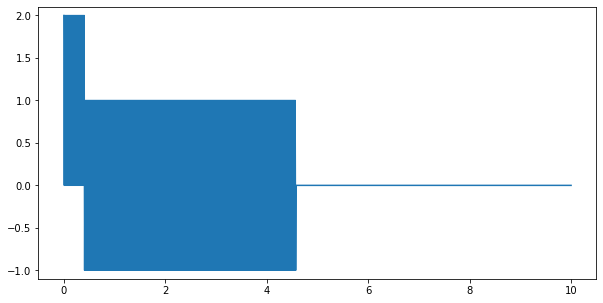

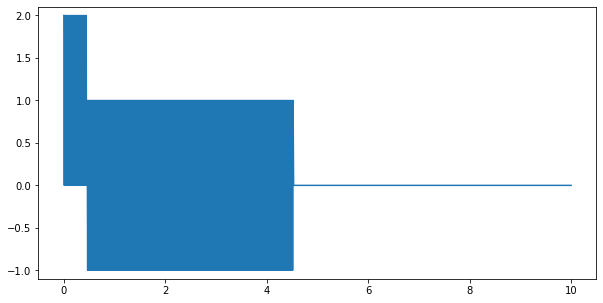

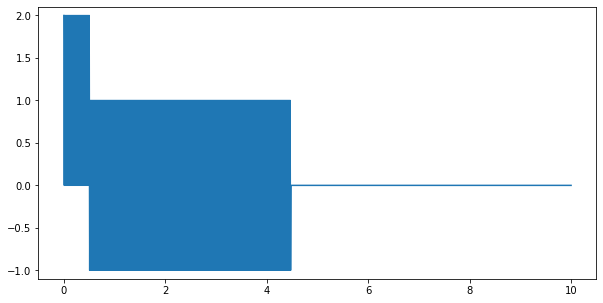

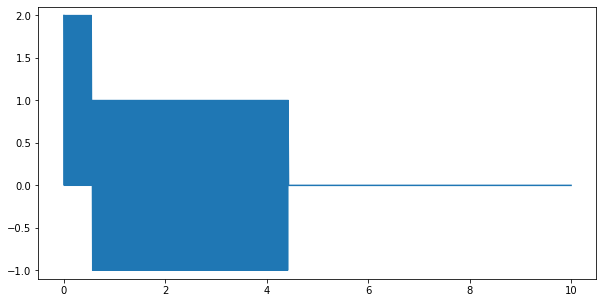

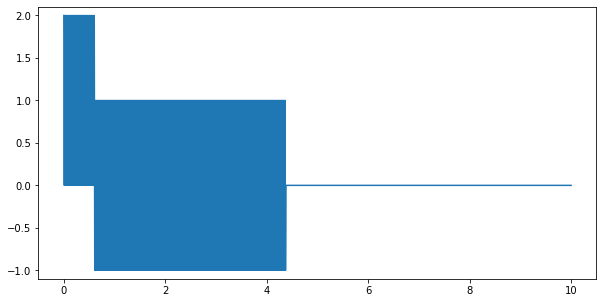

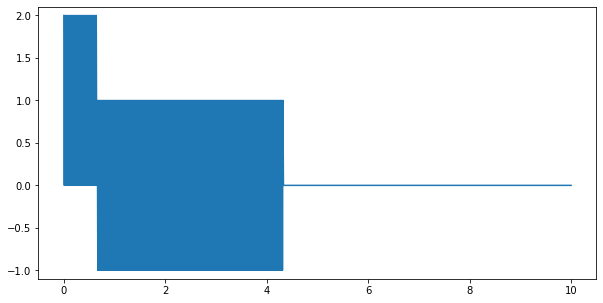

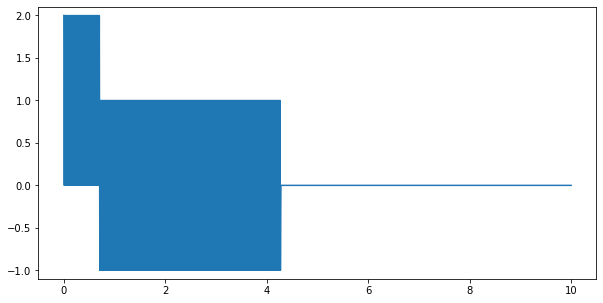

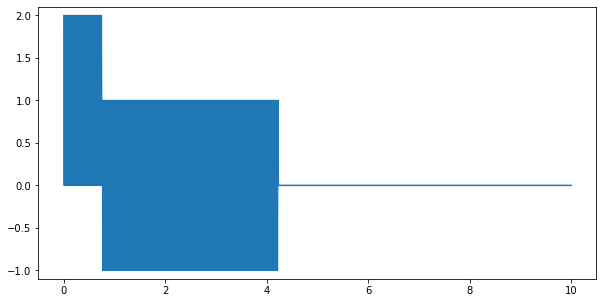

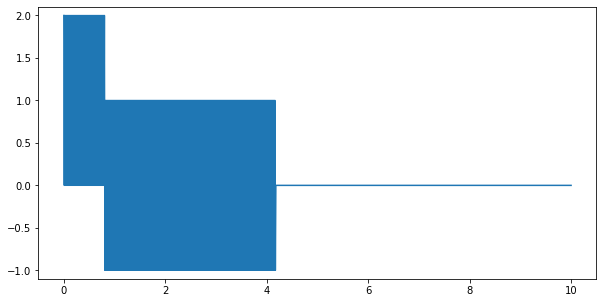

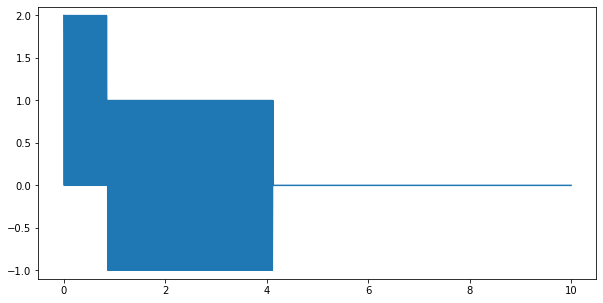

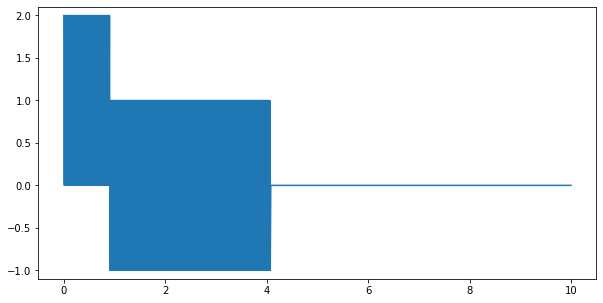

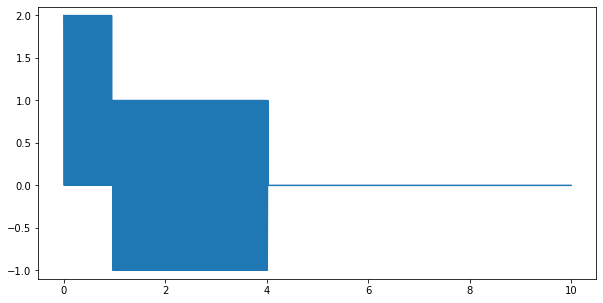

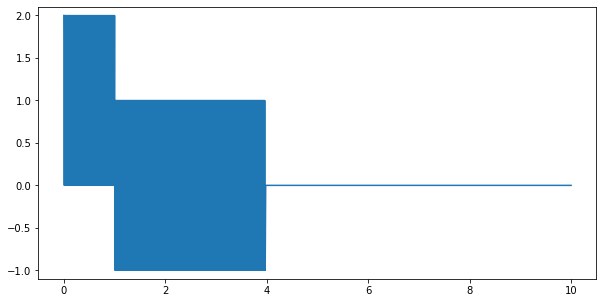

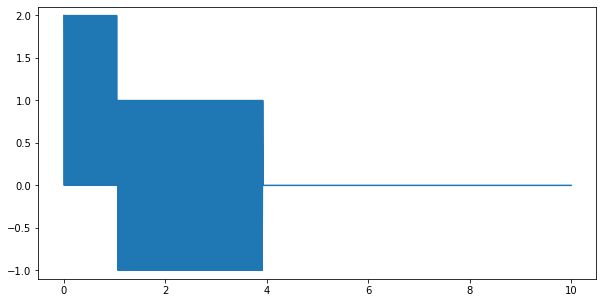

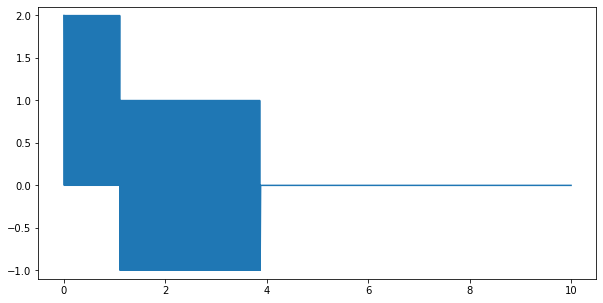

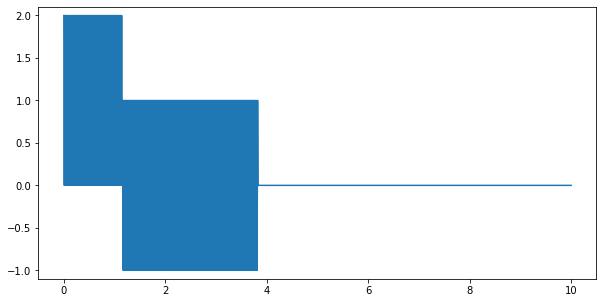

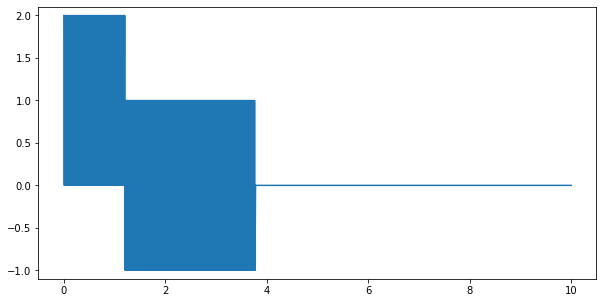

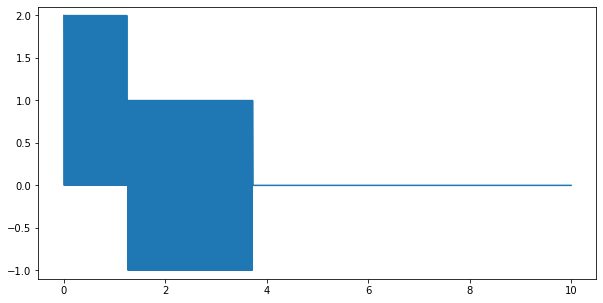

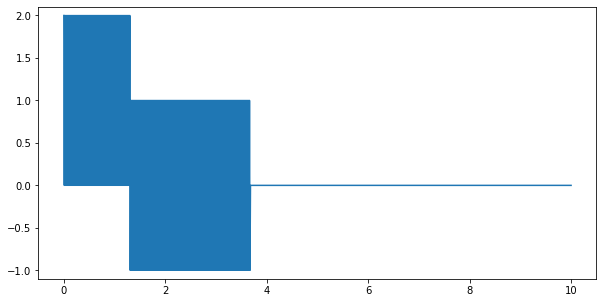

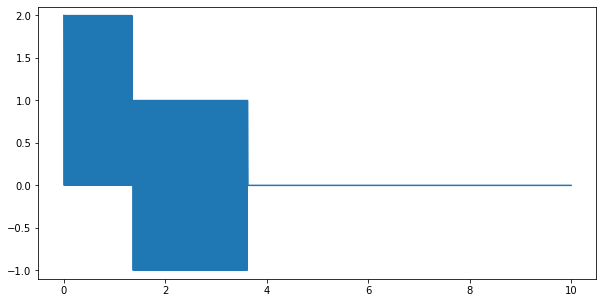

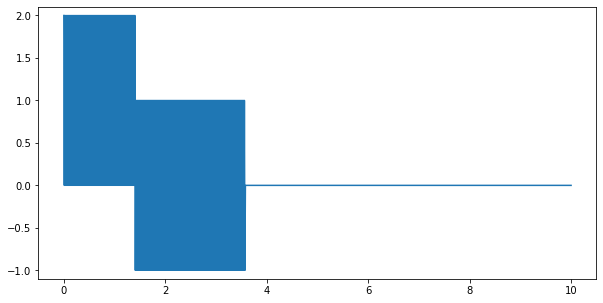

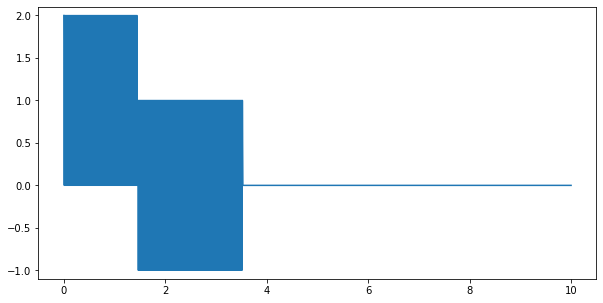

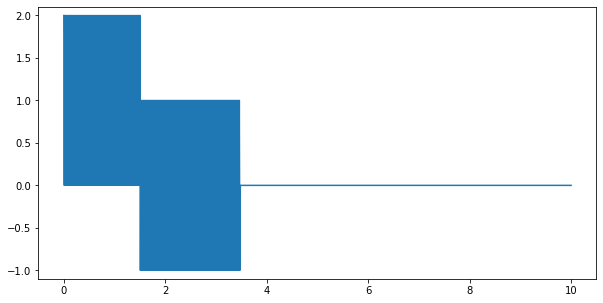

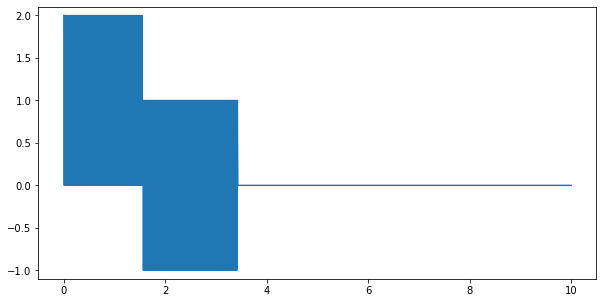

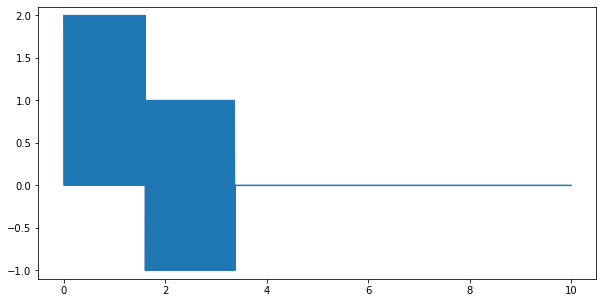

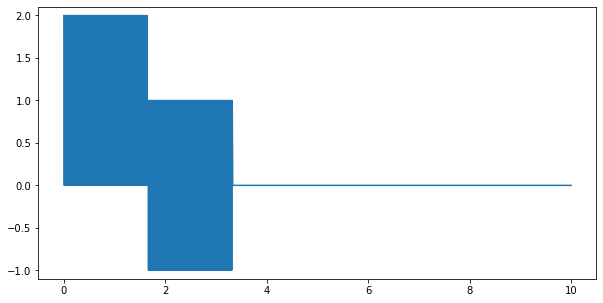

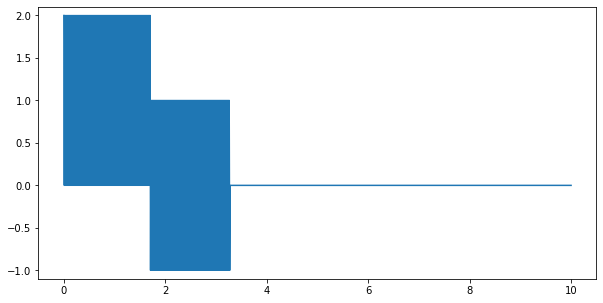

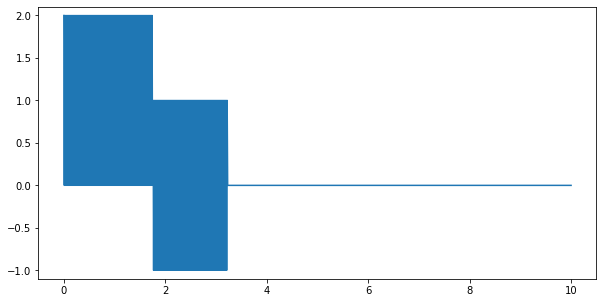

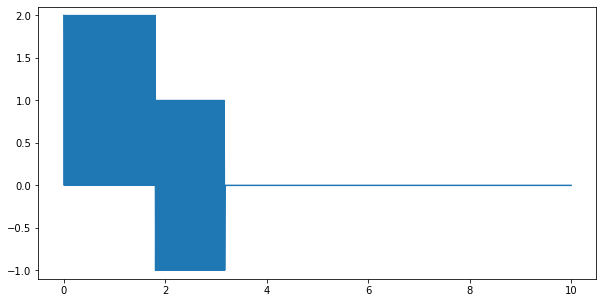

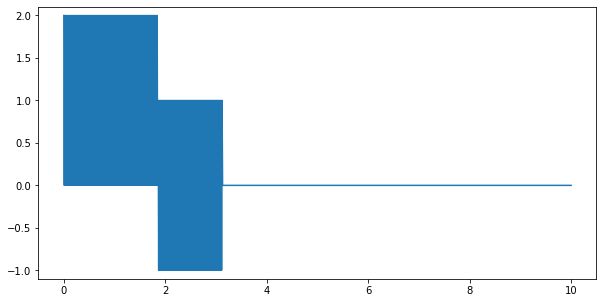

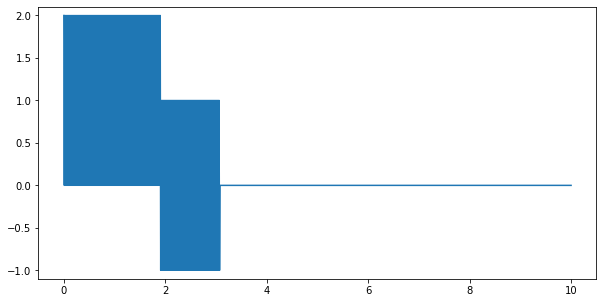

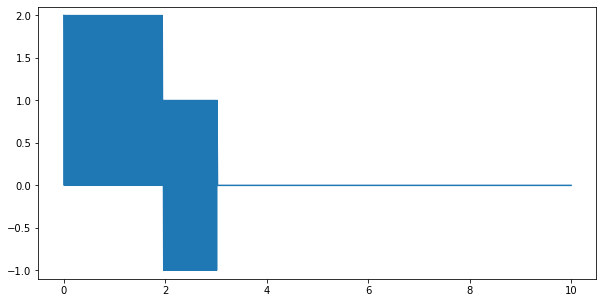

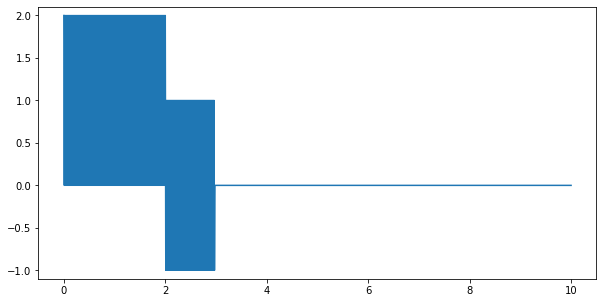

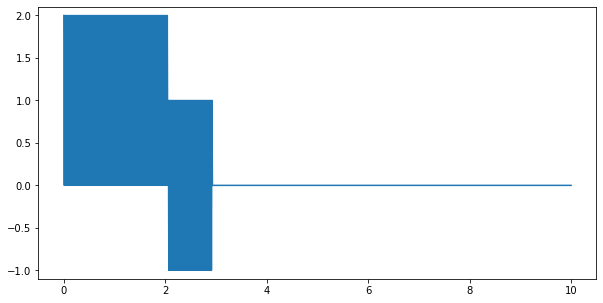

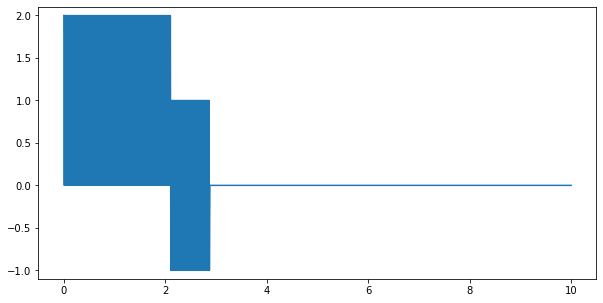

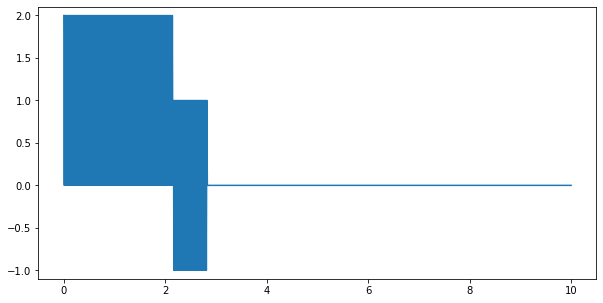

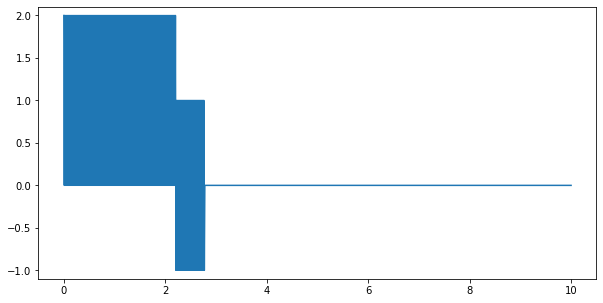

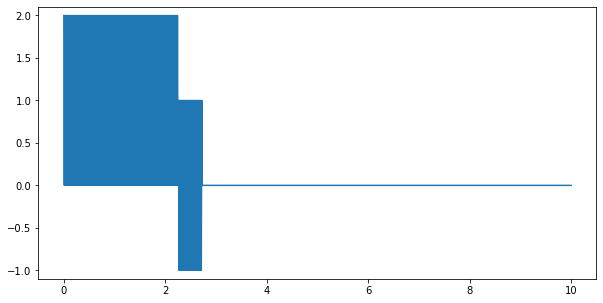

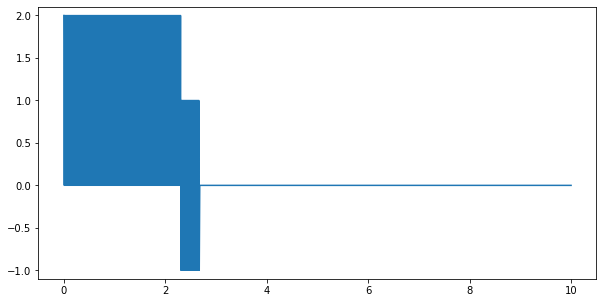

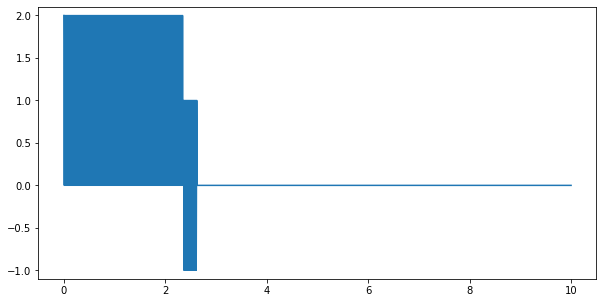

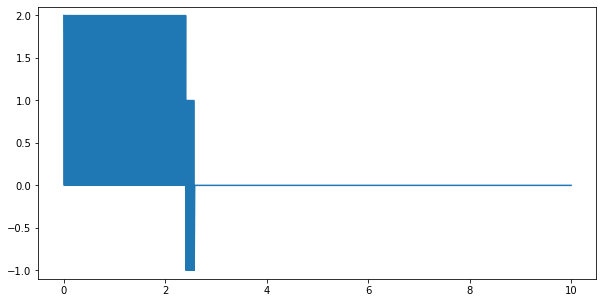

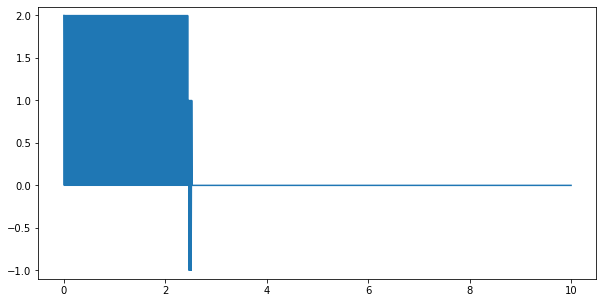

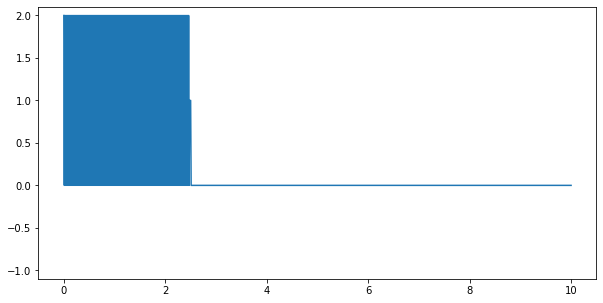

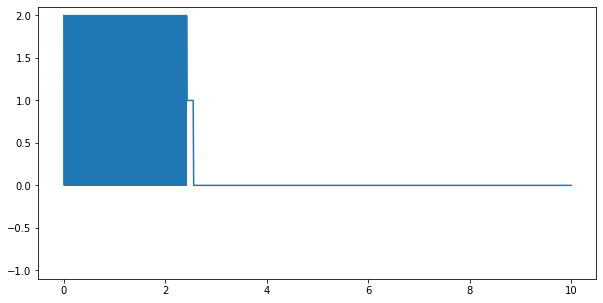

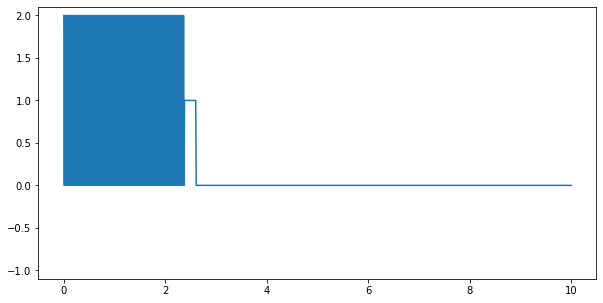

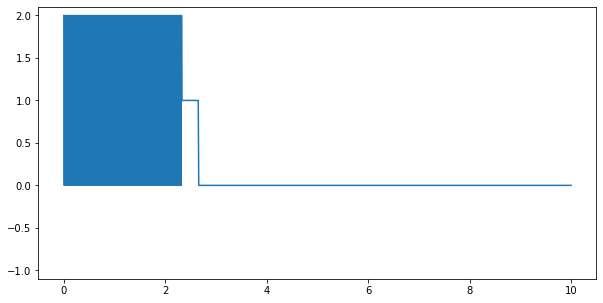

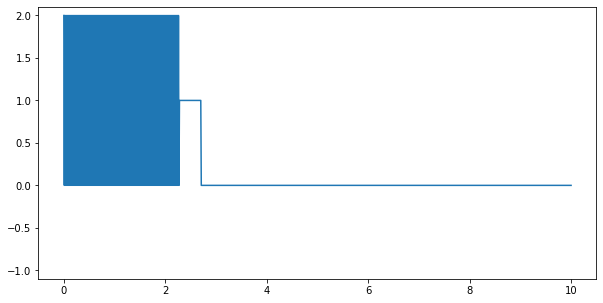

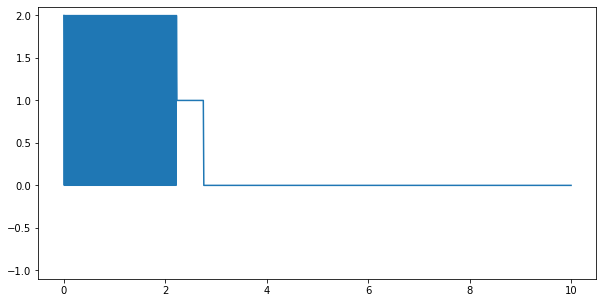

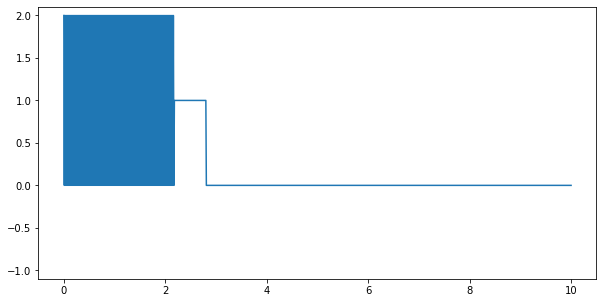

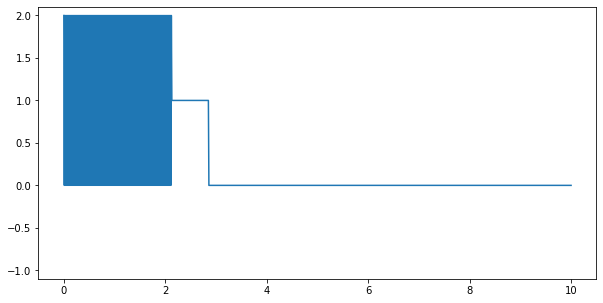

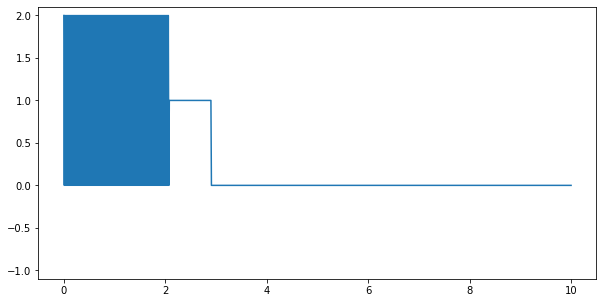

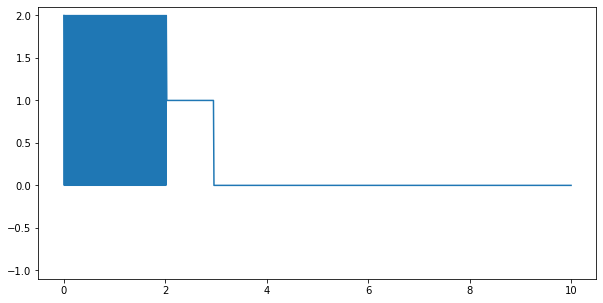

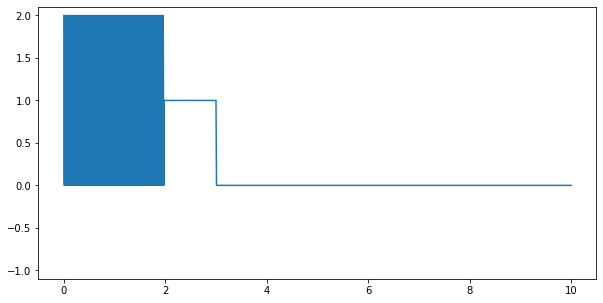

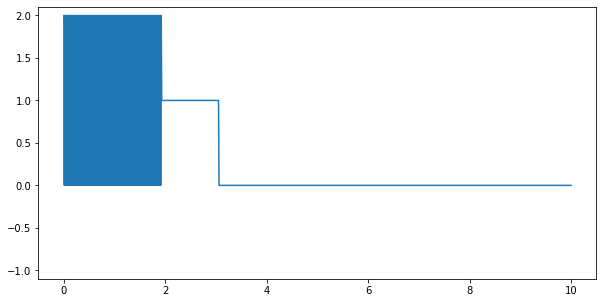

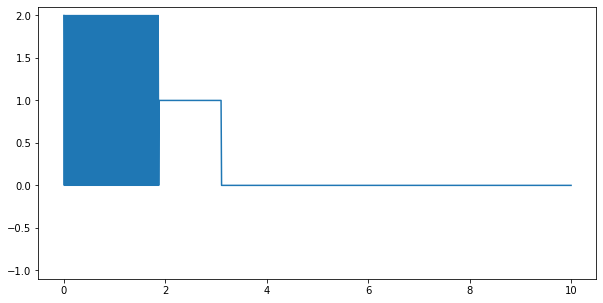

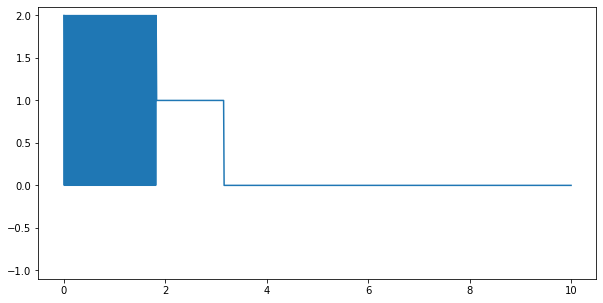

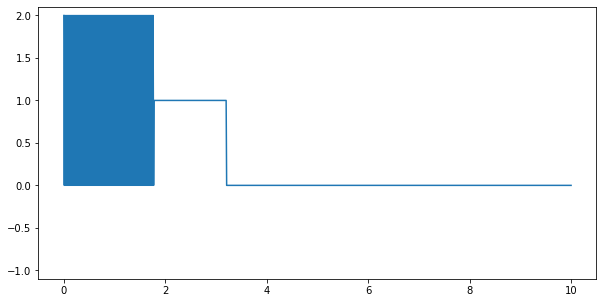

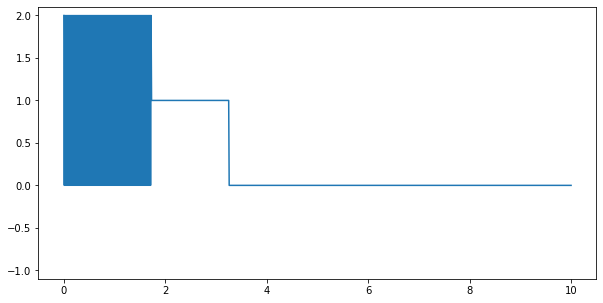

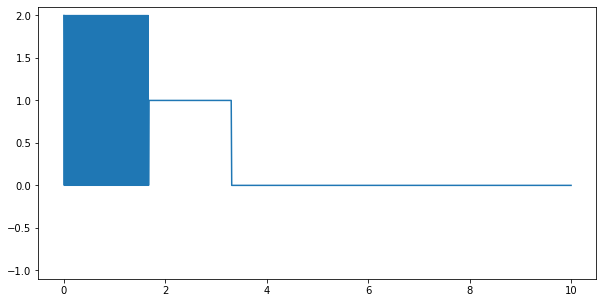

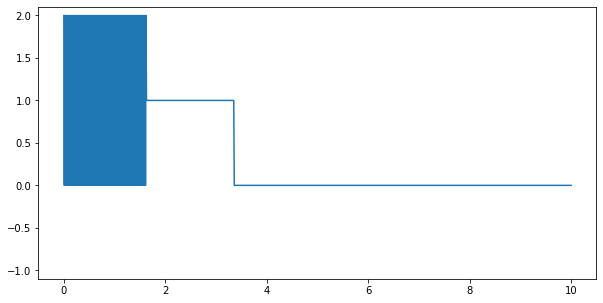

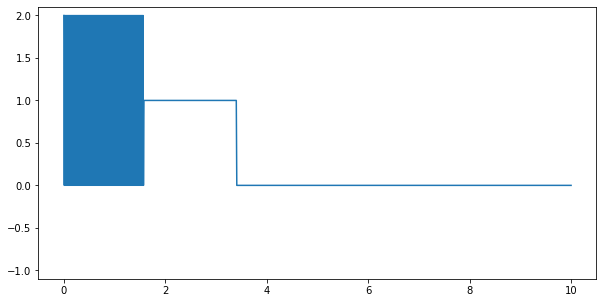

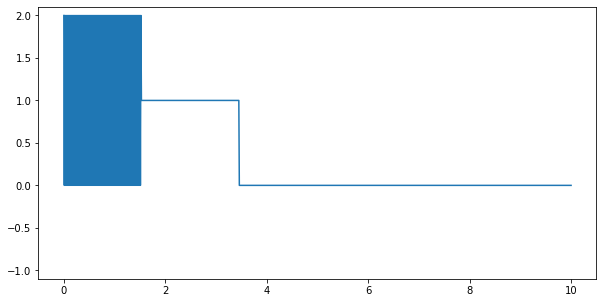

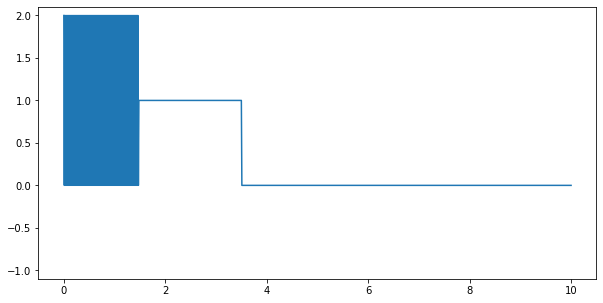

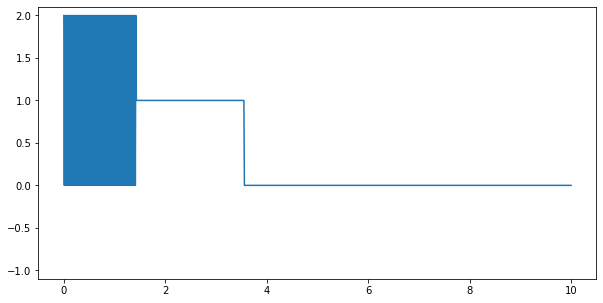

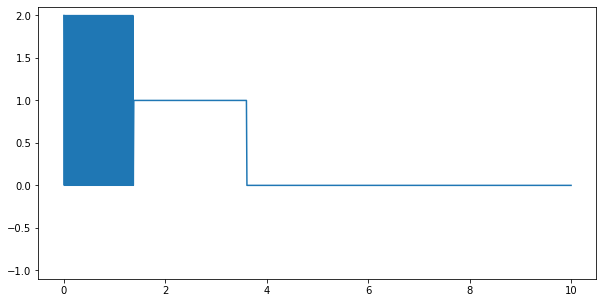

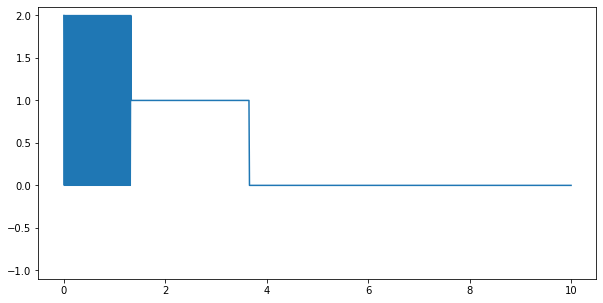

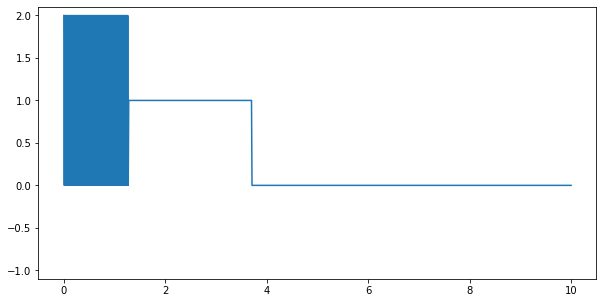

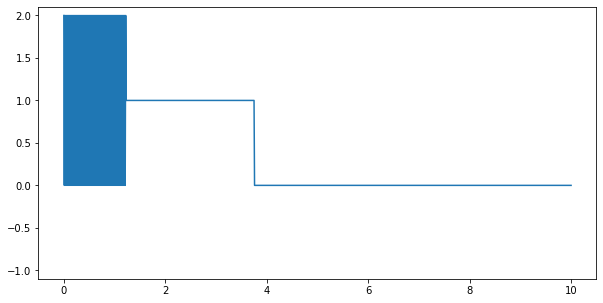

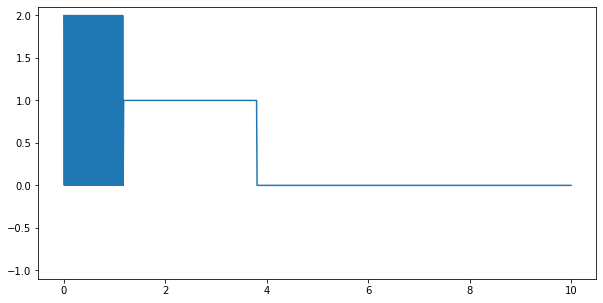

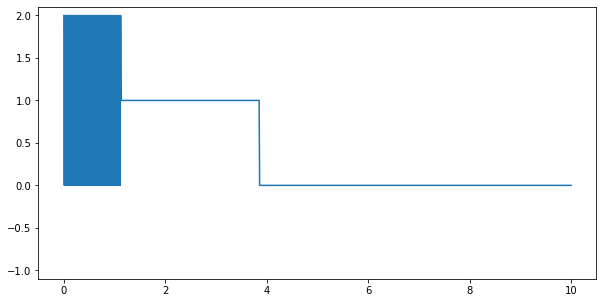

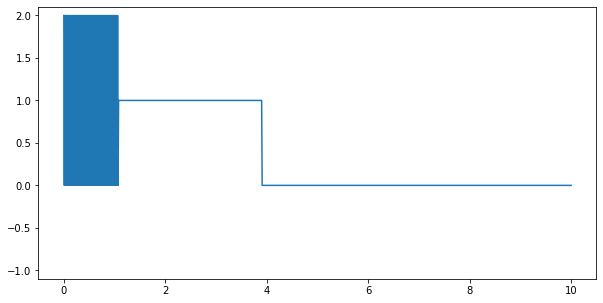

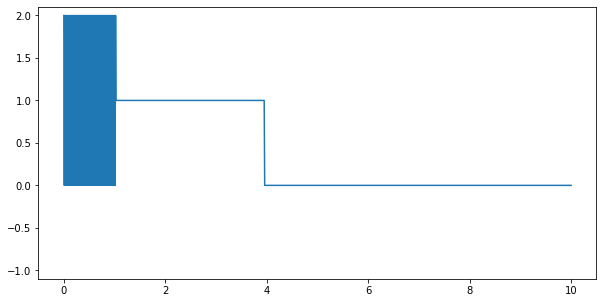

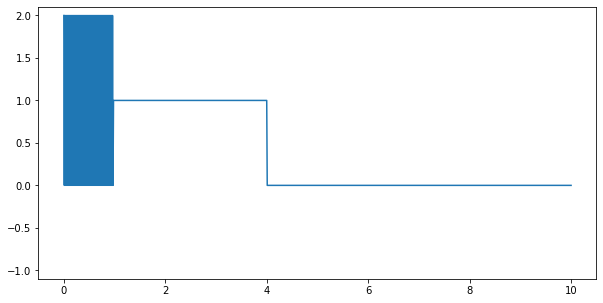

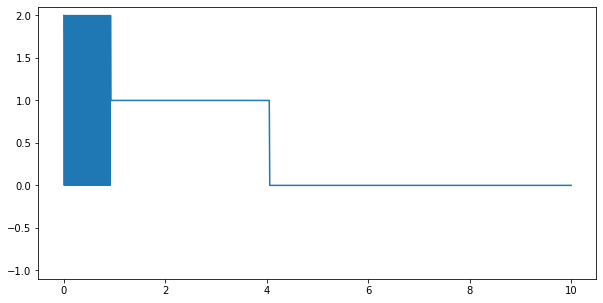

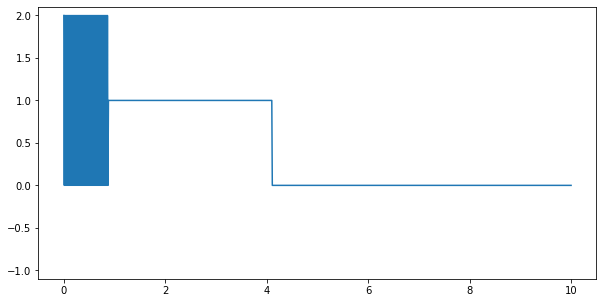

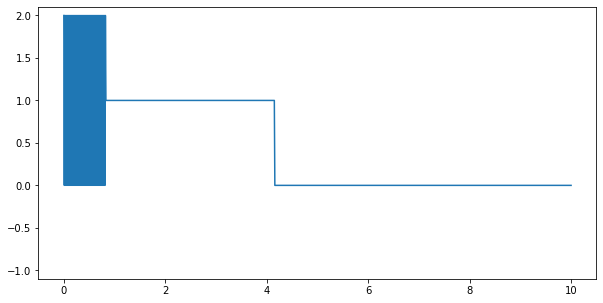

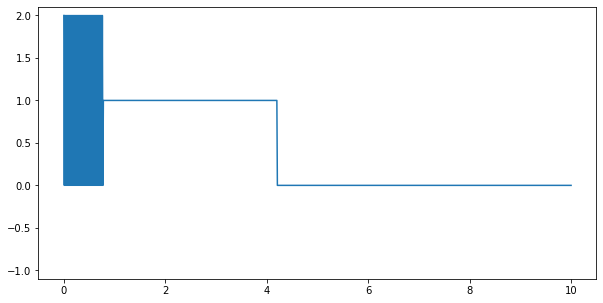

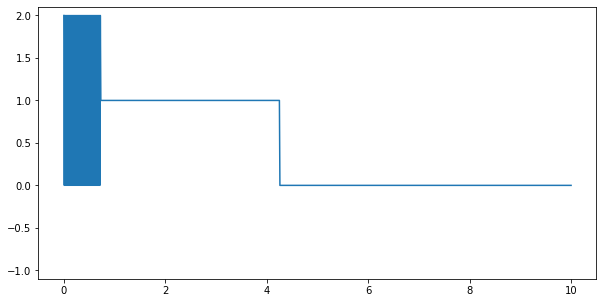

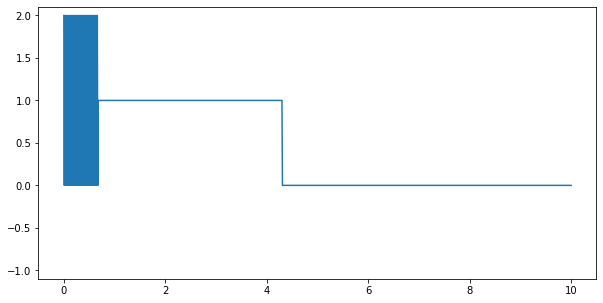

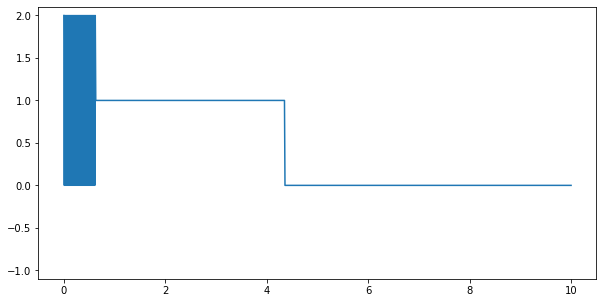

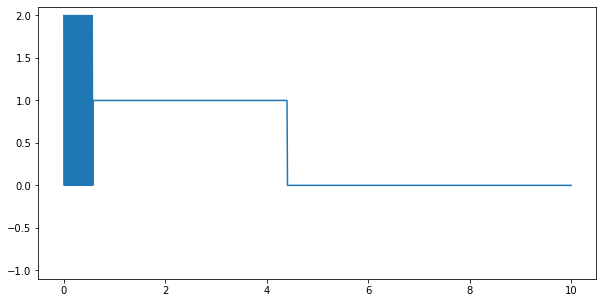

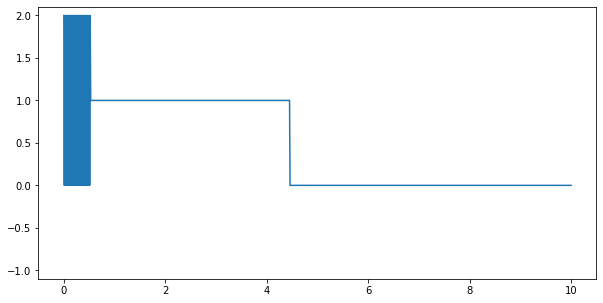

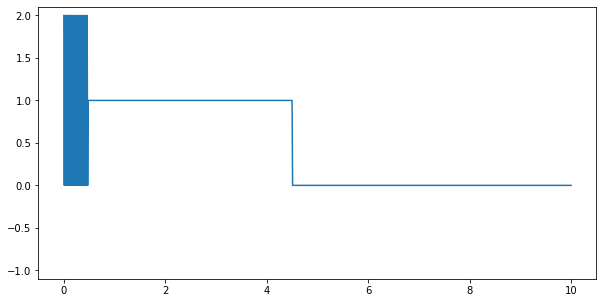

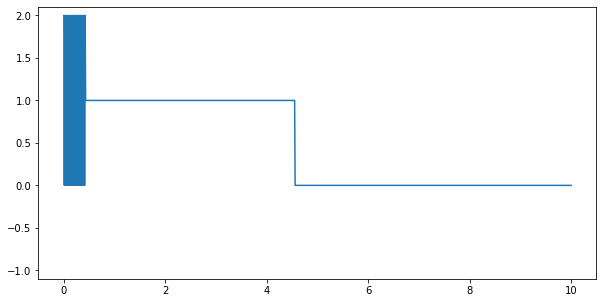

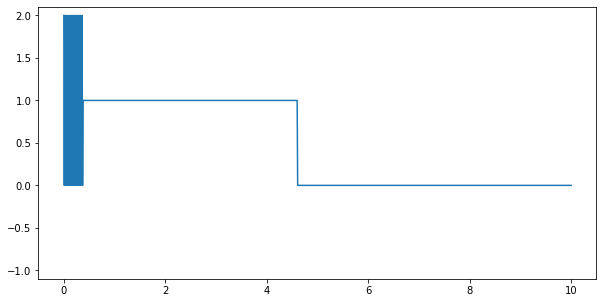

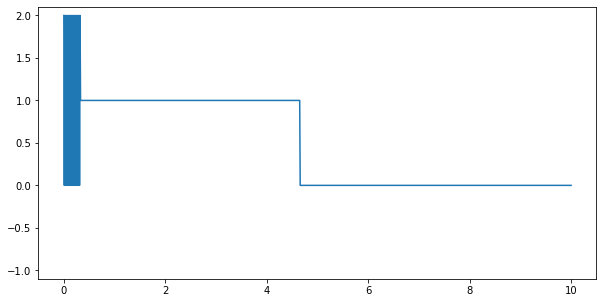

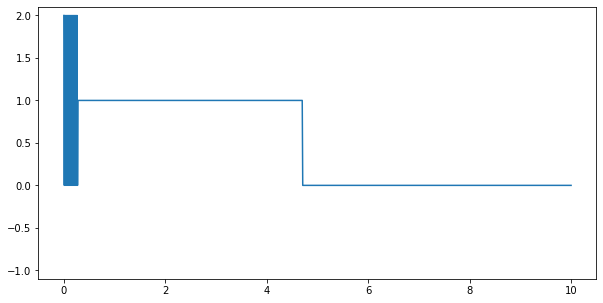

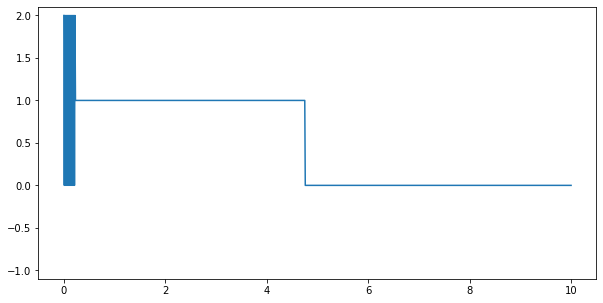

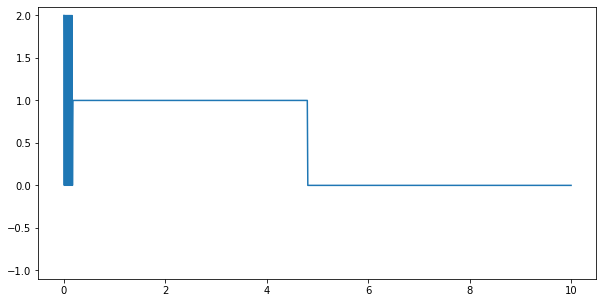

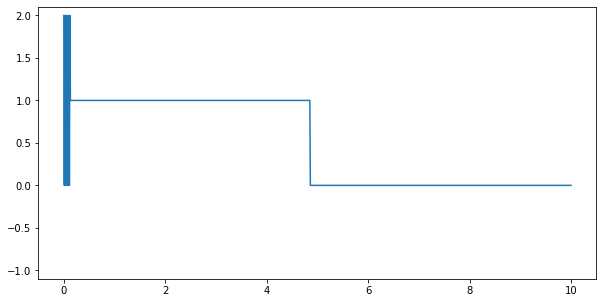

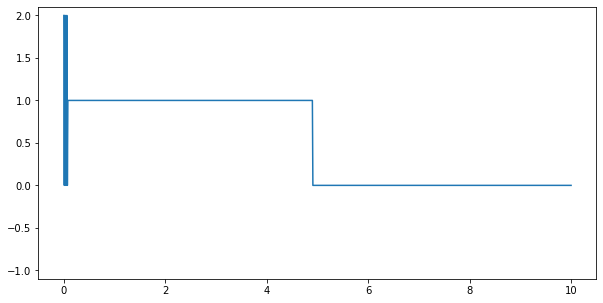

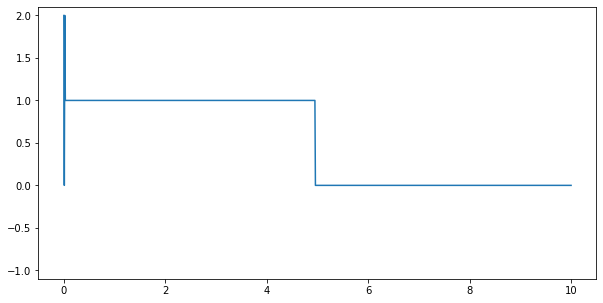

In [16]:
xs = [
    a + i * dx
    for i in range(K)
]

y_min = np.min(np.array(Ts))
y_max = np.max(np.array(Ts))

def plot_img(cur_index):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(xs, Ts[cur_index])

    ax.set_ylim(y_min - 0.1, y_max + 0.1)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

frames = [
    plot_img(i)
    for i in tqdm_notebook(range(len(Ts)))
    if i % 5 == 0
]
imageio.mimsave('./T.gif', frames, fps=24)